# Introduction
In this assignment, we will be looking at the temperature dynamics of a two-dimensional square plate, with sides $[-1,1] \times [-1,1]$. We will be heating the plate up from one hand-side, with the temperature distribution following the following equation,
$$u_t = \Delta u$$
where $u$ is a mathematical object describing the temperature at a point in space and time.

This equation is a second-order partial differential equation relating space and time, and is therefore very difficult, if not impossible, to analytically solve. However, it is possible to approximate the partial derivatives in the above equation by using finite difference techniques. This process is known as "vectorising" a differential equation, which works excellently with computers due to their inherently parallel nature.

Specifically, we will be investigating three different methods of vectorising this equation:

*   The foward difference method, which is also known as an explicit technique.
*   The backward difference method, which is an implicit technique.
*   The Crank-Nicolson method, which can be thought of as a combination of the previous two. It is also an implicit technique.

We will numerically assess the stability of these three methods, and reason why some may fail whilst others may not. The majority of this assignment will be centered around analysing the temperature of the center point of this plate. In particular, we will be estimating the time $t^*_{obs}$ for the center of the plate to reach a temperature $u=1$, and see how close we can reach the true value $t^* = 0.424011387033$ to twelve decimal places.

We will be using a GPU implementation for the explicit method, whilst the implicit methods will specialise in sparse matrix solvers. This assignment will be completed in Google Colab using NVIDIA's T4 GPU in Python.

# Imports
Here we will be importing the necessary modules for this assignment. Some of them are imported here, but there are a few modules later on which are imported elsewhere. I decided to import them later on as this helps with the flow of the assignment.

In [1]:
# Plot based imports
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib as mpl
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi'] = 300  # dots per inch

# SciPy/NumPy imports
import numpy as np
from tqdm import tqdm

# We need to speed things up!
from numba import njit

## Check to see if a CUDA device has been detected
To confirm if our CUDA imports work correctly, we check if a CUDA device has been detected using `cuda.detect()`.

In [2]:
from numba import cuda
cuda.detect()

Found 1 CUDA devices
id 0             b'Tesla T4'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 4
                              PCI Bus ID: 0
                                    UUID: GPU-e74a8860-5c84-8556-74d1-46883aefbe55
                                Watchdog: Disabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True

# Forward difference implementation
In two dimensions, the heat distribution over the plate evolves according to the equation
$$u_t = \Delta u = \nabla^2 u$$

where $u_t$ is short-hand for the partial derivative of $u$ with respect to time $t$, $\frac{\partial u}{\partial t}$.

Noting that the Laplacian $\nabla^2 = \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2}$ in two dimensions, the above equation can be written as

$$\frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}$$

Of course, computers cannot analytically solve this differential equation; we will need to vectorise things to pass as an array to our device. To this end, we will need to approximate these derivatives as difference between terms which will be indexed.

We start off with the left hand side term, which is just a first-order derivative, therefore the simplest.

In the exact limit, a forward-difference derivative may be written as  
$$ \frac{\partial u}{\partial t} = \lim_{\Delta t \rightarrow 0} \frac{u(t + \Delta t) - u(t)}{\Delta t} $$
which for small $\Delta t$ can be approximated as
$$ \frac{\partial u}{\partial t} \approx \frac{u(t + \Delta t) - u(t)}{\Delta t}. $$
We can adopt an index notation such that $u(t + \Delta t) = u_{i,j}^{n+1}$ and $u(t) =  u_{i,j}^n$. Here, $i,j$ represent the coordinate indices and the $n$ represents the time index. This notation makes the naming "forward difference" clearer, due to the subtraction between the $n+1$th time index and the $n$th time index. Then the above equation becomes,

$$\frac{\partial u}{\partial t} = \frac{u_{i,j}^{n+1} - u_{i,j}^n}{\Delta t}.$$

We can also derive an appropriate index notation for the right-hand side, but we will have to be more clever in doing so. We can proceed by thinking about $\frac{\partial^2 u}{\partial x^2}$ as

$$\frac{\partial^2 u}{\partial x^2} = \frac{\partial}{\partial x} \left( \frac{\partial u}{\partial x} \right)$$

and instead employ a centered-difference technique for $\frac{\partial u}{\partial x}$ over a two-sided difference $\Delta x/2$ as

$$\frac{\partial u}{\partial x} \approx \frac{u(x+\Delta x/2) - u(t-\Delta x/2)}{\Delta x}$$

such that

$$\frac{\partial}{\partial x} \left( \frac{\partial u}{\partial x} \right) \approx \frac{\partial}{\partial x} \left( \frac{u(t+\Delta x/2) - u(x-\Delta x/2)}{\Delta x} \right) = \frac{1}{\Delta x}\frac{\partial}{\partial x} u(t+\Delta x/2) - \frac{1}{\Delta x}\frac{\partial}{\partial x} u(t-\Delta x/2). $$

We can again employ a centered-difference technique over $\Delta t/2$ for these two individual terms,

$$\frac{1}{\Delta x}\frac{\partial}{\partial x} u(x+\Delta x/2) = \frac{1}{\Delta x}\frac{u(x+\Delta x) - u(x)}{\Delta x} = \frac{u_{i+1,j}^n - u_{i,j}^n}{\Delta x^2},$$
and
$$\frac{1}{\Delta x}\frac{\partial}{\partial x} u(x-\Delta x/2) = \frac{1}{\Delta x}\frac{u(x) - u(x - \Delta x)}{\Delta x} = \frac{u_{i,j}^{n} - u_{i-1,j}^{n}}{\Delta x^2},$$

where the $i$ th index is changed, as this is what the $x$ difference specifies. Subtracted from eachother, we can then obtain the index notation of the second order derivative as the following expression,

$$\frac{\partial^2 u}{\partial x^2} \approx \frac{u_{i+1,j}^n - 2u_{i,j}^n + u_{i-1,j}^n}{\Delta x^2},$$

which is also known as a "three-point stencil".

A similar procedure can be completed for the $y$ derivative, in which the $j$-index changes, this yields the expression,

$$\frac{\partial^2 u}{\partial y^2} \approx \frac{u_{i,j+1}^n - 2u_{i,j}^n + u_{i,j-1}^n}{\Delta y^2}.$$

Returning to the expression $\frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}$, we can now write this whole expression in index notation as

$$\frac{u_{i,j}^{n+1} - u_{i,j}^n}{\Delta t} = \frac{u_{i+1,j}^n - 2u_{i,j}^n + u_{i-1,j}^n}{\Delta x^2} + \frac{u_{i,j+1}^n - 2u_{i,j}^n + u_{i,j-1}^n}{\Delta y^2}.$$

Now we assume that $\Delta x = \Delta y$, which almost certainly holds in cases where the plate we look at has similar $x-$ and $y-$dimensions. Then, the equation simplifies to,

$$\frac{u_{i,j}^{n+1} - u_{i,j}^n}{\Delta t} = \frac{u_{i+1,j}^n - 2u_{i,j}^n + u_{i-1,j}^n + u_{i,j+1}^n - 2u_{i,j}^n + u_{i,j-1}^n}{\Delta x^2} = \frac{u_{i+1,j}^n + u_{i-1,j}^n + u_{i,j+1}^n + u_{i,j-1}^n - 4u_{i,j}^n}{\Delta x^2} .$$

It is logical to re-arrange this equation for the $u_{i,j}^{n+1}$ term which describes the heat distribution at the $i,j$ th index at the next time which is denoted by the index $n+1$. Doing so, we obtain the following expression,

$$u_{i,j}^{n+1} = u_{i,j}^n + \frac{\Delta t}{\Delta x^2}(u_{i+1,j}^n + u_{i-1,j}^n + u_{i,j+1}^n + u_{i,j-1}^n - 4u_{i,j}^n),$$

where the prefactor

$$\frac{\Delta t}{\Delta x^2} = \gamma.$$


Here, the indices $i,j$ and $n$ represent the discretisation of the spatial and temporal parts respectively. The spatial indices $i,j$ will run as $0,1,...,N-1$ where $N$ represents the amount of grid points we choose. Since we impose Dirichlet boundary conditions on both edges of the $x,y$ coordinates, we are left with the spatial indices $i,j = 1,2,...,N-2$ to evaluate. Therefore, we have $N-2$ indices in total along both spatial coordinates to evaluate.

For this forward-difference implementation to be stable, this coefficient $\gamma \leq 1/4$. This ensures that the matrix representation of the above equation yields negative eigenvalues, which indicates a stable exponential solution (the actual maths behind this is more complicated, and not really relevant to the assignment).

Below, we will be using a GPU implementation of the explicit method.

## Functions for GPU parallelisation
To parallelise the explicit solver over the GPU, we will need two functions. This is because of the time-dependence of the $u_{i,j}^{n}$ term. Although the indices $i,j$ are equivalent and can thus be appropriately parallelised, as they are, these two indices are not at all independent of $n$, the time-index. We cannot parallelise indices which depend on eachother, as this means we would need to do their computations at the same time, despite the fact that we need one computation for the other! We need to therefore choose an index which we loop over the GPU (also called device) and the CPU (also called the kernel).

In the code below, I decide to loop over the spatial indices $i,j$ in the GPU and over the time-index $n$ in the CPU.

### Function for GPU loop
We loop over the spatial indices $i$ and $j$, as mentioned. Actually, the below implementation is not currently the quickest. This is because we use the entire $u$ array rather than 'snippets' of the whole $u$ array corresponding to $u^{n+1}$ and $u^n$, which are technically the only two components needed. We do rectify this later on when we estimate $t^*$.

In [3]:
@cuda.jit
def explicit_heat_device(u, n, gamma):
  """CUDA kernel to update the temperature at each grid point for a single time step,
  according to the two-dimensional heat equation du/dt = Delta u.
  I.e. loops over i,j in u[i,j,n], where n is the time index.

  Inputs:
  u - three-dimensional array storing temperature at each time step in GPU
  n - the current time-step index
  gamma - prefactor in front of Laplacian in the heat equation update, can be thought of as controlling temporal discretisation"""
  # Create cuda grid and extract array size
  i, j = cuda.grid(2)
  img_size_x, img_size_y, _ = u.shape
  # Only update interior points, this acts as a 'guard'
  if (1 <= i < img_size_x - 1) and (1 <= j < img_size_y- 1):
    L = u[i+1,j,n] + u[i-1,j,n] + u[i,j+1,n] + u[i,j-1,n] - 4*u[i,j,n]
    u[i,j,n+1] = u[i,j,n] + gamma*L

### Function for CPU loop
We initialise the $u$ array in the kernel (CPU), alongside with the appropriate discretisations. Then we copy this array to the GPU for the previous function, `explicit_heat_device`, to spatially loop over. And we call this `explicit_heat_device` function repeatedly under a time-index loop, to retrieve the full information (history) of the temperature distribution.

Before we continue, we should raise a point about GPU precision. When we checked to see if a CUDA device was detected, we were met with a few lines of outputs. One of those lines were the following:

    FP32/FP64 Performance Ratio: 32

This line tells us that for NVIDIA's T4 GPU, which is the one we use for this assignment, `float32` is **thirty-two** times more efficient than `float64`! Therefore, to exploit the full efficiency of this GPU, we would usually do `dtype=np.float32`. However, for the purposes of this assignment, we default `dtype=np.float64`.

In [4]:
def explicit_heat_kernel(N, t_max, gamma, dtype=np.float64):
  """Solves the two-dimensional heat equation du/dt = Delta u via GPU parallelisation, using Numba CUDA.
  Contains the kernel function explicit_heat_device inside, which is repeatedly looped over time.

  Inputs:
  N - number of gridpoints along one dimension, the spatial discretisation
  t_max - maximum time we wish to iterate the heat equation up to
  gamma - prefactor in front of Laplacian in the heat equation update, can be thought of as controlling temporal discretisation
  dtype (default:float64) - the type we initialise our problem with.

  Outputs:
  u - three-dimensional array, where two dimensions represent the spatial heat, third dimension is over time. Host array."""
  # The length of our problem is 2 in either dimension, as the plate spans -1 < x,y < 1
  length = 2.0
  # Calculate dx and dt according to gamma
  dx = length / (N - 1)
  dt = gamma * dx ** 2
  # Find total number of time steps
  time_steps = int(np.ceil(t_max / dt))

  # Set up storage for u, initial array
  u = np.zeros((N, N, time_steps+1), dtype=dtype)
  # Initialise Dirichlet boundary conditions
  u[:, 0, :] = 0.0
  u[0, :, :] = 0.0
  u[-1, :, :] = 0.0
  u[:, -1, :] = 5.0

  # The only thing which we will need to copy to the GPU is the u array
  u_gpu = cuda.to_device(u)

  # Each block contains 256 threads, like in the examples
  blockdim_x, blockdim_y = 16, 16
  blockdim = (blockdim_x, blockdim_y)
  griddim_x = int(np.ceil(N / blockdim_x)); griddim_y = int(np.ceil(N / blockdim_y))
  griddim = (griddim_x, griddim_y)

  # Loop over time steps,
  for n in range(time_steps):
    explicit_heat_device[griddim, blockdim](u_gpu, n, gamma)

  # Synchronize all threads and retrieve array from GPU
  cuda.synchronize()
  u_gpu.copy_to_host(u)
  return u

## Assessing different $\gamma$ values
We have mentioned that there is a certain $\gamma$ beyond which the heat equation solution becomes unstable and diverges. Specifically, we stated that this was $\gamma > 1/4$. Mathematically showing this is quite difficult as it requires us to derive the eigenvalues of the discretised heat equation above. However, we can at least computationally show by investigating a range of values of $\gamma$ that this is the case.

We will investigate the range $0.05 \leq \gamma \leq 0.30$, solving the heat equation for each $\gamma$ here. Additionally, we will also investigate the time-efficiency of these solutions for certain values of $\gamma$. The code above is written in such a way that the value of $\gamma$ impacts the amount of iterations which the code goes on for.

This is because of the equation $\Delta t = \gamma \Delta x^2$. Increasing the value of $\gamma$ means that our time step will increase. Because `t_max`, the maximum time we iterate up to, is fixed, this means that there will be less `time_steps` to consider, hence less iterations. Therefore, we anticipate that a larger $\gamma$ helps us to solve the problem faster, at a cost of accuracy. We will assess this accuracy loss later on.

Subsequently, we can say that the parameter $\gamma$ controls the discretisation of the temporal part of this problem. Meanwhile, $N$ will control the spatial discretisation of this problem.

In [5]:
# Specify range of gammas we wish to test, alongside N and maximum time
gammas = np.arange(0.05, 0.31, 0.01); N = 51; t_max = 1.0

# Create storage arrays
final_distribution = []; comp_times_gamma = []

# Loop over gammas
for gamma in tqdm(gammas):
    # Solve for final distribution and maximum temperatures
    u = explicit_heat_kernel(N, t_max, gamma, dtype=np.float32)
    final_distribution.append(u[:, :, -1])
    # Benchmark runtime for this value of gamma
    result = %timeit -o -q -r 5 -n 5 explicit_heat_kernel(N, t_max, gamma, dtype=np.float32)
    comp_times_gamma.append(result.average)

  0%|          | 0/26 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 16 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
100%|██████████| 26/26 [03:16<00:00,  7.54s/it]


### Final temperature distributions for different $\gamma$ values
We begin our analysis of $\gamma$ by plotting a heat map of the final temperature distributions over the plate for the range of $\gamma$ values identified above.

<>:8: SyntaxWarning: invalid escape sequence '\g'
<>:21: SyntaxWarning: invalid escape sequence '\g'
<>:8: SyntaxWarning: invalid escape sequence '\g'
<>:21: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-2308409568.py:8: SyntaxWarning: invalid escape sequence '\g'
  ax.set_title(f"$\gamma$ = {gamma:.2f}")
/tmp/ipython-input-2308409568.py:21: SyntaxWarning: invalid escape sequence '\g'
  plt.suptitle("Final temperature distributions for different Laplacian prefactors $\gamma$")


Text(0.5, 0.98, 'Final temperature distributions for different Laplacian prefactors $\\gamma$')

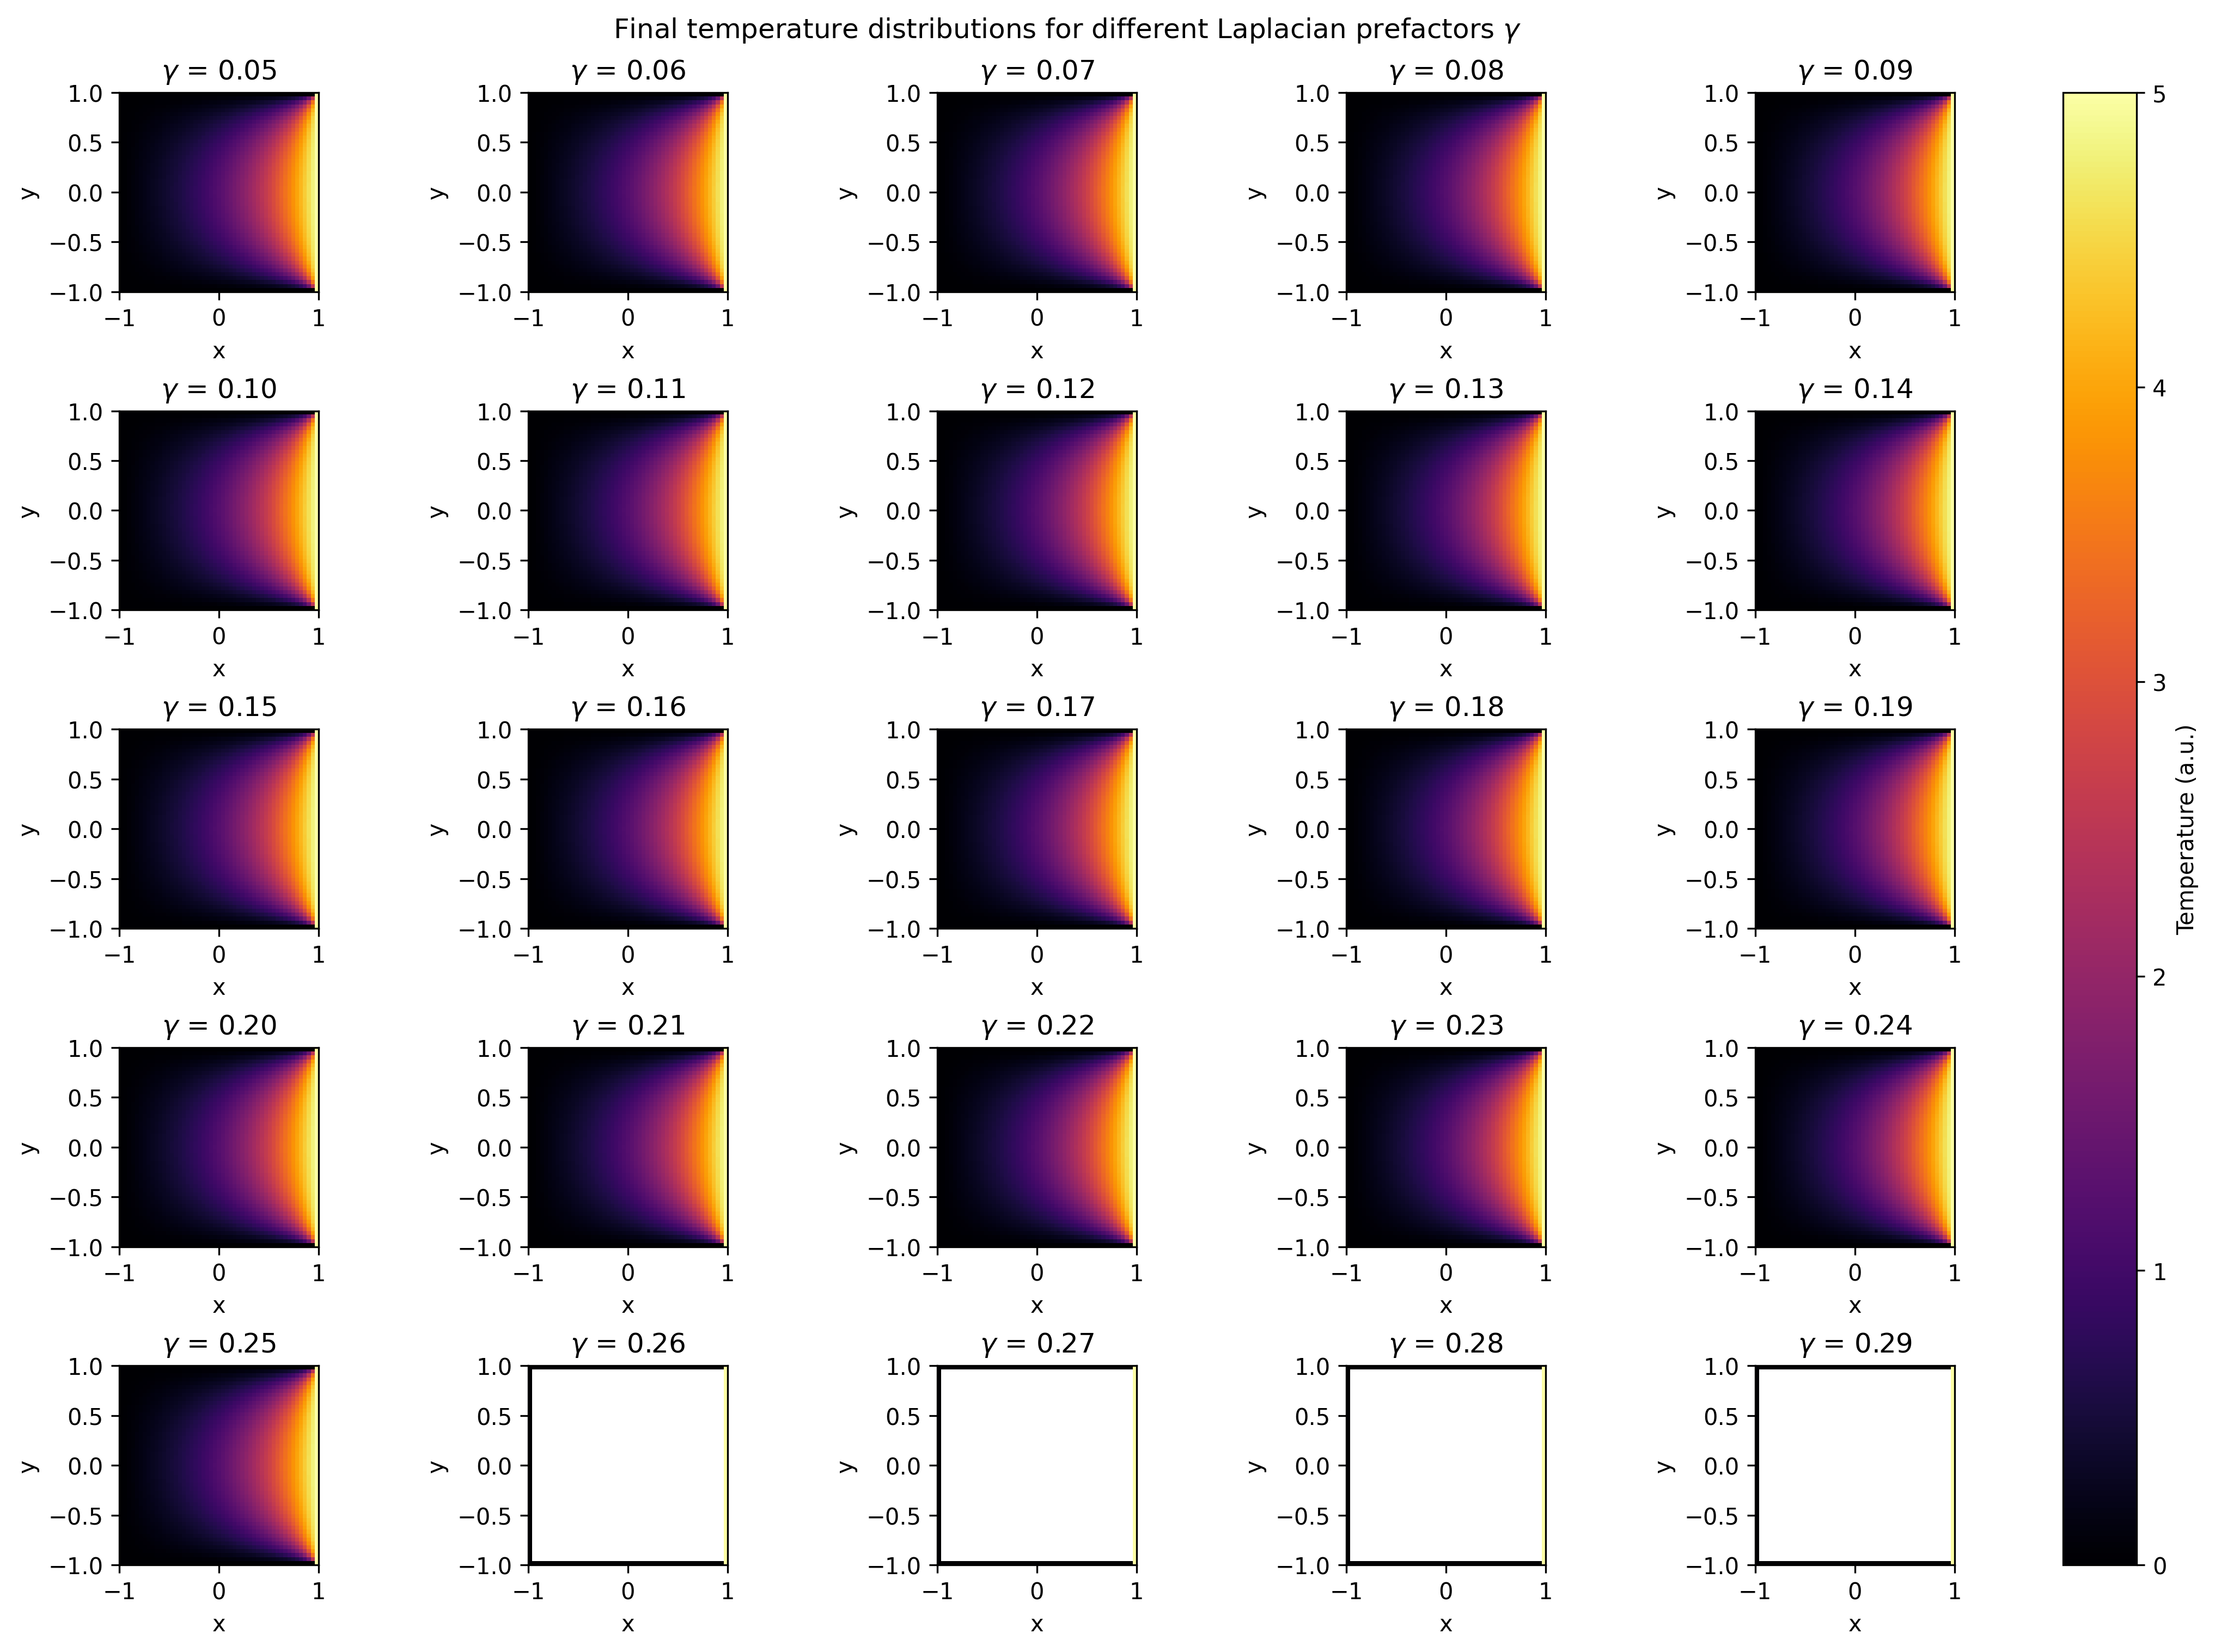

In [6]:
# Create figure, plot all gamma final temp distributions
fig, axes = plt.subplots(5, 5, figsize=(14, 10), constrained_layout=True)

for ax, gamma, field in zip(axes.flat, gammas[:-1], final_distribution[:-1]):
    # Plot colour map
    im = ax.imshow(field, origin="lower", extent=(-1, 1, -1, 1), cmap="inferno", vmin=0.0, vmax=5.0)
    # Label plot
    ax.set_title(f"$\gamma$ = {gamma:.2f}")
    ax.set_xlabel("x"); ax.set_ylabel("y")

# No need for axis in all of them
for ax in axes.flat[len(gammas[:-1]):]:
    ax.axis("off")

# Remove the unused axis
for ax in axes.flat[len(gammas[:-1]):]:
    fig.delaxes(ax)

# Add global plot properties
fig.colorbar(im, ax=axes.ravel().tolist(), label="Temperature (a.u.)")
plt.suptitle("Final temperature distributions for different Laplacian prefactors $\gamma$")

The above plot shows us mostly similar heat distributions for $\gamma \leq 0.25$. However, if we look carefully, we can make out a difference between the $\gamma=0.05$ case which is highly temporally discretised, and the less discretised $\gamma=0.19$ case. As they have propagated to the same final time `t_max=1`, this difference clearly cannot be linked to the more discretised $\gamma$ causing a smaller time. This could instead be a consequence of the two different discretisations leading to different accuracies, which we will investigate in a bit.

Clearly once $\gamma > 0.25$, the heat distribution explodes, giving us meaningless graphs, verifying our earlier statements that $\gamma$ beyond this point gives unphysical results.

### Time efficiency of $\gamma$
Next, let us take a look at the time taken to compute these solutions for each $\gamma$.

Given that a larger $\gamma$ causes $\Delta t$ to be larger as per the relation $\Delta t = \gamma \Delta x^2$, and that $N_{time} = \frac{t_{max}}{\Delta t} = \frac{1}{\Delta t}$ (where $N_{time}$ represents the amount of time steps and $t_{max} = 1$ the maximum time we iterate up to), then

$$\frac{1}{N_{time}} = \gamma \Delta x^2 \rightarrow N_{time} \gamma = \text{const} $$

so we expect there to be an inversely proportional relationship between $\gamma$ and the time taken to solve the heat equation. Or in other words, we expect that a larger $\gamma$ is more computationally efficient.

<>:4: SyntaxWarning: invalid escape sequence '\g'
<>:7: SyntaxWarning: invalid escape sequence '\g'
<>:8: SyntaxWarning: invalid escape sequence '\g'
<>:4: SyntaxWarning: invalid escape sequence '\g'
<>:7: SyntaxWarning: invalid escape sequence '\g'
<>:8: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-271487607.py:4: SyntaxWarning: invalid escape sequence '\g'
  plt.axvline(0.25,color='red',label="$\gamma=0.25$ stability threshold")
/tmp/ipython-input-271487607.py:7: SyntaxWarning: invalid escape sequence '\g'
  plt.title("Time taken to solve 2D heat equation for Laplacian prefactors $\gamma$ \n ($N=51$ grid points)")
/tmp/ipython-input-271487607.py:8: SyntaxWarning: invalid escape sequence '\g'
  plt.xlabel("$\gamma$"); plt.ylabel("Time (s)")


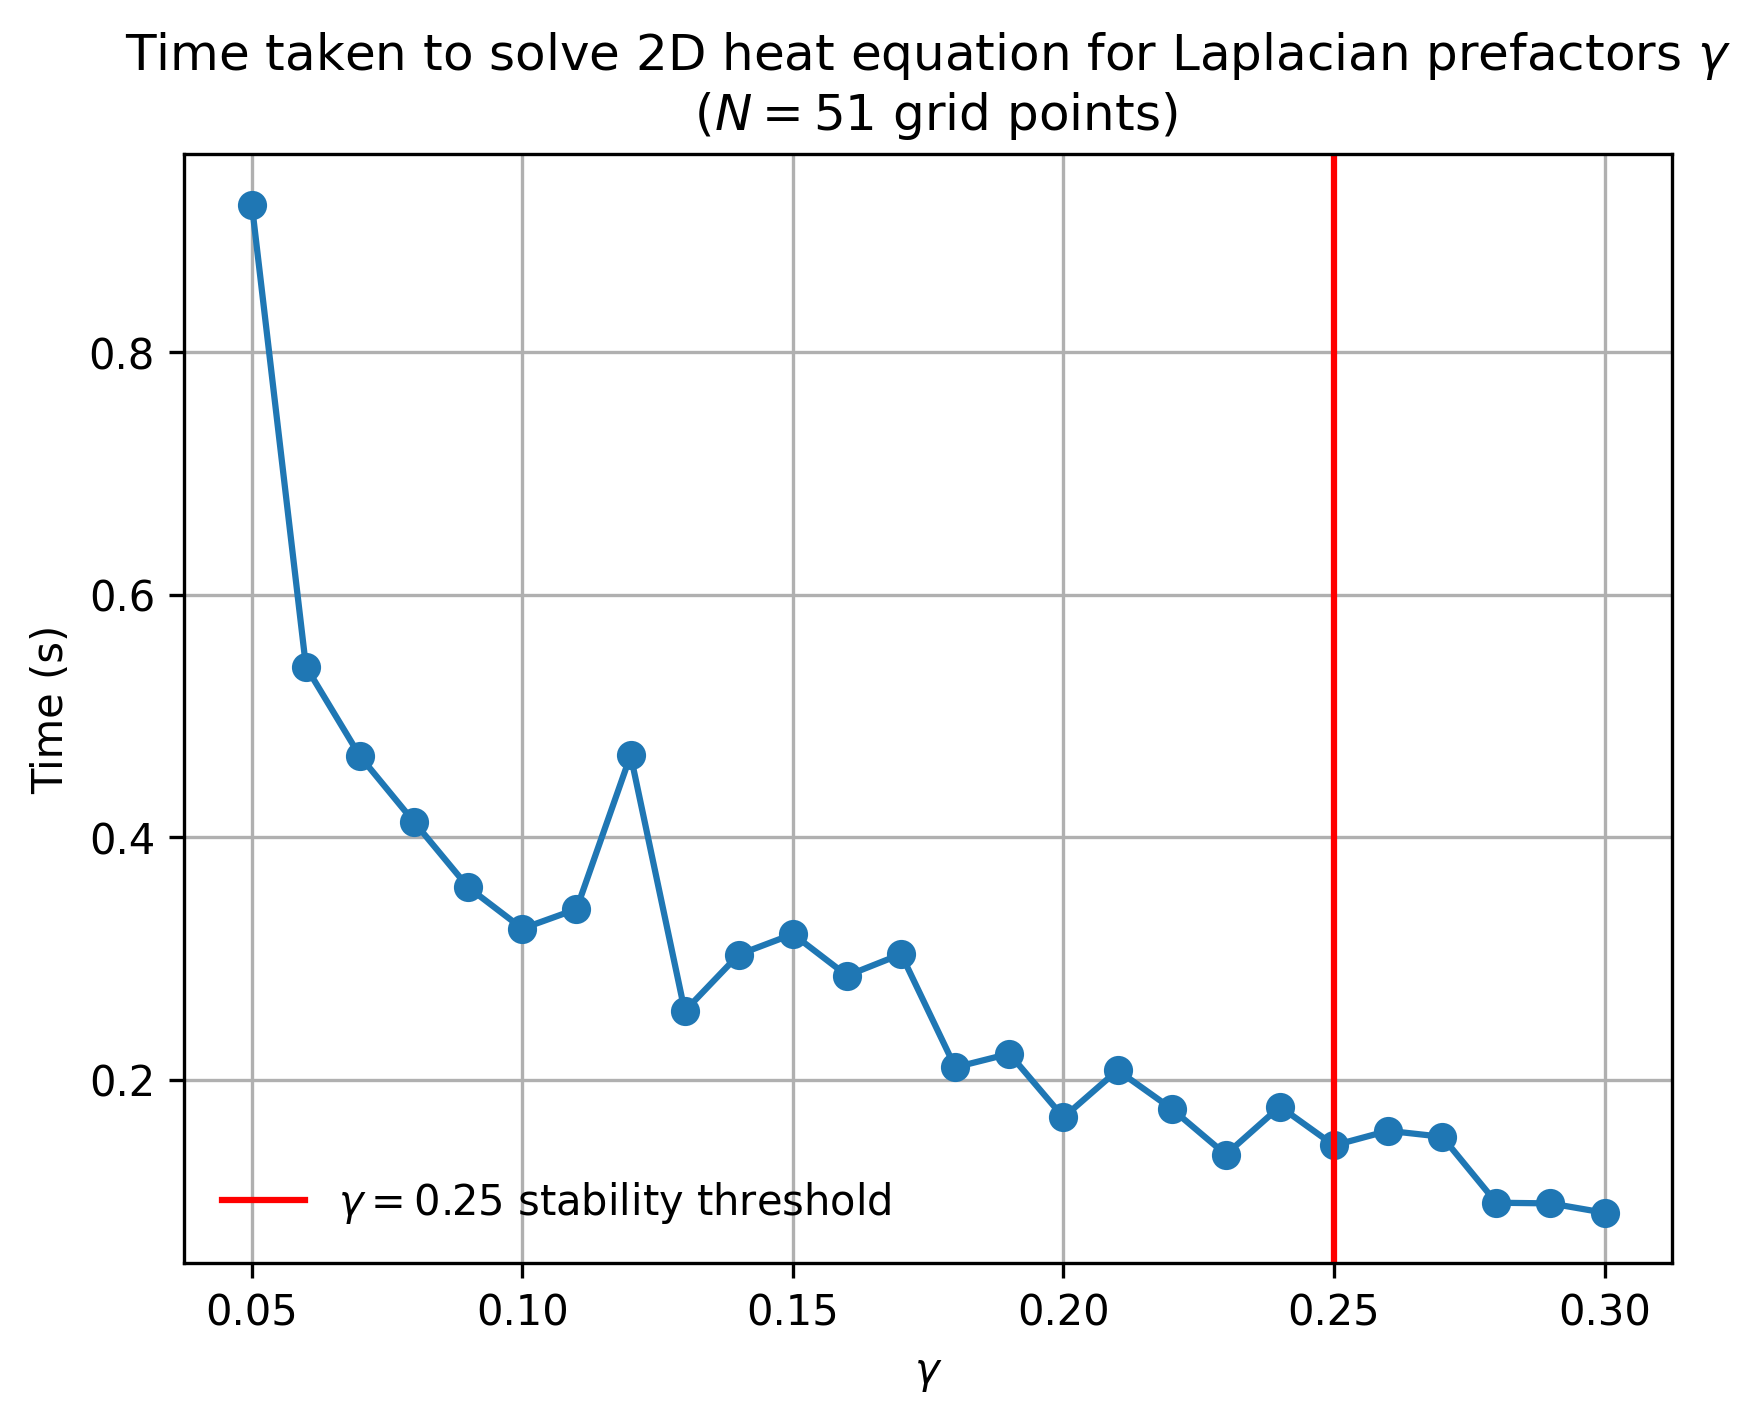

In [7]:
# Plot times taken to solve heat equation for different gamma
plt.plot(gammas,comp_times_gamma,'-o')
# Also highlight the gamma=0.25 stability threshold
plt.axvline(0.25,color='red',label="$\gamma=0.25$ stability threshold")

# Make plot neater
plt.title("Time taken to solve 2D heat equation for Laplacian prefactors $\gamma$ \n ($N=51$ grid points)")
plt.xlabel("$\gamma$"); plt.ylabel("Time (s)")
plt.grid(); plt.legend()


From the above graph we can clearly see that increasing the value of $\gamma$ decreases the time taken to solve the heat equation, following (roughly) the inverse proportionality relation $\gamma \propto \frac{1}{t}$. This is exactly what we hypothesised above, strengthening our earlier identification that $\gamma$ behaves as a temporal discretisation.

### Analysing the $\gamma=0.24$ solution
Now we zoom in onto a specific value of $\gamma$ and analyse its solution. We will plot the final temperature distribution in its full glory, then we will plot 'snapshots' of the temperature distribution throughout time and assess how it varies.

We start off with the final temperature distribution below.

<>:9: SyntaxWarning: invalid escape sequence '\g'
<>:9: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-2408803799.py:9: SyntaxWarning: invalid escape sequence '\g'
  plt.title(f"Final temperature for $\gamma$ = {gamma_stable}")


Text(0, 0.5, 'y')

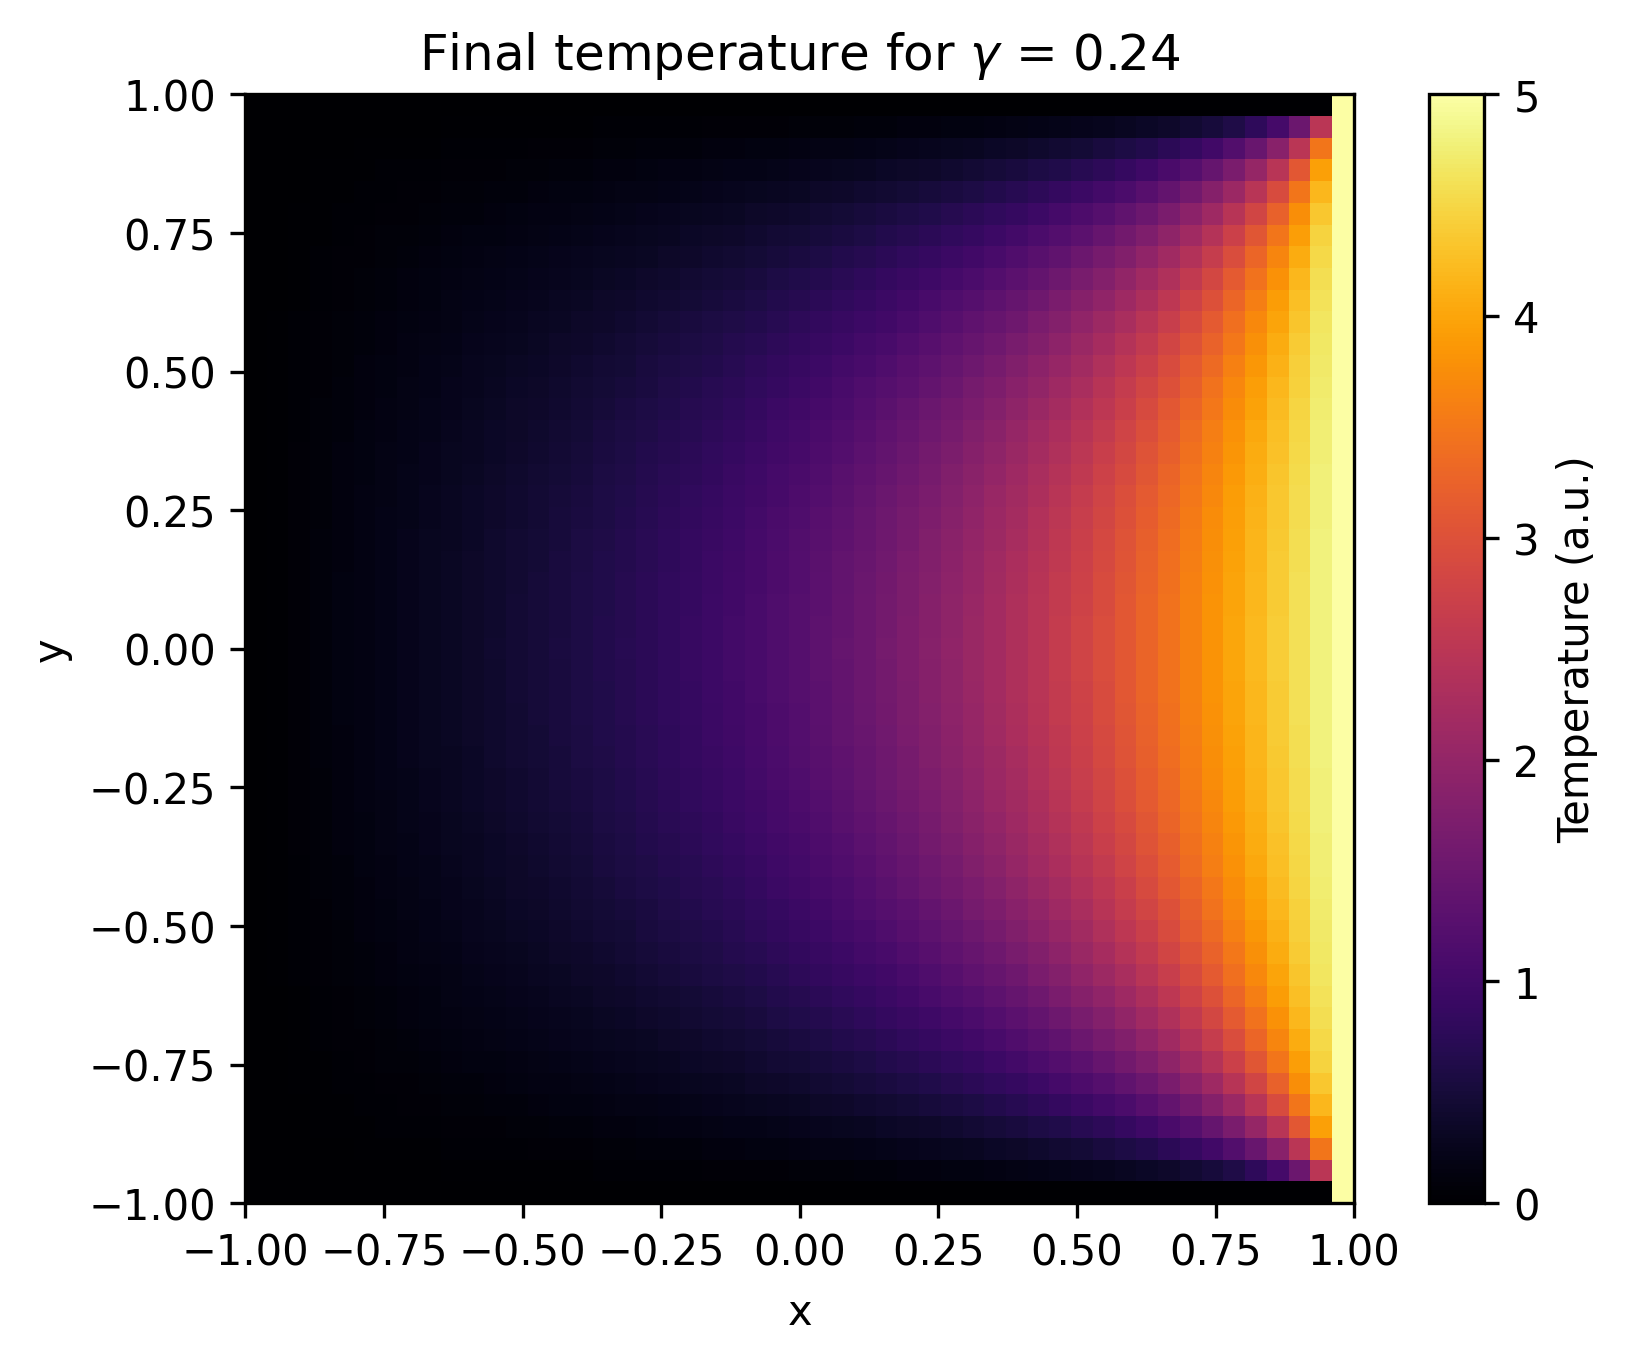

In [8]:
# Define parameters for heat problem and solve it
N = 51; t_max = 5.0; gamma_stable = 0.24
u_stable = explicit_heat_kernel(N, t_max, gamma_stable, dtype=np.float32)

# Plot the final heat distribution
plt.imshow(u_stable[:, :, -1], origin="lower", extent=(-1, 1, -1, 1), cmap="inferno")
# Add colourbar, title, and labels
plt.colorbar(label="Temperature (a.u.)")
plt.title(f"Final temperature for $\gamma$ = {gamma_stable}")
plt.xlabel("x"); plt.ylabel("y")

This above graph suggests that the initial heat applied to the right-hand side of the plate "seeps" its way through it as the time increases. We can see that the Dirichlet boundary conditions are working as intended, due to the other three faces of the plate remaining cold. We can better investigate this heat distribution over time by plotting the "heat" map of this heat distribution for a range of different times, like below.

<>:20: SyntaxWarning: invalid escape sequence '\g'
<>:20: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-3634616050.py:20: SyntaxWarning: invalid escape sequence '\g'
  plt.suptitle("Temperature evolution for $\gamma$ = 0.24")
/tmp/ipython-input-3634616050.py:19: UserWarning: Adding colorbar to a different Figure <Figure size 4200x3000 with 26 Axes> than <Figure size 4200x1800 with 9 Axes> which fig.colorbar is called on.
  fig.colorbar(im, ax=axes.ravel().tolist(), label="Temperature (a.u.)")


Text(0.5, 0.98, 'Temperature evolution for $\\gamma$ = 0.24')

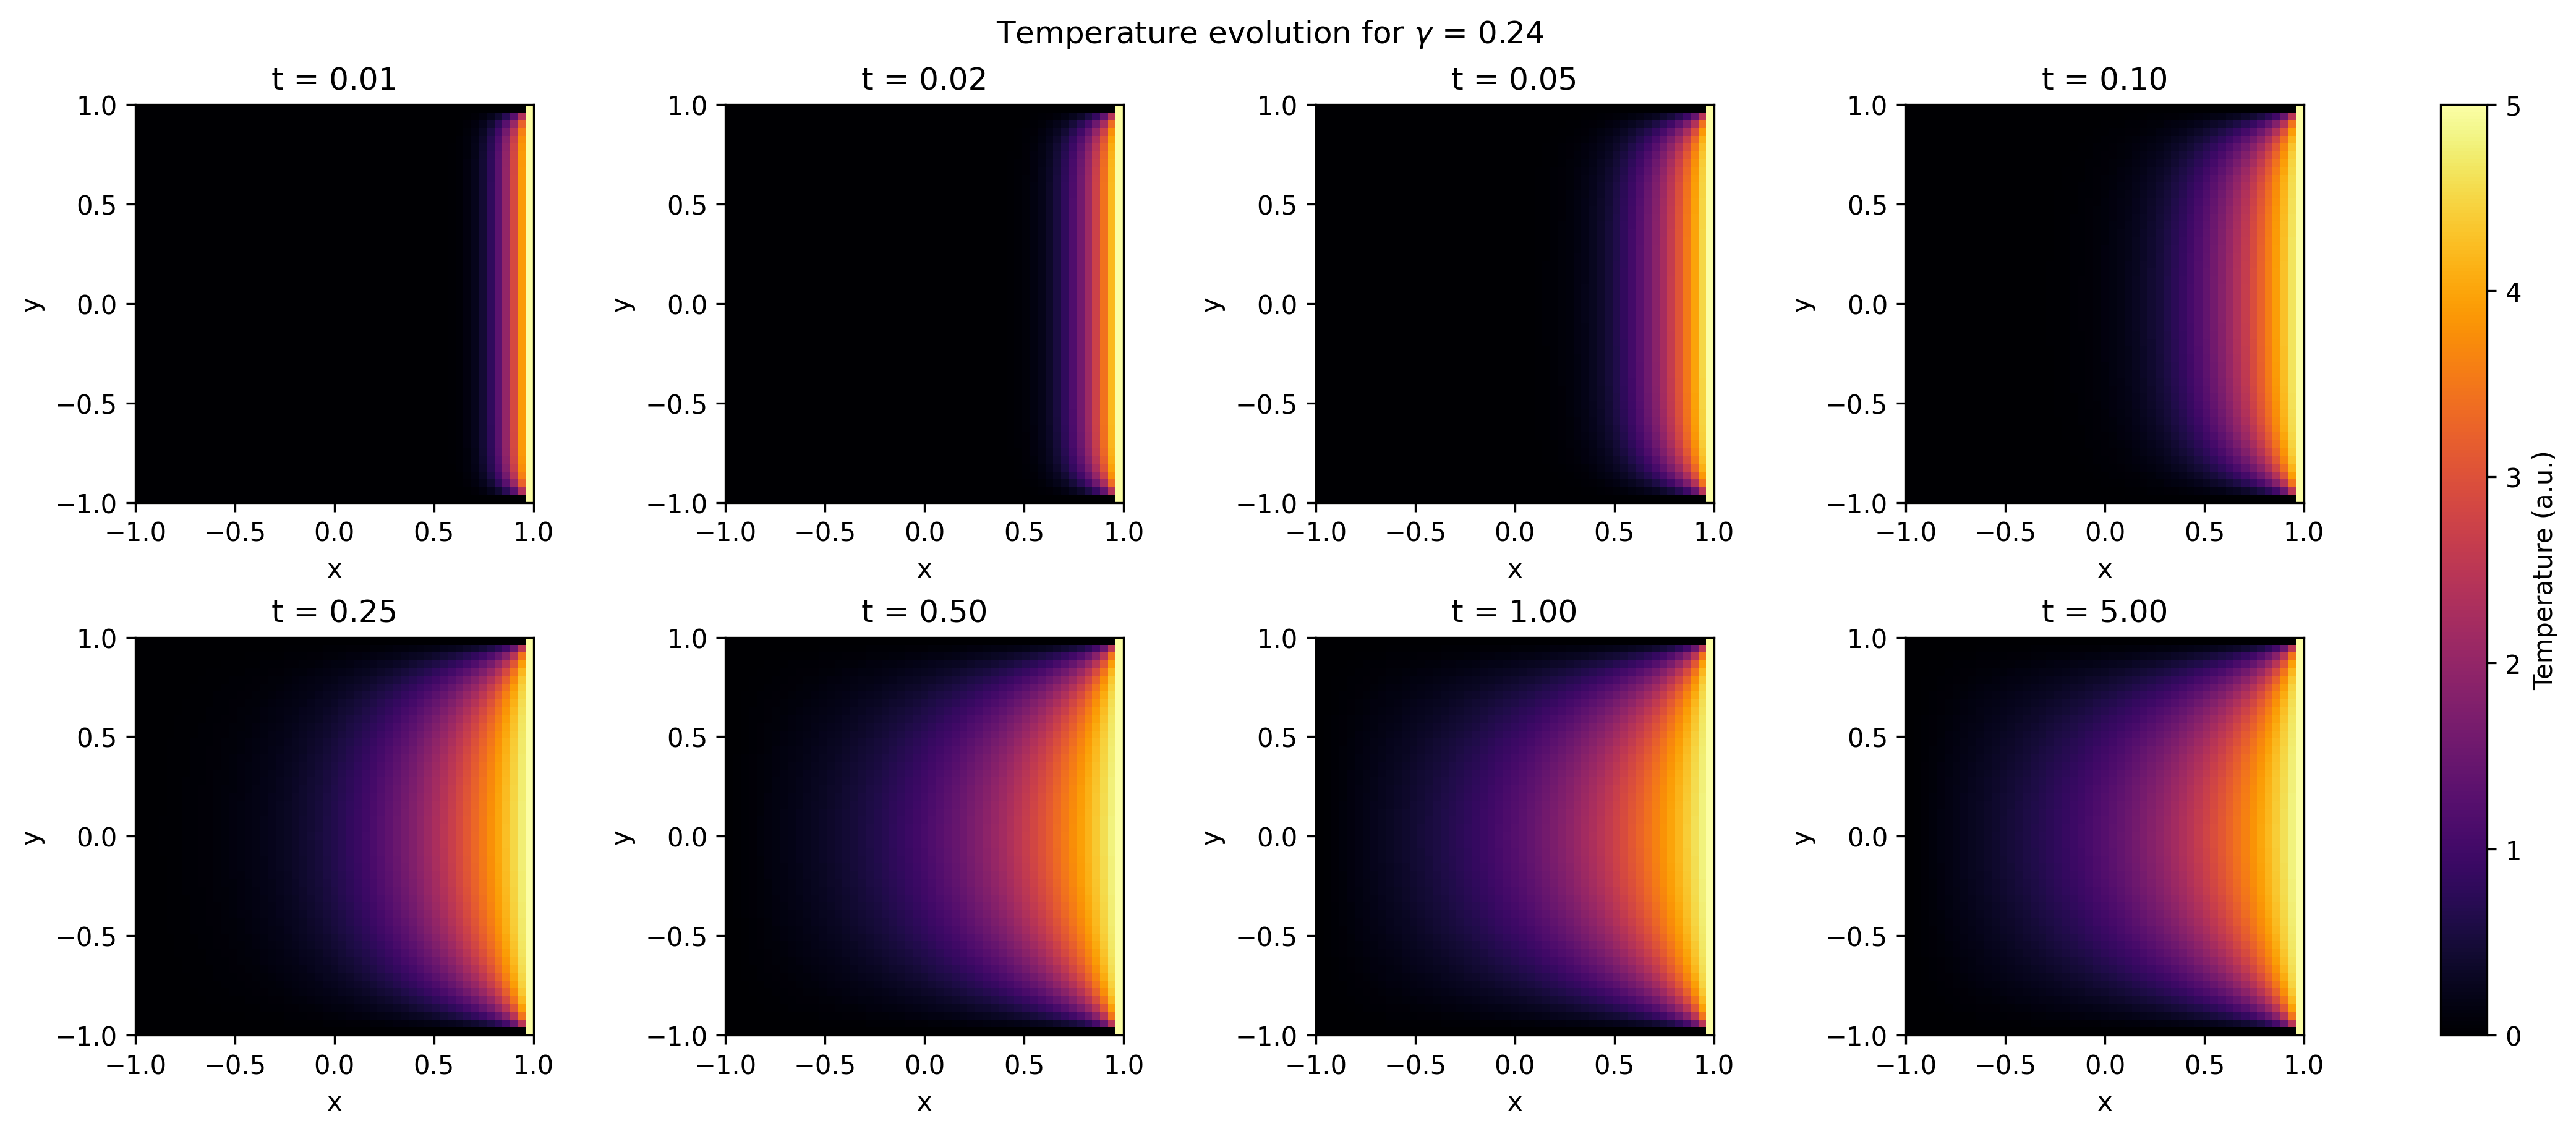

In [9]:
# Create a list of different times to investigate
times_list = [0.01, 0.02, 0.05, 0.10, 0.25, 0.50, 1.00, t_max]
# Also extract the indices of these times
dx = 2.0 / (N - 1)
dt = gamma_stable * dx**2
indices = []
for time in times_list:
    indices.append(min(int(time / dt), u_stable.shape[-1] - 1))

# Create figure and plot for range of times
fig, axes = plt.subplots(2, 4, figsize=(14, 6), constrained_layout=True)
for ax, time, idx in zip(axes.flat, times_list, indices):
    ax.imshow(u_stable[:, :, idx], origin="lower", extent=(-1, 1, -1, 1), cmap="inferno", vmin=0.0, vmax=5.0)
    # Add labels
    ax.set_title(f"t = {time:.2f}")
    ax.set_xlabel("x"); ax.set_ylabel("y")

# Add global plot properties
fig.colorbar(im, ax=axes.ravel().tolist(), label="Temperature (a.u.)")
plt.suptitle("Temperature evolution for $\gamma$ = 0.24")

## Investigating center profile of the plate
From the plot above, we observe that the heat distribution starts off quite rapidly, but that it seems to slow down after some while, indicating that an asymptotic distribution limit may have been reached. To better portray that we have hit a limit, let us consider the temperature of the center of this plate as a function of time.



### Creating new functions to store only the central profile
Previously, we had functions `explicit_heat_kernel` and `explicit_heat_device` which propagated the whole array $u$ in time and spatially to solve the two-dimensional heat equation. In other words, we used the whole array to solve for the whole array and we stored this whole array. But our analysis of $t^*$ only concerns the midpoint of the two-dimensional plate. If we want our $t^*_{obs}$ to more accurately represent $t^*$, we will need to find ways to cut corners and improve the efficiency of our solvers.

The perfect way to do this is by solving only for the central point instead, which we call `center_profile` below.

#### GPU loop function
Again, we will create two functions, one which is exclusively parallelised over the GPU (device), and the other which is operated within the CPU (kernel). The one which concerns the GPU again loops over the spatial components. However, the function is now structured slightly differently to only use the `u_old` and `u_new` components of the $u$ array only.

In [10]:
@cuda.jit
def explicit_heat_device_central(u_old, u_new, gamma, center_profile, step, cx, cy):
  """CUDA kernel to update the temperature for the center point of a grid only, for a single time step.
  I.e. loops over i,j the spatial indices only to compute an update to center_profile.
  Assumes the two-dimensional heat equation, du/dt = Delta t is the equation we are trying to solve.

  Inputs:
  u_old - two-dimensional NumPy vector representing u array at previous timestep
  u_new - two-dimensional NumPy vector representing u array at new timestep
  gamma - prefactor in front of Laplacian in the heat equation update, can be thought of as controlling temporal discretisation
  center_profile - one-dimensional NumPy vector representing the temperature distribution of the center
  step - integer representing the current time step
  cx, cy - integers representing the indices of the center of the plate"""
  # Create cuda grid and extract array size
  i, j = cuda.grid(2)
  img_size_x, img_size_y = u_old.shape

  # Guard for out-of-bounds threads
  if i >= img_size_x or j >= img_size_y:
    return

  # Impose Dirichlet boundary conditions
  if i == 0 or i == img_size_x - 1 or j == 0 or j == img_size_y - 1:
    if j == img_size_y - 1:
      u_new[i, j] = 5.0
    else:
      u_new[i, j] = 0.0
  else:
    # Interior point update
    L = (u_old[i+1, j] + u_old[i-1, j] + u_old[i, j+1] + u_old[i, j-1] - 4.0 * u_old[i, j])
    u_new[i, j] = u_old[i, j] + gamma * L
  # One special thread records the centre temperature at this step
  if i == cx and j == cy:
    # Store center profile at new time step
    center_profile[step + 1] = u_new[i, j]

#### CPU loop function
Much like in our previous implementation, we now have a seperate function which is exclusive to the kernel, and this function loops over the time steps to give us a full answer for the solution to the heat equation.

Now, the difference here is that we store and return `center_profile` instead of the full array $u$. This `center_profile` will be a one-dimensional array only, instead of the three-dimensional $u$ array, which will give us a massive efficiency boost. Other than this, the function works in basically the same way.

In [11]:
def explicit_heat_kernel_central(N, t_max, gamma, dtype):
  """Solves the two-dimensional heat equation du/dt = Delta u via GPU parallelisation, using Numba CUDA.
  Contains the kernel function explicit_heat_device inside, which is repeatedly looped over time.
  However, it only stores and returns the central temperature distribution.

  Inputs:
  N - number of gridpoints along one dimension, the spatial discretisation
  t_max - maximum time we wish to iterate the heat equation up to
  gamma - prefactor in front of Laplacian in the heat equation update, can be thought of as controlling temporal discretisation
  dtype - the type we initialise our array with.

  Outputs:
  center_profile - one-dimensional array, storing the temperature only as a function of time, for the central point."""
  # The length of our problem is 2 in either dimension, as the plate spans -1 < x,y < 1
  length = 2.0
  # Calculate dx and dt according to gamma
  dx = length / (N - 1)
  dt = gamma * dx**2
  # Find total number of time steps
  time_steps = int(np.ceil(t_max / dt))

  # Set up storage for u0, the initial array
  u0 = np.zeros((N, N), dtype=dtype)
  # Initialise Dirichlet boundary conditions
  u0[:, 0] = 0.0
  u0[0, :] = 0.0
  u0[-1, :] = 0.0
  u0[:, -1] = 5.0

  # Define center indices
  cx = N // 2; cy = N // 2

  # Also copy the array from
  u_old_gpu = cuda.to_device(u0)
  u_new_gpu = cuda.device_array_like(u_old_gpu)

  # Centre temperature history: host + device
  center_profile = np.zeros(time_steps + 1, dtype=dtype)
  center_profile[0] = u0[cx, cy]
  center_profile_gpu = cuda.to_device(center_profile)

  # CUDA grid/block configuration
  blockdim_x, blockdim_y = 16, 16
  blockdim = (blockdim_x, blockdim_y)
  griddim_x = int(np.ceil(N / blockdim_x)); griddim_y = int(np.ceil(N / blockdim_y))
  griddim = (griddim_x, griddim_y)

  # Iterate forward in time, taking u_new = u_old at the end of each iteration
  for n in range(time_steps):
    explicit_heat_device_central[griddim, blockdim](u_old_gpu, u_new_gpu, gamma, center_profile_gpu, n, cx, cy)
    u_old_gpu, u_new_gpu = u_new_gpu, u_old_gpu

  # Synchronize all threads and retrieve final array from GPU
  cuda.synchronize()
  center_profile_gpu.copy_to_host(center_profile)

  return center_profile

#### Function for computing $t^*_{obs}$
To faciltate this central point analysis, we will create a function called `central_heat_profile`, which will solve the heat equation using a given method `method`. We will be using three different methods so keeping this method arbitrary within this function is important. This function we create will supply us with the central point temperature as a function of time, in addition to other analytics which we will need later on.

In [12]:
def central_heat_profile(N, t_max, gamma, dtype):
  """Solves the heat equation for a given spatial and temporal discretisation, using a given method.
    Analyses the heat at the center of the profile and extracts the first time for which the temperature
    of the midpoint of the profile exceeds 20% of that given by the initial conditions. Also analyses
    the time evolution of this temperature.

  Inputs:
    N - spatial discretisation, gridpoints
    t_max - maximum time of iteration
    gamma - temporal discretisation, prefactor infront of Laplacian
    dtype - the type we initialise our array with.


  Outputs:
    center_profile - temperature of the center point of the profile as a function of time
    t_array - time array for the specific value of gamma and N input
    t_star_obs - observed time for which the temperature of midpoint exceeds 20% of the initial boundary conditions"""
  # Solve for central heat distribution
  center_profile = explicit_heat_kernel_central(N, t_max, gamma, dtype)

  # Find t_array for this specific gamma
  dx = 2.0 / (N - 1)
  dt = gamma * dx**2
  time_steps = int(np.ceil(t_max/dt))
  t_array = np.arange(time_steps + 1) * dt

  # Find arguments of u array for which center temp exceeds 1
  crossing = np.where(center_profile >= 1.0)[0]
  # Convert arguments to time and add to tstar list
  if not crossing.size:
    t_star_obs = np.nan
  else:
    k = crossing[0]
    if k == 0:
      t_star_obs = 0.0
    else:
      y0, y1 = center_profile[k-1], center_profile[k]
      t0, t1 = (k-1)*dt, k*dt
      frac = (1.0 - y0) / (y1 - y0) if y1 != y0 else 0.0
      t_star_obs = t0 + frac * (t1 - t0)

  return center_profile, t_array, t_star_obs

Having created the function, we can easily use it to gather the central heat profile given some initial parameters. We will continue investigating $\gamma=0.24$, the parameter we had earlier, and also $\gamma=0.27$ which is above the critical $0.25$.

In [13]:
# Solve for central profile given gamma=0.24
N = 51; t_max = 5.0; gamma_stable = 0.24
u_stable, t_stable, tstar_stable = central_heat_profile(N, t_max, gamma_stable, dtype=np.float32)

# Solve for central profile given gamma=0.27
N = 51; t_max = 0.06; gamma_unstable = 0.27
u_unstable, t_unstable, tstar_unstable = central_heat_profile(N, t_max, gamma_unstable, dtype=np.float32)

/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 16 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


We will plot the central temperature of this plate as a function of time for both instances of $\gamma$ we just looked at.

<>:6: SyntaxWarning: invalid escape sequence '\g'
<>:9: SyntaxWarning: invalid escape sequence '\g'
<>:17: SyntaxWarning: invalid escape sequence '\g'
<>:6: SyntaxWarning: invalid escape sequence '\g'
<>:9: SyntaxWarning: invalid escape sequence '\g'
<>:17: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-4126214795.py:6: SyntaxWarning: invalid escape sequence '\g'
  axes[0].set_title(f"Stable $\gamma={gamma_stable}$")
/tmp/ipython-input-4126214795.py:9: SyntaxWarning: invalid escape sequence '\g'
  axes[1].set_title(f"Unstable $\gamma={gamma_unstable}$")
/tmp/ipython-input-4126214795.py:17: SyntaxWarning: invalid escape sequence '\g'
  plt.suptitle("Centre point temperature over time for stable and unstable $\gamma$")


Text(0.5, 0.98, 'Centre point temperature over time for stable and unstable $\\gamma$')

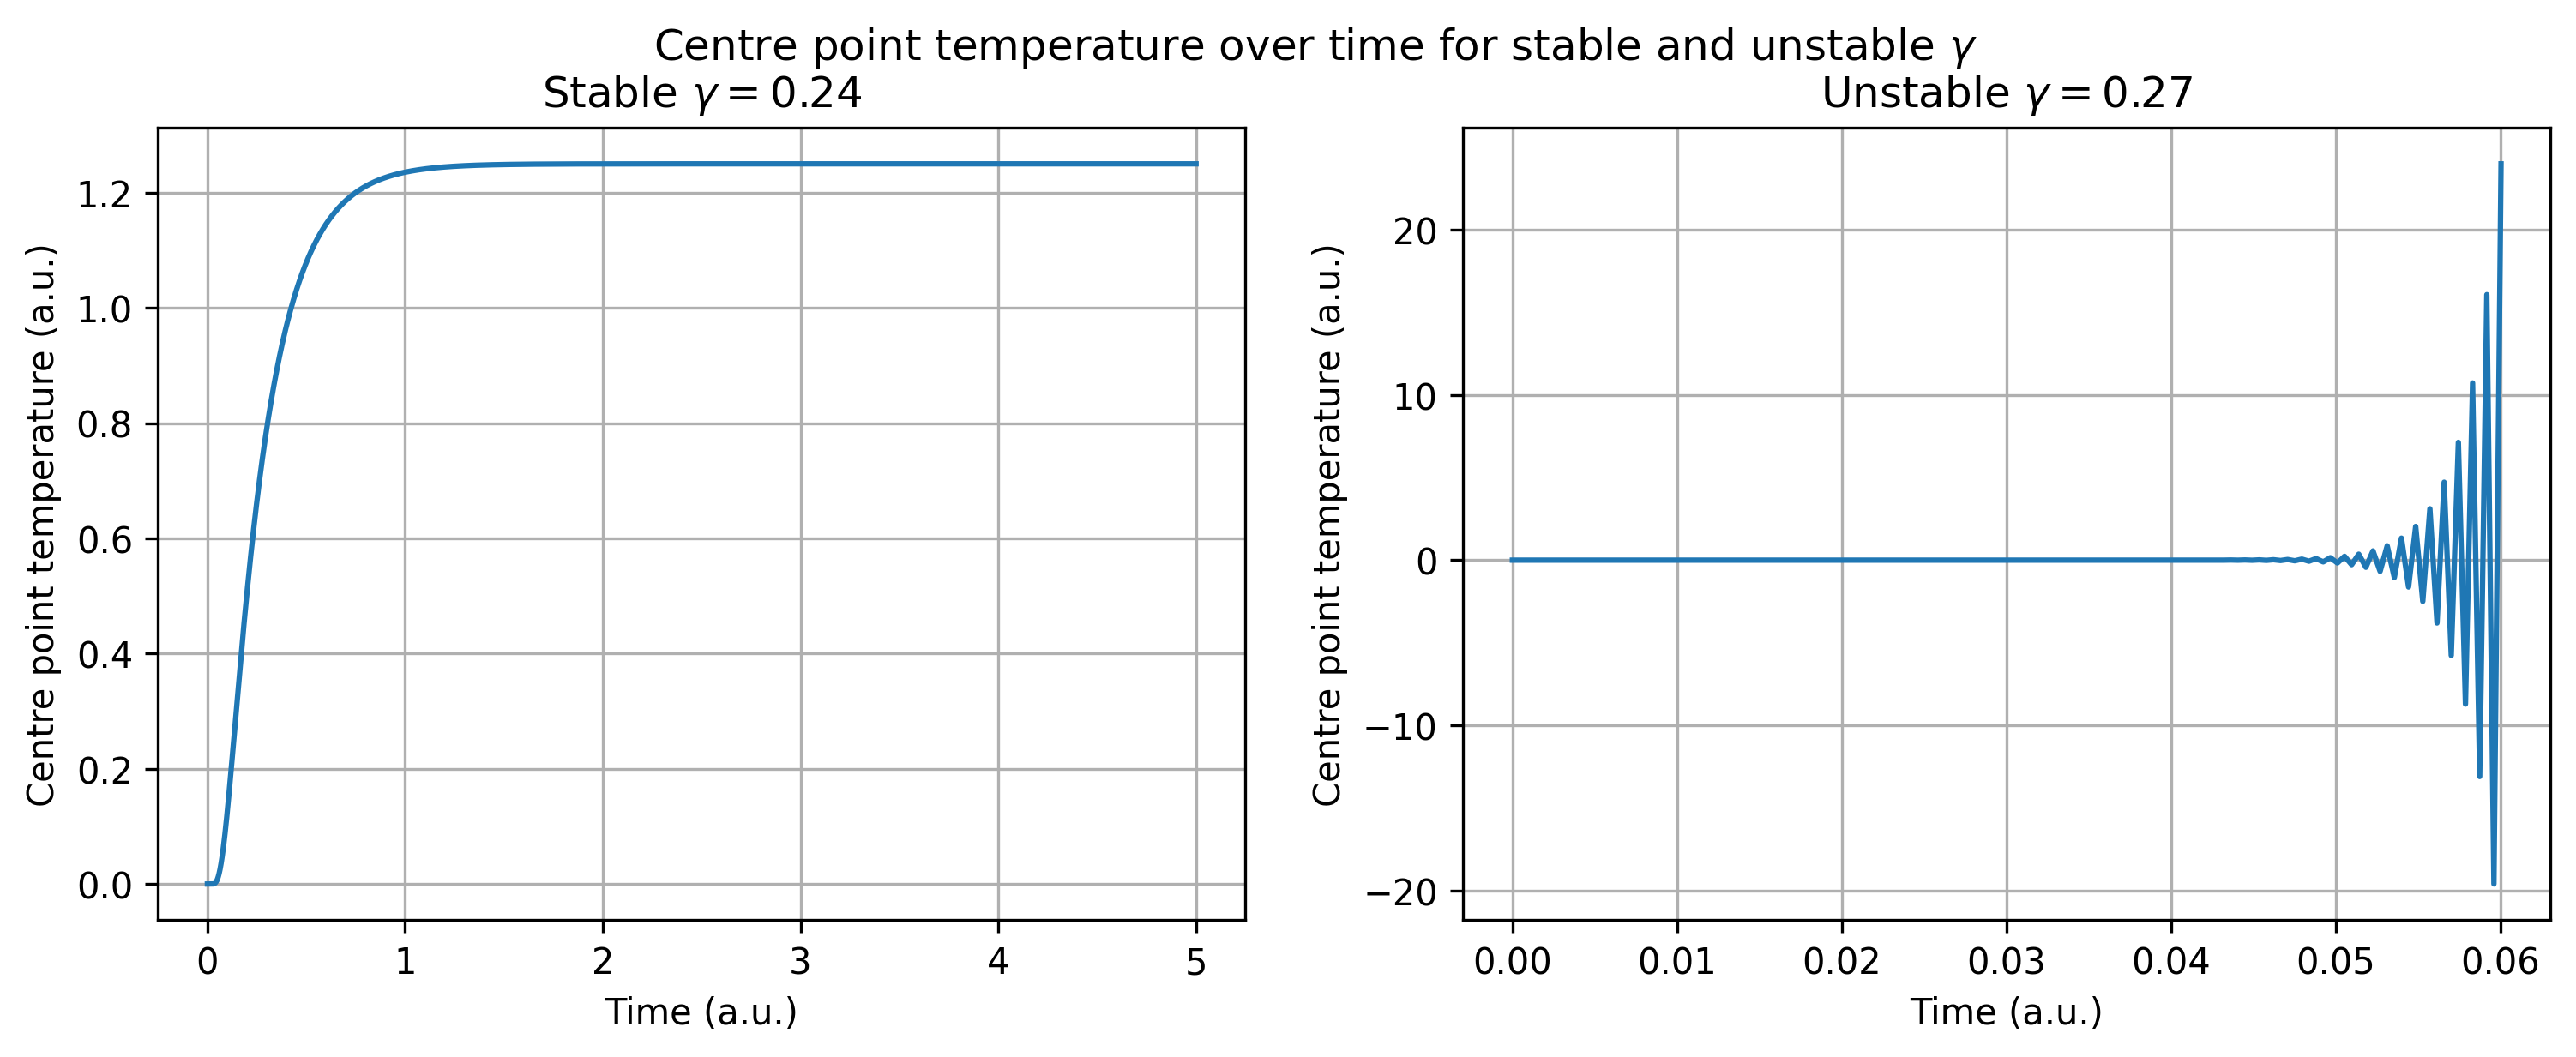

In [14]:
# Create figure for plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot stable soln
axes[0].plot(t_stable, u_stable)
axes[0].set_title(f"Stable $\gamma={gamma_stable}$")
# Plot unstable soln
axes[1].plot(t_unstable, u_unstable)
axes[1].set_title(f"Unstable $\gamma={gamma_unstable}$")

# Make plot neater
for ax in axes:
    ax.set_xlabel("Time (a.u.)"); ax.set_ylabel("Centre point temperature (a.u.)")
    ax.grid()

# Supertitle
plt.suptitle("Centre point temperature over time for stable and unstable $\gamma$")

For $\gamma=0.24$, the left-hand side plot above clearly demonstrates the convergence of the heat distribution as we propagate forward in time. The temperature of the center point seems to level off at about $1.25$ a.u. This exhibited convergence is a hallmark of the stability of our solutions and this represents a unique steady-state solution. In phase-space portraits, we can say that the trajectories converge to the point defined by this infinite-time temperature limit. This is simply due to the value of $\gamma$ which we used in our solution.

Instead when $\gamma=0.27$, we observe that just for time up to $0.06$ the temperature explodes in an oscillatory fashion, producing the unstable graph above. The temperature is already a magnitude of order higher in both directions than in the stable $0.24$ case, once again portraying the instability of this solution.

Clearly changing the value of $\gamma$ has caused a change in the stability of a solution, and this occurs at $\gamma = 0.25$. Hence we say that a bifurcation occurs at this point, taking the solution of the system from stable to unstable. The solution to the system is of the form $\exp{\lambda t}$, where $\lambda$ are the eigenvalues of the Jacobian describing the heat equation in matrix form. These eigenvalues are negative for $\gamma \leq 0.25$, so we have stable solutions. For $\gamma > 0.25$, the eigenvalues are positive and so the solution is expected to exponentially blow up as per the form $\exp{\lambda t}$. This is exactly what the graph above portrays.

### What time does the center of the plate hit a temperature $u=1$?
Now, we will focus on a different question: At which time does the temperature of the center of this plate exceed $1$ a.u.? From the plot above, for $\gamma=0.24$, we anticipate that this would be somewhere around $0.4$ arbitrary units of time. We will now note here that to twelve digits, we expect this time, denoted $t^*$, to be $t^* = 0.424011387033$ arbitrary units.

In [15]:
t_star_true = 0.424011387033
print(f"Gamma = {gamma_stable}: Time at which the center of the plate first exceeds u=1: {tstar_stable} (a.u.)")
print(f"Gamma = {gamma_unstable}: Time at which the center of the plate first exceeds u=1: {tstar_unstable} (a.u.)")

Gamma = 0.24: Time at which the center of the plate first exceeds u=1: 0.42361638670921326 (a.u.)
Gamma = 0.27: Time at which the center of the plate first exceeds u=1: 0.05393977482032777 (a.u.)


For $\gamma = 0.24$ and $N=51$ grid steps we observe that $t^*_{obs} \approx 0.423616$, so it is in agreement with the actual value of $t^*$ up to two significant figures, with deviations starting from the $1e-3$ term.

Unsurprisingly, for the unstable $\gamma = 0.27$ case we instead observe $t^*_{obs} \approx 0.054$, so none of the digits agree.

 Now let us consider the value of $t^*$ for other values of $\gamma$, having previously reasoned that a smaller $\gamma$ should lead to more accurate answers.

In [16]:
# Define parameters
N = 51; t_max = 5.0
# Create a tstar list
t_star_explicit = []
# Also define range of gamma which we want to investigate
gammas = np.insert(np.arange(0.01, 0.26, 0.01), 0, np.array([0.002, 0.003, 0.005, 0.008]))

# For each value of gamma, solve the heat eqn and find the time for which u[center] > 1
for gamma in tqdm(gammas):
    _, _, t_star_obs = central_heat_profile(N, t_max, gamma, dtype=np.float32)
    t_star_explicit.append(t_star_obs)

100%|██████████| 29/29 [04:53<00:00, 10.14s/it]


Below we will actually perform our analysis over this $\gamma$ range by considering the deviation of $t^*_{obs}$ from $t*$. Additionally we do not consider those $\gamma > 0.25$ as we have shown many times now that these give unphysical solutions which are too erroneous.

<>:6: SyntaxWarning: invalid escape sequence '\g'
<>:14: SyntaxWarning: invalid escape sequence '\g'
<>:18: SyntaxWarning: invalid escape sequence '\g'
<>:6: SyntaxWarning: invalid escape sequence '\g'
<>:14: SyntaxWarning: invalid escape sequence '\g'
<>:18: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-1435687873.py:6: SyntaxWarning: invalid escape sequence '\g'
  axes[0].set_xlabel("Laplacian prefactor $\gamma$"); axes[0].set_ylabel("$t^*$ plots")
/tmp/ipython-input-1435687873.py:14: SyntaxWarning: invalid escape sequence '\g'
  axes[1].set_xlabel("Laplacian prefactor $\gamma$"); axes[1].set_ylabel("$|t^* - t^*_{obs}|$")
/tmp/ipython-input-1435687873.py:18: SyntaxWarning: invalid escape sequence '\g'
  plt.suptitle("Behaviour of $t^*_{obs}$ and $t^*$ as temporal discretisation $\gamma$ is changed")


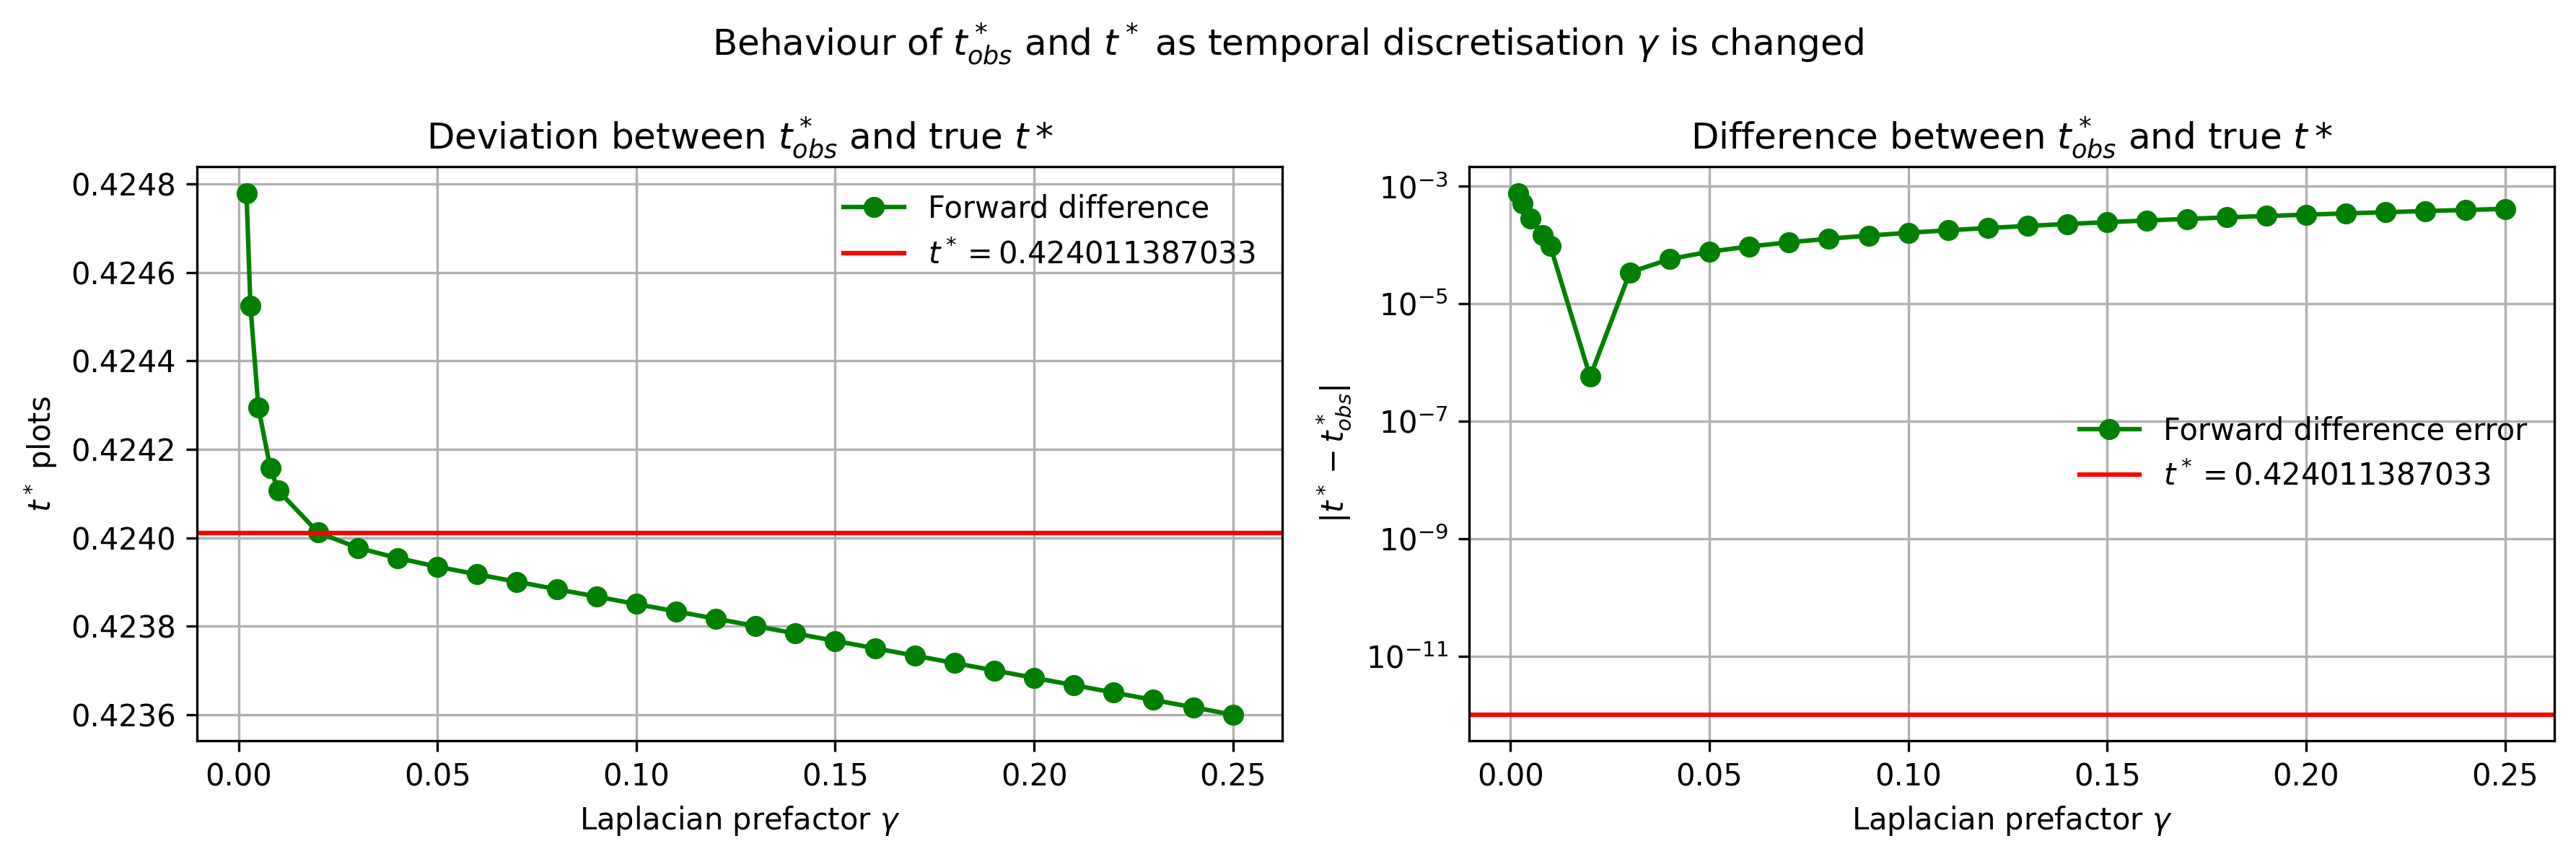

In [17]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12, 4))

# Plot deviation between t star true and t_star_obs
axes[0].plot(gammas,t_star_explicit,'-o',color='green', label="Forward difference")
axes[0].axhline(t_star_true, color='red', label=f"$t^* = {t_star_true}$")
axes[0].set_xlabel("Laplacian prefactor $\gamma$"); axes[0].set_ylabel("$t^*$ plots")
axes[0].set_title("Deviation between $t^*_{obs}$ and true $t*$")
axes[0].legend(); axes[0].grid()

# Also plot the difference between them as a log scale
t_star_errors = np.abs(t_star_explicit - np.ones(len(t_star_explicit))*t_star_true)
axes[1].plot(gammas,t_star_errors, '-o', color='green', label="Forward difference error")
axes[1].axhline(1e-12, color='red', label=f"$t^* = {t_star_true}$")
axes[1].set_xlabel("Laplacian prefactor $\gamma$"); axes[1].set_ylabel("$|t^* - t^*_{obs}|$")
axes[1].set_title("Difference between $t^*_{obs}$ and true $t*$")
axes[1].set_yscale("log"); axes[1].legend(); axes[1].grid()

plt.suptitle("Behaviour of $t^*_{obs}$ and $t^*$ as temporal discretisation $\gamma$ is changed")
plt.tight_layout()

The above plot of this deviation as a function of $\gamma$ shows a clear average increase in this deviation as $\gamma$ increases. This is exactly in line with what we suggested earlier that a smaller $\gamma$ should yield more accurate results. Thus we anticipate that a very small $\gamma$, maybe around $0.01$, could provide excellent agreement with the true value of $t^*$. We also observe here that this increase is linear, suggesting that this error is of order $(\Delta t)^1$.

This linearity is obeyed up until a $\gamma \approx 0.02$, which was unexpected. At this point $t^*_{obs}$ becomes overestimated rather than underestimated (reading the graph from right to left), suggesting that there is a certain value of $\gamma$ for which $t^*_{obs}$ exactly matches $t^*$. However, we should remember that we are using `float32` precision here. We should verify that this result also appears in `float64` before investigating it further.

#### Assessment of `float64` precision
We will do the same analysis as last time, keeping all parameters the same for a fair comparison.

In [18]:
# Define parameters
N = 51; t_max = 5.0
# Create a tstar list
t_star_explicit = []
gammas = np.insert(np.arange(0.01, 0.26, 0.01), 0, np.array([0.002, 0.003, 0.005, 0.008]))

# For each value of gamma, solve the heat eqn and find the time for which u[center] > 1
for gamma in tqdm(gammas):
    _, _, t_star_obs = central_heat_profile(N, t_max, gamma, dtype=np.float64)
    t_star_explicit.append(t_star_obs)

100%|██████████| 29/29 [04:44<00:00,  9.81s/it]


<>:6: SyntaxWarning: invalid escape sequence '\g'
<>:13: SyntaxWarning: invalid escape sequence '\g'
<>:6: SyntaxWarning: invalid escape sequence '\g'
<>:13: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-141733820.py:6: SyntaxWarning: invalid escape sequence '\g'
  axes[0].set_xlabel("Laplacian prefactor $\gamma$"); axes[0].set_ylabel("$t^*$ plots")
/tmp/ipython-input-141733820.py:13: SyntaxWarning: invalid escape sequence '\g'
  axes[1].set_xlabel("Laplacian prefactor $\gamma$"); axes[1].set_ylabel("$t^*$ plots")


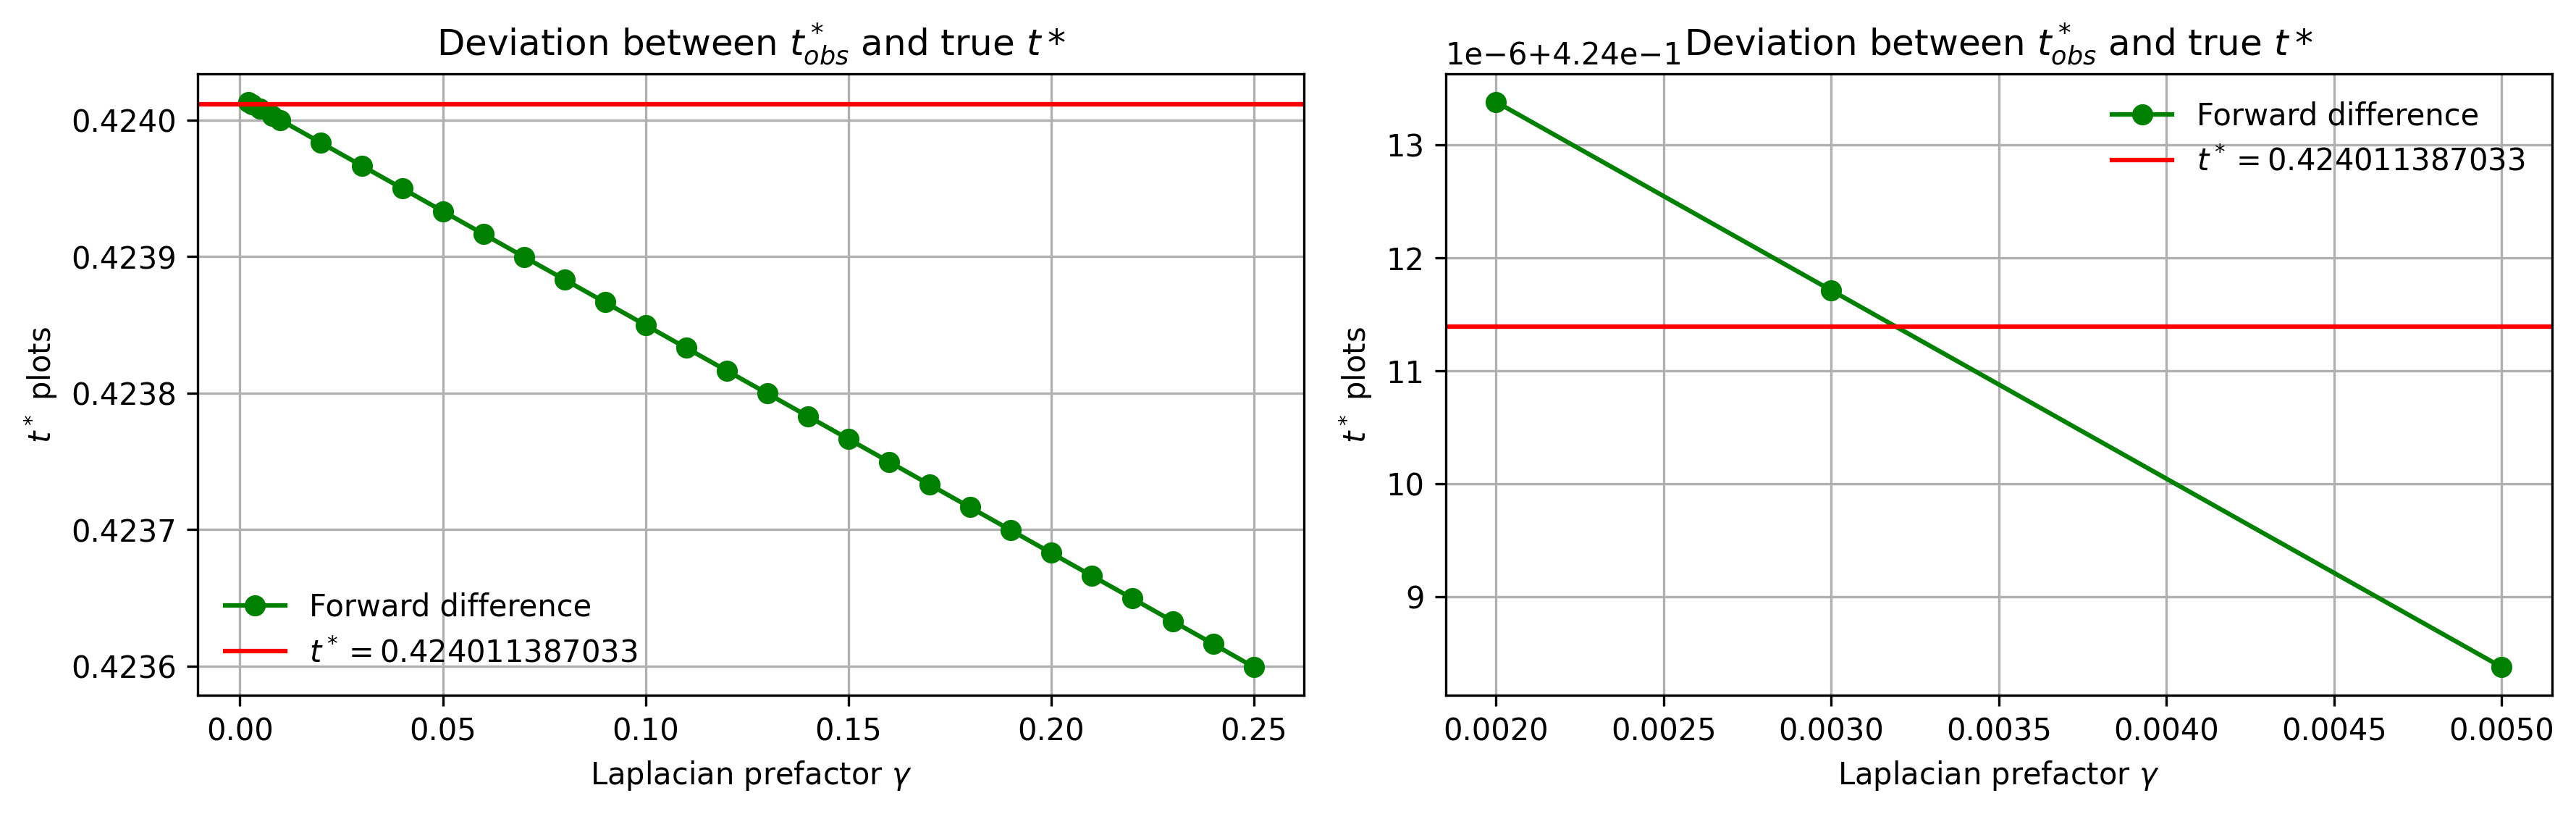

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot deviation between t star true and t_star_obs
axes[0].plot(gammas,t_star_explicit,'-o',color='green', label="Forward difference")
axes[0].axhline(t_star_true, color='red', label=f"$t^* = {t_star_true}$")
axes[0].set_xlabel("Laplacian prefactor $\gamma$"); axes[0].set_ylabel("$t^*$ plots")
axes[0].set_title("Deviation between $t^*_{obs}$ and true $t*$")
axes[0].legend(); axes[0].grid()

# Also plot the difference between them as a log scale
axes[1].plot(gammas[:3],t_star_explicit[:3],'-o',color='green', label="Forward difference")
axes[1].axhline(t_star_true, color='red', label=f"$t^* = {t_star_true}$")
axes[1].set_xlabel("Laplacian prefactor $\gamma$"); axes[1].set_ylabel("$t^*$ plots")
axes[1].set_title("Deviation between $t^*_{obs}$ and true $t*$")
axes[1].legend(); axes[1].grid()

plt.tight_layout()

From the above graph, we see the same weird result from `float64` precision: there is an intercept between the $t^*_{obs}$ line and the true $t^*$, suggesting that there is a value of $\gamma$ which gives us a very accurate estimate of $t^*_{obs}$. But is this $\gamma$ actually a 'magic' parameter which gives us almost the true solution to the heat equation over the whole plate, or does it just give the true solution to the heat distribution at the centre?

Unfortunately, the function which computes the full array for this, `explicit_heat_kernel`, will crash the T4 GPU kernel for $\gamma < 0.007$ and so we cannot verify whether $\gamma \approx 0.0032$ is actually the best value for $\gamma$ that we can use. There is a significant chance that this super-accurate $t^*$ estimate could simply be a lucky coincidence from cancellation of errors.

But, we should remember that the accuracy of $t^*_{obs}$ is not limited to just changing $\gamma$ only. If we want agreement with $t^*$ to a very good number of digits, minimising $\gamma$ alone is not enough; we will also need to investigate the spatial discretisation of this problem, which is given by $N$.

## Investigating varying $N$ the spatial discretisation
In the following analysis of $N$, we will use $\gamma=0.24$, simply for its computational efficiency. We will assess the time efficiency and the error between $t^*_{obs}$ and $t^*$ as a function of $N$.

Below we compute $t^*_{obs}$ using `float64` precision, whilst the time efficiency is found using `float32` precision. As `float64` precision takes thirty-two times more compute than `float64`, a plot of its time efficiency would be expected to show the same relationship as `float32`, but with times which are 32x larger; it would take much longer to evaluate for ultimately the same result.

In [20]:
# Specify range of N we wish to test, alongside gamma and maximum time
N = np.arange(21,142,10); t_max = 0.5; gamma = 0.24

# Create storage arrays
t_star_list = []; comp_times_N = []; timed_N = []

# Loop over gammas
for n in tqdm(N):
    # Calculate t* observed, the time center first exceeds 1 a.u.
    _, _, t_star = central_heat_profile(n, t_max, gamma, dtype=np.float64)
    t_star_list.append(t_star)

    # Benchmark runtime for this value of gamma
    if n % 20 == 1:
        result = %timeit -o -q -r 3 -n 3 explicit_heat_kernel(n, t_max, gamma, dtype=np.float32)
        comp_times_N.append(result.average)
        timed_N.append(n)

  0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
  8%|▊         | 1/13 [00:00<00:01,  8.67it/s]/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 9 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
 38%|███▊      | 5/13 [00:01<00:03,  2.48it/s]/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 25 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
 46%|████▌     | 6/13 [00:01<00:02,  2.80it/s]/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 36 will likely result in GPU under-utilizati

For the sake of completeness we plot the time-efficiency of the solver as a function of the spatial discretisation. One would expect that this shows a quadratic increase due to the two-dimensional nature of the problem.

<>:5: SyntaxWarning: invalid escape sequence '\g'
<>:5: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-359359109.py:5: SyntaxWarning: invalid escape sequence '\g'
  plt.title(f"Time taken to solve 2D heat equation for spatial discretisations $N$ \n ($\gamma={gamma}$)")


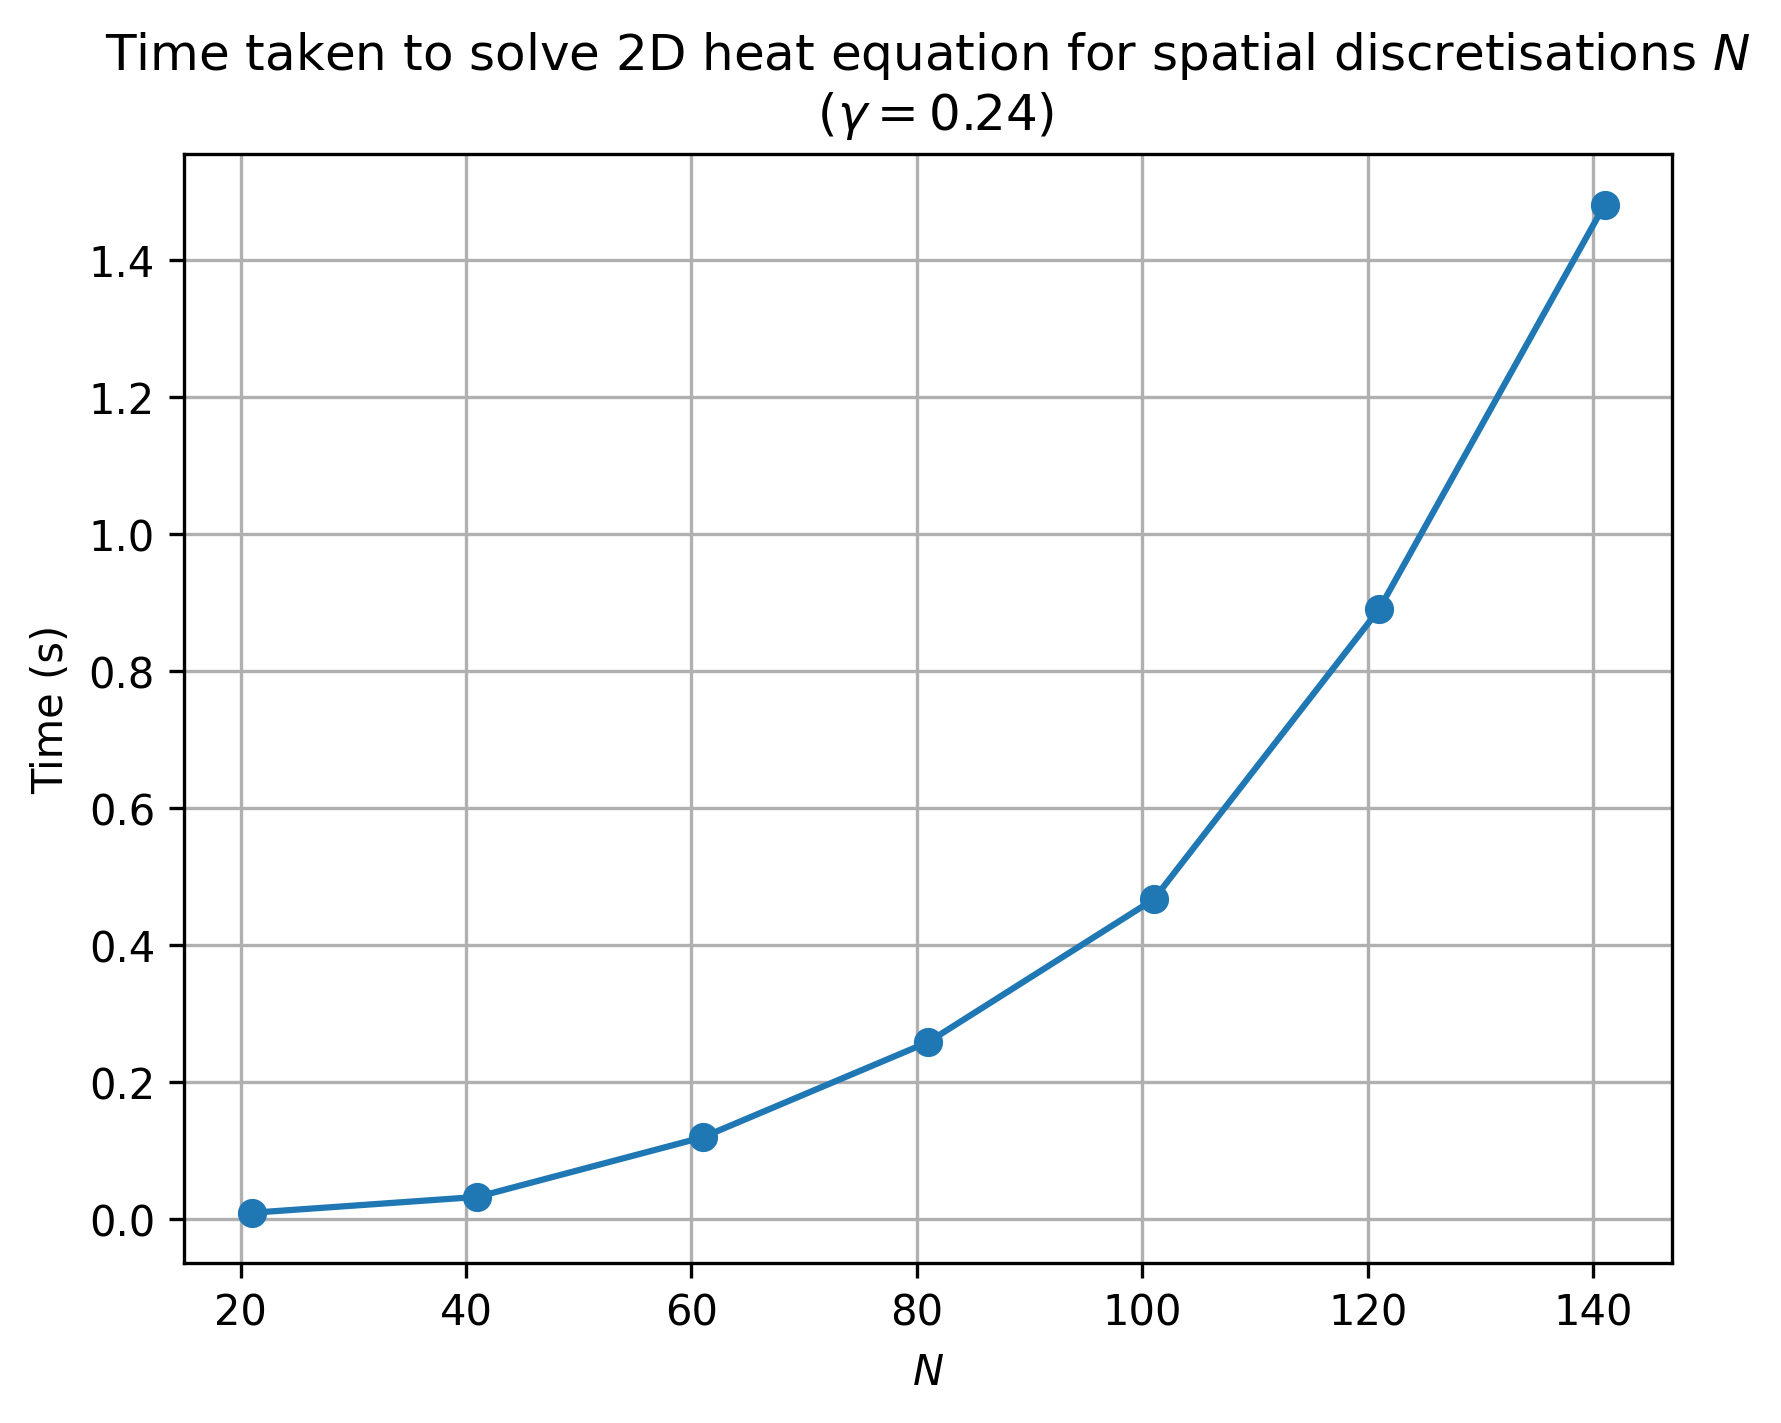

In [21]:
# Plot times taken to solve heat equation for different N
plt.plot(timed_N,comp_times_N,'-o')

# Make plot neater
plt.title(f"Time taken to solve 2D heat equation for spatial discretisations $N$ \n ($\gamma={gamma}$)")
plt.xlabel("$N$"); plt.ylabel("Time (s)")
plt.grid()

Unsurprisingly, we observe that as we increase the amount of gridpoints $N$, the heat equation takes longer to solve, following a roughly quadratic increase. Intuitively then we expect that a larger $N$ corresponds to a smaller deviation between $t^*_{obs}$ and actual $t*$.

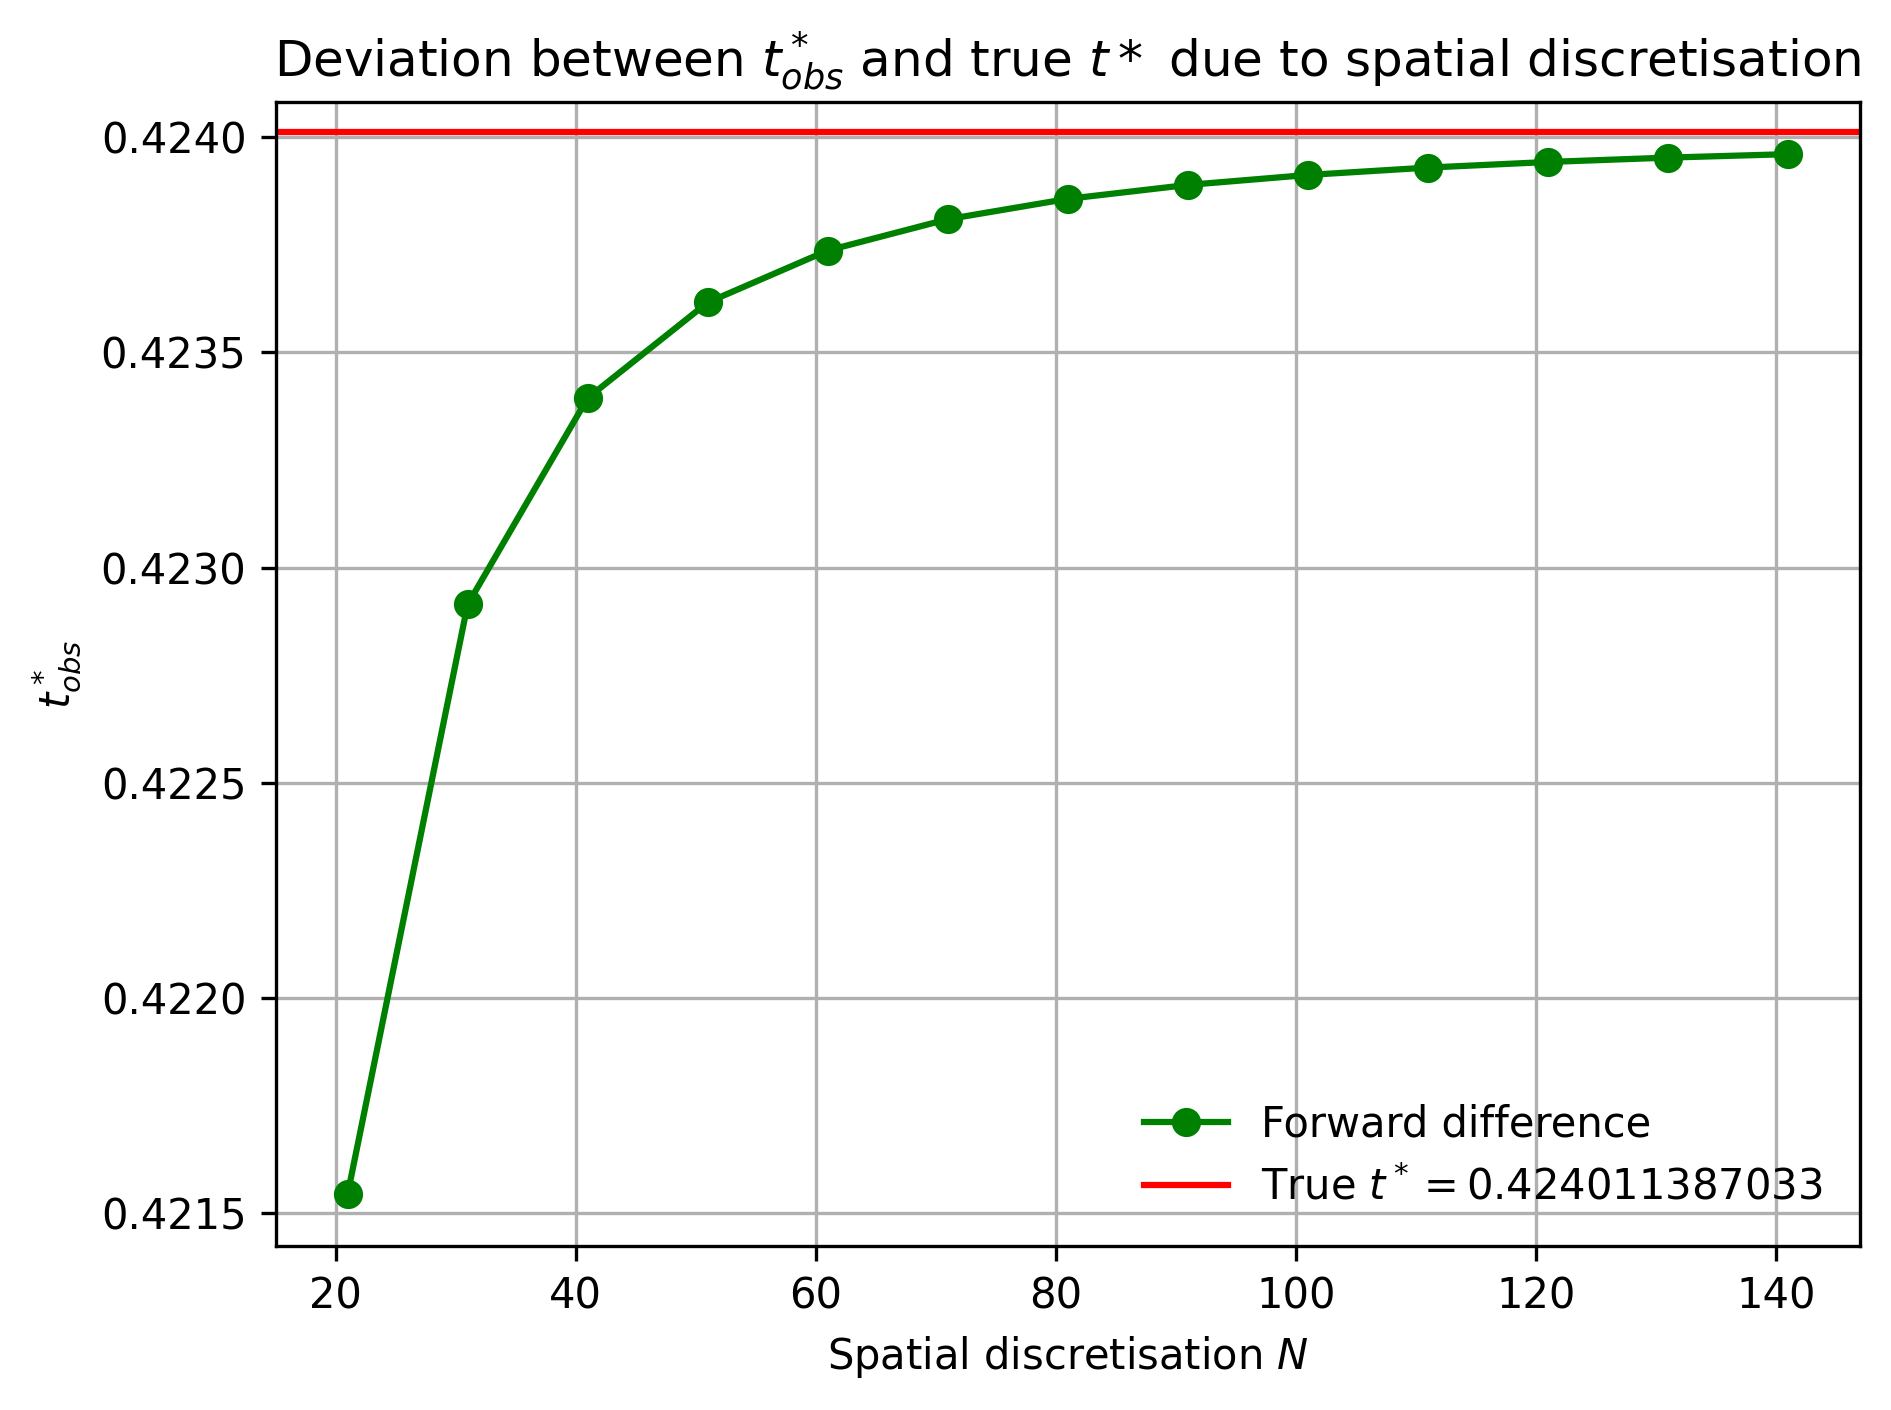

In [22]:
# Find difference between tstar observed and actual for all tstars found using N values

# Plot this error as a function of N
plt.plot(N,t_star_list,'-o',color='green',label="Forward difference")
plt.axhline(t_star_true, color='red', label=f"True $t^* = {t_star_true}$")
plt.xlabel("Spatial discretisation $N$"); plt.ylabel("$t^*_{obs}$")
plt.title("Deviation between $t^*_{obs}$ and true $t*$ due to spatial discretisation")

# Make plot neater
plt.grid(); plt.legend(); plt.tight_layout()

The above graph showing the deviation between $t^*_{obs}$ and $t^*$ as a function of the spatial discretisation $N$ verifies our earlier intuition that this error generally decreases. As we increase $N$, $t^*_{obs}$ approaches $t^*$ from below, in a roughly quadratic nature. Hence, we have now confirmed that increasing $N$ and decreasing $\gamma$ has the effect of decreasing the error between $t^*_{obs}$ and $t^*$.

## Attempting to get an accurate estimate for $t^*$
Thus, we can choose adequate values for these two parameters such that there are more digits of $t^*_{obs}$ which agree with $t^*$. This is where the advantage of a GPU implementation comes in. As we have designed our explicit solver to iterate the spatial components over the device (GPU), we have a lot of room to increase $N$ as high as we want to. Infact, Python was actually complaining about GPU under-utilisation above:

    8%|▊         | 1/13 [00:00<00:01,  7.16it/s]/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 9 will likely result in GPU under-utilization due to low occupancy.
      warn(NumbaPerformanceWarning(msg))

for $N$ up to about $100$. If we did a purely CPU implementation instead, then for $N \approx 150$, the Python kernel crashes due to over-utilisation of random access memory (RAM). Actually, implicit methods circumvent this due to their implementation of sparse matrices, but explicit methods do not really need them and can infact be disadvantaged by them due to the increased overhead that sparse matrices introduce. This is exactly why the implicit methods, which we look at later on, are not GPU accelerated, and only kept to the kernel.



### Searching over a range of $N$ with different $\gamma$
In our analysis above where we varied $N$ and $\gamma$, we noticed that $\gamma$ gave us linear deviations between $t^*$ and $t^*_{obs}$. However, changing $N$ meant that this deviation instead became quadratic. This observation suggests that the discretisation over space, $N$, is more deciding towards this error between the observed and true values.

Hence, we wish to search for the minimum error between these two by defining a range of values of $N$, while limiting our search over $\gamma$ to just a few values. We will do this for `float64` precision, due to its increased accuracy, especially beyond the 8th decimal where `float32` breaks.

In [23]:
# Specify range of N we wish to test, alongside gamma and maximum time
N = np.arange(21,601,20); t_max = 0.44

# Create storage arrays
t_star_024 = []; t_star_012 = []; t_star_006 = []

# Loop over gammas
for n in tqdm(N):
  # Calculate t* observed for gamma=0.24
  _, _, t_star = central_heat_profile(n, t_max, 0.24, dtype=np.float64)
  t_star_024.append(t_star)

  # Calculate t* observed for gamma=0.12
  _, _, t_star = central_heat_profile(n, t_max, 0.12, dtype=np.float64)
  t_star_012.append(t_star)

  # Calculate t* observed for gamma=0.06
  _, _, t_star = central_heat_profile(n, t_max, 0.06, dtype=np.float64)
  t_star_006.append(t_star)

 24%|██▍       | 7/29 [00:10<00:51,  2.34s/it]/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 121 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
100%|██████████| 29/29 [10:33<00:00, 21.85s/it]


We will plot the difference between $t^*_{obs}$ and $t^*$ as a function of $N$, and we will scale the y-axis such that it is logarithmic, as this gives us results that are easier to analyse.

In [24]:
# Find error for float64 precision
t_star_errors_024 = np.abs(t_star_024 - np.ones(len(t_star_024))*t_star_true)
t_star_errors_012 = np.abs(t_star_012 - np.ones(len(t_star_012))*t_star_true)
t_star_errors_006 = np.abs(t_star_006 - np.ones(len(t_star_006))*t_star_true)

<>:2: SyntaxWarning: invalid escape sequence '\g'
<>:3: SyntaxWarning: invalid escape sequence '\g'
<>:4: SyntaxWarning: invalid escape sequence '\g'
<>:2: SyntaxWarning: invalid escape sequence '\g'
<>:3: SyntaxWarning: invalid escape sequence '\g'
<>:4: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-3721435878.py:2: SyntaxWarning: invalid escape sequence '\g'
  plt.plot(N, t_star_errors_024, '-o', label="$\gamma = 0.24$")
/tmp/ipython-input-3721435878.py:3: SyntaxWarning: invalid escape sequence '\g'
  plt.plot(N, t_star_errors_012, '-o', label="$\gamma = 0.12$")
/tmp/ipython-input-3721435878.py:4: SyntaxWarning: invalid escape sequence '\g'
  plt.plot(N, t_star_errors_006, '-o', label="$\gamma = 0.06$")


Text(0.5, 1.0, 'Error between $t^*_{obs}$ and true $t^*$ due to spatial discretisation')

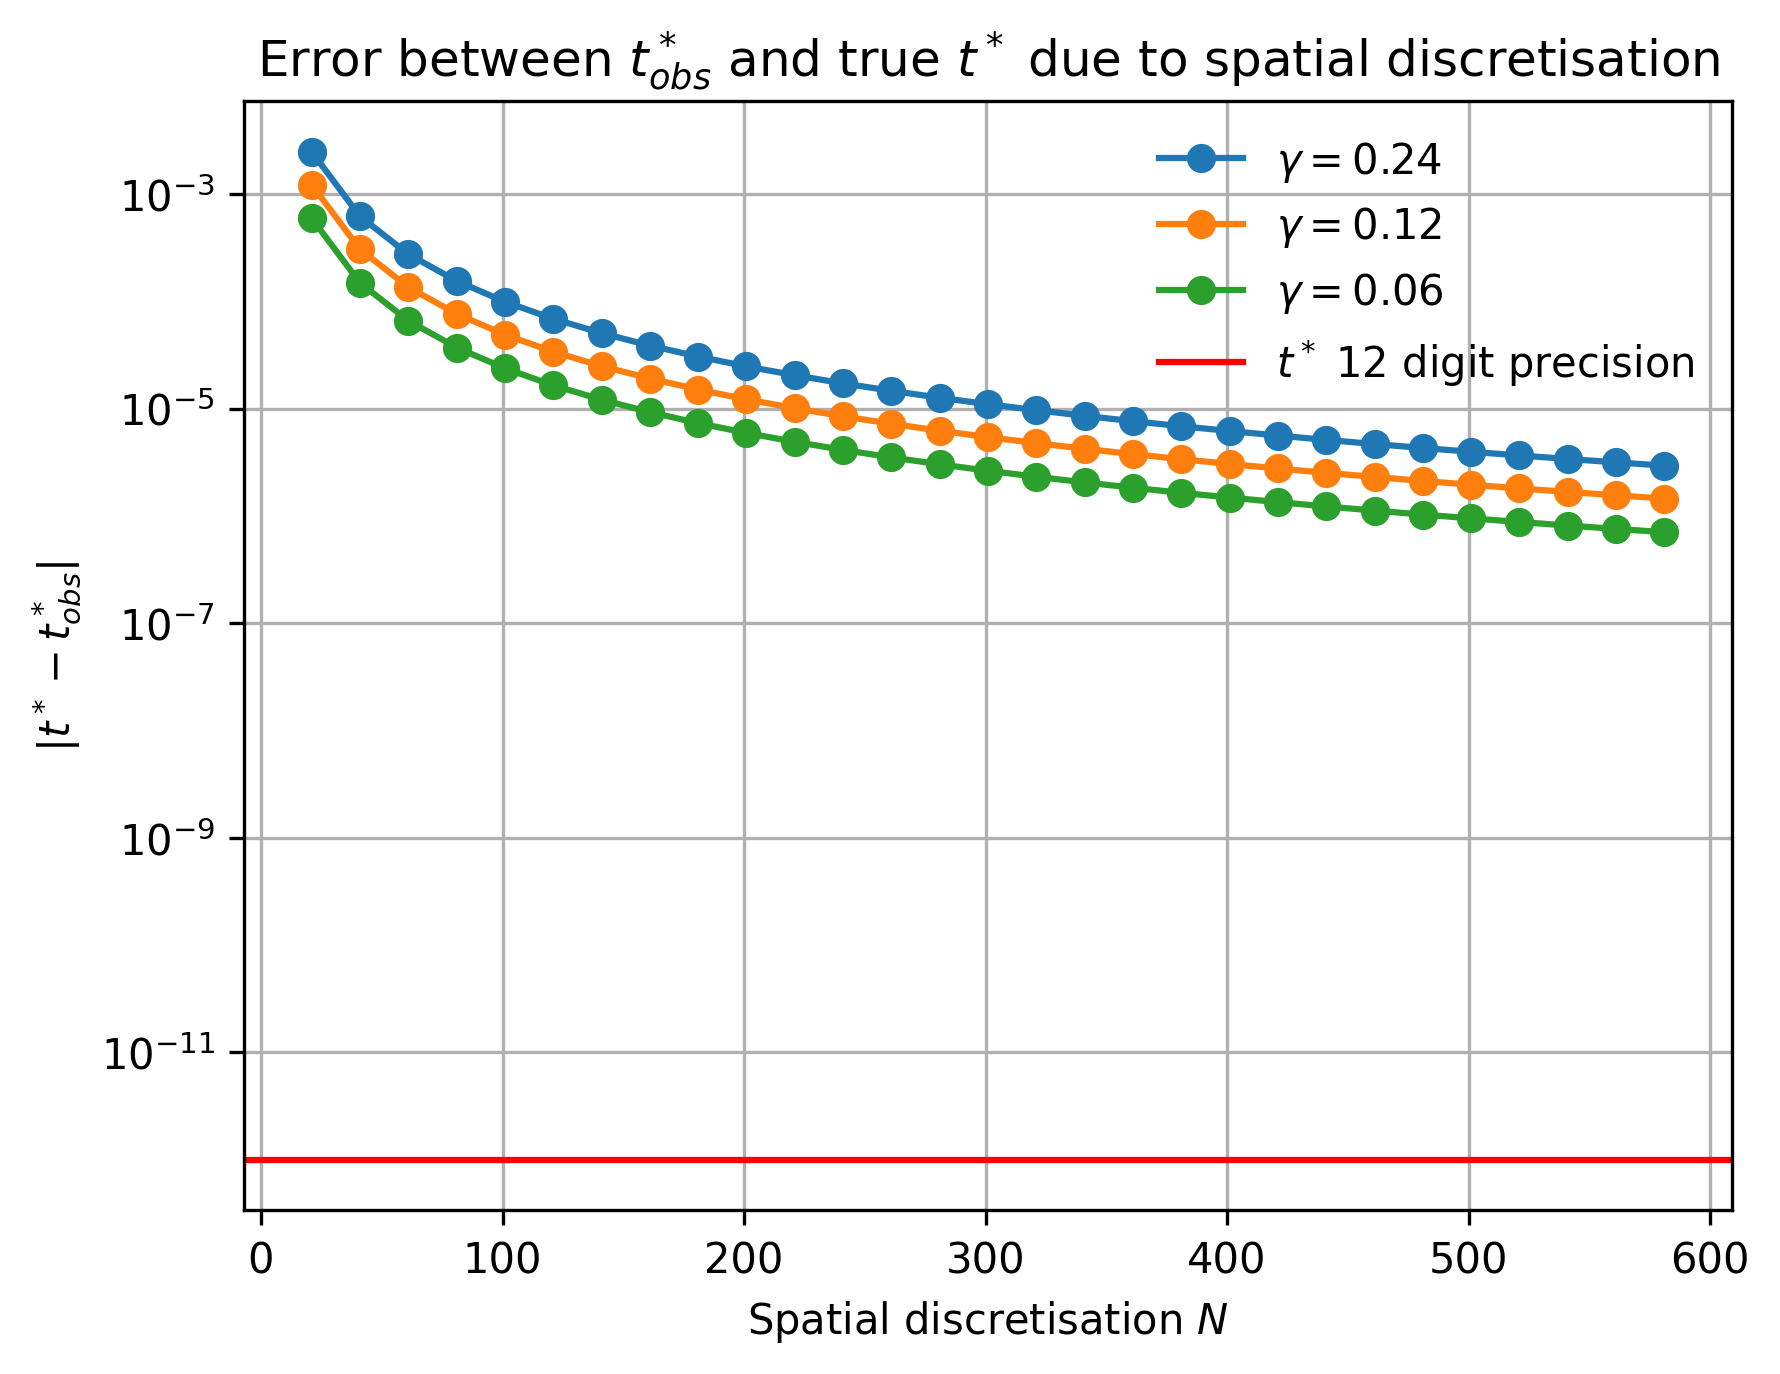

In [25]:
# Plot errors for different gamma
plt.plot(N, t_star_errors_024, '-o', label="$\gamma = 0.24$")
plt.plot(N, t_star_errors_012, '-o', label="$\gamma = 0.12$")
plt.plot(N, t_star_errors_006, '-o', label="$\gamma = 0.06$")
plt.axhline(1e-12, color='red', label=f"$t^*$ 12 digit precision")
# Make plot neater
plt.grid(); plt.legend(); plt.yscale("log")
plt.xlabel("Spatial discretisation $N$"); plt.ylabel("$|t^* - t^*_{obs}|$")
plt.title("Error between $t^*_{obs}$ and true $t^*$ due to spatial discretisation")


The graph above again shows that the error between $t^*_{obs}$ and $t^*$ decreases as $N$ increases, exactly as expected. Smaller values of $\gamma$ are all around more accurate, but we see that a smaller $\gamma$ does not really impact the rate of this error decrease. We see that between $\gamma=0.12$ and $\gamma=0.06$ there is barely any difference at all. Note that we get diminishing returns as $N$ goes up.

So if we want to find an accurate estimate for $t^*$, we could do one of two things:
  - Go up to $N \approx 1600$, as $N$ beyond this will give us little improvement at an increasing computational cost and kernel death risk, paired with $\gamma \approx 0.1$
  - Use $\gamma \approx 0.0032$ with $N$ remaining modest around $50$. This will almost definitely minimise the error and be extremely accurate. However, this result is unverifiable by our full solver as this will almost certainly crash it.

We decided to go for the first option, as this gives us a better practical accuracy.

In [26]:
N = 1601; t_max = 0.45; gamma = 0.10
center_profile, t_array, tstar_obs = central_heat_profile(N, t_max, gamma, dtype=np.float64)

print(f"Gamma = {gamma}: Time at which the center of the plate first exceeds u=1: {tstar_obs} (a.u.)")
print(f"Real time is {t_star_true}")

Gamma = 0.1: Time at which the center of the plate first exceeds u=1: 0.42401122932760427 (a.u.)
Real time is 0.424011387033


Now, $t^*_{obs}$ and $t^*$ agree with eachother up to 6 decimal places! Our error now is of the order $10^{-7}$. Of course, the values of $N$ and $\gamma$ chosen were rudimentary, and limited by the capabilities of our device. One could use more sophisticated techniques to work out an optimal value of $\gamma$ given $N$ or vice versa, taking into account the compute needed to perform such a task. Perhaps a two-dimensional search over a grid of $\gamma$ and $N$ could work.

# Implicit schemes

We have investigated the forward scheme in great detail. Now, let us consider two implicit schemes. We will start off by looking at the backward Euler implementation.

## Backward Euler implementation
From the forward difference scheme we had the following equation:
$$u_{i,j}^{n+1} = u_{i,j}^n + \gamma(u_{i+1,j}^n + u_{i-1,j}^n + u_{i,j+1}^n + u_{i,j-1}^n - 4u_{i,j}^n).$$

Let's rewrite this equation slightly, by "expanding" the $4u_{i,j}^n$ term out:
$$u_{i,j}^{n+1} = u_{i,j}^n + \gamma(u_{i+1,j}^n - 2u_{i,j}^n + u_{i-1,j}^n + u_{i,j+1}^n - 2u_{i,j}^n + u_{i,j-1}^n),$$

and note that the $n+1$ term and $n$ terms are on separate sides. This equation can then be written in matrix format as

$$u_{i,j}^{n+1} = I u_{i,j}^{n} + L u_{i,j}^{n} = (I + \gamma L)u_{i,j}^n$$

where

$$L u_{i,j}^{n} =
\underbrace{u_{i+1,j}^{n} - 2u_{i,j}^{n} + u_{i-1,j}^{n}}_{\text{x-direction}}
+
\underbrace{u_{i,j+1}^{n} - 2u_{i,j}^{n} + u_{i,j-1}^{n}}_{\text{y-direction}}$$

This format makes the forward scheme obvious in that we add $\gamma L$ to the original (vectorised) array $u_{i,j}^n$ to obtain the new array $u_{i,j}^{n+1}$.

Hence, we can intuitvely guess that a backward scheme would be of the form

$$u_{i,j}^{n-1} = I u_{i,j}^{n} - L u_{i,j}^{n} = (I - \gamma L)u_{i,j}^n$$

or alternatively

$$u_{i,j}^{n} = I u_{i,j}^{n+1} + L u_{i,j}^{n+1} = (I + \gamma L)u_{i,j}^{n+1}$$

since the index $n$ is a dummy variable which can be relabelled $n \rightarrow n+1$. Of course in this format, the Laplacian matrix $L$ will be of the form

$$L u_{i,j}^{n+1} =
\underbrace{u_{i+1,j}^{n+1} - 2u_{i,j}^{n+1} + u_{i-1,j}^{n+1}}_{\text{x-direction}}
+
\underbrace{u_{i,j+1}^{n+1} - 2u_{i,j}^{n+1} + u_{i,j-1}^{n+1}}_{\text{y-direction}}$$

Now let us rewrite this slightly differently

$$L u_{i,j}^{n+1} = (u_{i+1}^{n+1} - 2u_{i}^{n+1} + u_{i-1}^{n+1})_j
+
(u_{j+1}^{n+1} - 2u_{,j}^{n+1} + u_{j-1}^{n+1})_i$$

This notation should make it more obvious that we can use a **tensor product** to describe the combination of the $i$ and $j$ indices, much like how we do so in quantum mechanics.

Let's look at this termwise. Since the first term of this above expression, $(u_{i+1}^{n+1} - 2u_{i}^{n+1} + u_{i-1}^{n+1})_j$, clearly pertains to the three-point stencil over the $x-$position, with the $y-$position remaining normal, we can write this as the simple tensor product $T \otimes I$. Here, the operator $T$ represents the three-point $x-$ stencil and the identity operator reflects the unchanged $y-$ portion.

Then by analogy the second term of this expression, which represents a three-point stencil over $y-$positions with $x$ unchanged must instead be $I \otimes T$.

Hence we can write the Laplacian operator as

$$L = T \otimes I + I \otimes T$$

where $T$ will follow the structure $T = \text{tridiag}(1,-2,1)$. Recalling that $N$ is the amount of gridpoints along each spatial dimension, we once again impose Dirichlet boundary conditions on the two edge-points of this grid, leaving us with $N-2$ gridpoints which we must evaluate. Therefore, we can say that $T$ will be an $(N-2)$-dimensional matrix.

Due to these boundary conditions, the identity matrix $I$ is subject to the same 'truncation' of outer points, also resulting in a $(N-2)$-dimensional identity. The Kronecker (tensor) product works by multiplying the elements of the matrix to the left of the operation $\otimes$ by the entire matrix on the right of that operation. Hence, we expect $T \otimes I$ to be an $(N-2 \times N-2) = (N-2)^2$-dimensional matrix.

And since $L = T \otimes I + I \otimes T$, this is just the addition of two $(N-2)^2$-dimensional matrices, hence $L$ is also of the same dimension.

Having figured out the structure and dimension of $L$, we can now go back to the matrix equation relating $u_{i,j}^{n+1}$ to $u_{i,j}^n$:

$$(I - \gamma L)u_{i,j}^{n+1} = u_{i,j}^n$$

Since $L$ is $(N-2)^2$-dimensional, this clearly means that $u_{i,j}^{n+1}$ when vectorised is also $(N-2)^2$-dimensional. So we need to vectorise $u_{i,j}^{n+1}$ and $u_{i,j}^n$ in such a way that their dimensions become compatible with the above equation. These vectorised versions will be called $\mathbf{u}^{n+1}$ and $\mathbf{u}^n$ correspondingly.

(N.B. The identity matrix in the above equation can be thought of as $I_x \otimes I_y$ where $I_x$ and $I_y$ are $(N-2)$-dimensional identity matrices in the $x-$ and $y-$space)

And actually these vectorised $\mathbf{u}$ can be constructed in a similar fashion to how we constructed the Laplacian matrix $L$, using tensor products. We can write $u_{i,j}^{n}$ as $(u_i^n)_j$ or equivalently $(u_j^n)_i$, making the tensor product dependence more obvious. Hence we can write

$$\mathbf{u}^n = u_i^n \otimes u_j^n$$

and individually $u_i^n$, $u_j^n$ must be $(N-2)$-dimensional vectors, such that the vectorised form is $(N-2)^2$-dimensional.

Hence, we have the following vectorised equation,

$$(I - \gamma L)\mathbf{u}^{n+1} = \mathbf{u}^n.$$

However, we still have one last thing to consider. We have restricted the above equation to the interior grid points only. However, we should also be aware that every single interior point which touches the boundary will pick up an extra boundary value term. When vectorised, this contribution is known as $\mathbf{b}$. Hence, the above equation can actually be correctly written as,

$$(I - \gamma L)\mathbf{u}^{n+1} = \mathbf{u}^n + \mathbf{b}.$$

This is the update equation which we will be using, and in particular, we will use this equation with sparse matrices.

### Imports: Sparse matrices

Because $L$ is constructed from a tensor product between a tridiagonal and an identity matrix, most of its components will be zero. Therefore, we can actually use sparse matrices to solve a problem given by $L$.

We did not use a sparse matrix implementation for the explicit solver, as it did not actually require one. The implicit techniques do require a sparse solver. However, sparse solvers are in general incompatible with GPU parallelisation methods and so we cannot exploit this. This does make their function construction slightly easier.

In [27]:
import scipy.sparse as sp
import scipy.sparse.linalg as spla

In [28]:
def backward_heat_grid(N, t_max, gamma):
  """Solve the two-dimensional heat equation for a plate spanning [-1,1] x [-1,1],
   using the backward difference scheme.

  Boundary conditions (Dirichlet):
   The initial conditions have been specified such that the right-hand face of the plate is initially heated,
   whilst the remaining faces are at zero temperature (cold). These faces maintain these temperatures for all times.

  Inputs:
   N - number of grid points along each side of the square
   t_max - maximum time the problem is propagated up to
   gamma - coefficient in front of Laplacian, which is a number controlling the ratio between temporal and spatial resolution

  Outputs:
   u - a three-dimensional array of the form u[i,j,k],
    where i represents the x-coordinate,
    where j represents the y-coordinate,
    where k represents the time t."""
  # The length of our problem is 2 in either dimension, as the plate spans -1 < x,y < 1
  length = 2.0
  # Calculate dx and dt according to gamma
  dx = length / (N - 1)
  dt = gamma * dx**2
  # Find total number of time steps
  time_steps = int(np.ceil(t_max / dt))

  # Construct T matrix of form tridiag(1,-2,1), and also I matrix
  T = sp.diags([np.ones(N-3), -2*np.ones(N-2), np.ones(N-3)], [-1,0,1])
  I = sp.eye(N-2)
  # Then combine T, I according to tensor for L
  L = sp.kron(I, T) + sp.kron(T, I)
  A = sp.eye( (N-2)**2 ) - gamma*L

  solve_A = spla.factorized(A.tocsc())

  # Set up storage for u array
  u = np.zeros((N, N, time_steps + 1))

  # Enforce Dirichlet boundary conditions: RHS face warm, rest cold
  u[:,0,:] = 0.0
  u[0,:,:] = 0.0
  u[-1,:,:] = 0.0
  u[:,-1,:] = 5.0

  # Define vectorised u
  u_vec = np.zeros( (N-2)**2 )
  # Also define vectorised boundary conditions grid
  bc_grid = np.zeros((N-2, N-2)); bc_grid[:, -1] = 5.0
  bc_vec = (dt / dx**2) * bc_grid.ravel()

  # Iterate over time solving vectorised form of diffnl equation
  for n in range(time_steps):
      u_vec = solve_A(u_vec + bc_vec)
      u[1:-1, 1:-1, n+1] = u_vec.reshape((N-2,N-2))

  return u

## Crank-Nicolson implementation
We will also assess another implicit technique, the Crank-Nicolson method. Unlike the previous two methods, we will not provide a full derivation of it,
we will just write that its matrix form is the following equation:

$$(I - \frac{\gamma}{2}L)\mathbf{u}^{n+1} = (I + \frac{\gamma}{2}L)\mathbf{u}^n + \mathbf{b}$$

Here, $L$, $\mathbf{u}$ and the identity $I$ are constructed in exactly the same way as they are constructed for the backward difference method.

In [29]:
def CN_heat_grid(N, t_max, gamma):
  """Solve the two-dimensional heat equation for a plate spanning [-1,1] x [-1,1],
   using the Crank-Nicolson (CN) scheme.

  Boundary conditions (Dirichlet):
   The initial conditions have been specified such that the right-hand face of the plate is initially heated,
   whilst the remaining faces are at zero temperature (cold). These faces maintain these temperatures for all times.

  Inputs:
   N - number of grid points along each side of the square
   t_max - maximum time the problem is propagated up to
   gamma - coefficient in front of Laplacian, which is a number controlling the ratio between temporal and spatial resolution

  Outputs:
   u - a three-dimensional array of the form u[i,j,k],
    where i represents the x-coordinate,
    where j represents the y-coordinate,
    where k represents the time t."""
  # The length of our problem is 2 in either dimension, as the plate spans -1 < x,y < 1
  length = 2.0
  # Calculate dx and dt according to gamma
  dx = length / (N - 1)
  dt = gamma * dx**2
  # Find total number of time steps
  time_steps = int(np.ceil(t_max / dt))

  # Construct T matrix of form tridiag(1,-2,1), and also I matrix
  T = sp.diags([np.ones(N-3), -2*np.ones(N-2), np.ones(N-3)], [-1, 0, 1])
  I = sp.eye(N-2)
  # Then combine T, I according to tensor for L
  L = sp.kron(I, T) + sp.kron(T, I)
  #  Find net update matrices
  A = sp.eye((N-2)**2) - 0.5 * gamma * L
  B = sp.eye((N-2)**2) + 0.5 * gamma * L
  solve_A = spla.factorized(A.tocsc())

  # Set up storage for u array
  u = np.zeros((N, N, time_steps + 1))

  # Enforce Dirichlet boundary conditions: RHS face warm, rest cold
  u[:,0,:] = 0.0
  u[0,:,:] = 0.0
  u[-1,:,:] = 0.0
  u[:,-1,:] = 5.0

  # Define vectorised u
  u_vec = np.zeros((N-2)**2)
  # Also define vectorised boundary conditions grid
  bc_grid = np.zeros((N-2, N-2)); bc_grid[:, -1] = 5.0
  bc_vec = gamma * bc_grid.ravel()

  # Iterate over time solving vectorised form of diffnl equation
  for n in range(time_steps):
      rhs = B.dot(u_vec) + bc_vec
      u_vec = solve_A(rhs)
      u[1:-1, 1:-1, n+1] = u_vec.reshape((N-2, N-2))

  return u

## Plotting heat distribution for different $\gamma$
It is logical to start off our analysis of the implicit scheme by simply plotting the temperature distributions for different values of $\gamma$, much like last time.

Previously, the explicit scheme was unstable for $\gamma > 0.25$. We expect that implicit solvers are stable for all values of $\gamma$. We can realise this from the vectorised form of the heat equation,

$$(I - \gamma L)\mathbf{u}^{n+1} = \mathbf{u}^n.$$

To determine the solution to \mathbf{u}^n, we want to compute the eigenvalues of the matrix $I - \gamma L$. Due to the form of $\gamma$, these eigenvalues will instead all be negative for any $\gamma$, hence we say that implicit solvers are unconditionally stable.

Therefore, in our heat distribution colour plots below, we expect that for $\gamma > 0.25$, the solution does not explode, as we remain stable.

We will show that both the backward Euler and Crank-Nicolson implementations are unconditionally stable, but we only plot the heat distribution image for the backward Euler technique.

<>:22: SyntaxWarning: invalid escape sequence '\g'
<>:35: SyntaxWarning: invalid escape sequence '\g'
<>:22: SyntaxWarning: invalid escape sequence '\g'
<>:35: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-4293311903.py:22: SyntaxWarning: invalid escape sequence '\g'
  ax.set_title(f"$\gamma$ = {gamma:.2f}")
/tmp/ipython-input-4293311903.py:35: SyntaxWarning: invalid escape sequence '\g'
  plt.suptitle("Final temperature distributions for different Laplacian prefactors $\gamma$")
100%|██████████| 9/9 [00:13<00:00,  1.50s/it]


Text(0.5, 0.98, 'Final temperature distributions for different Laplacian prefactors $\\gamma$')

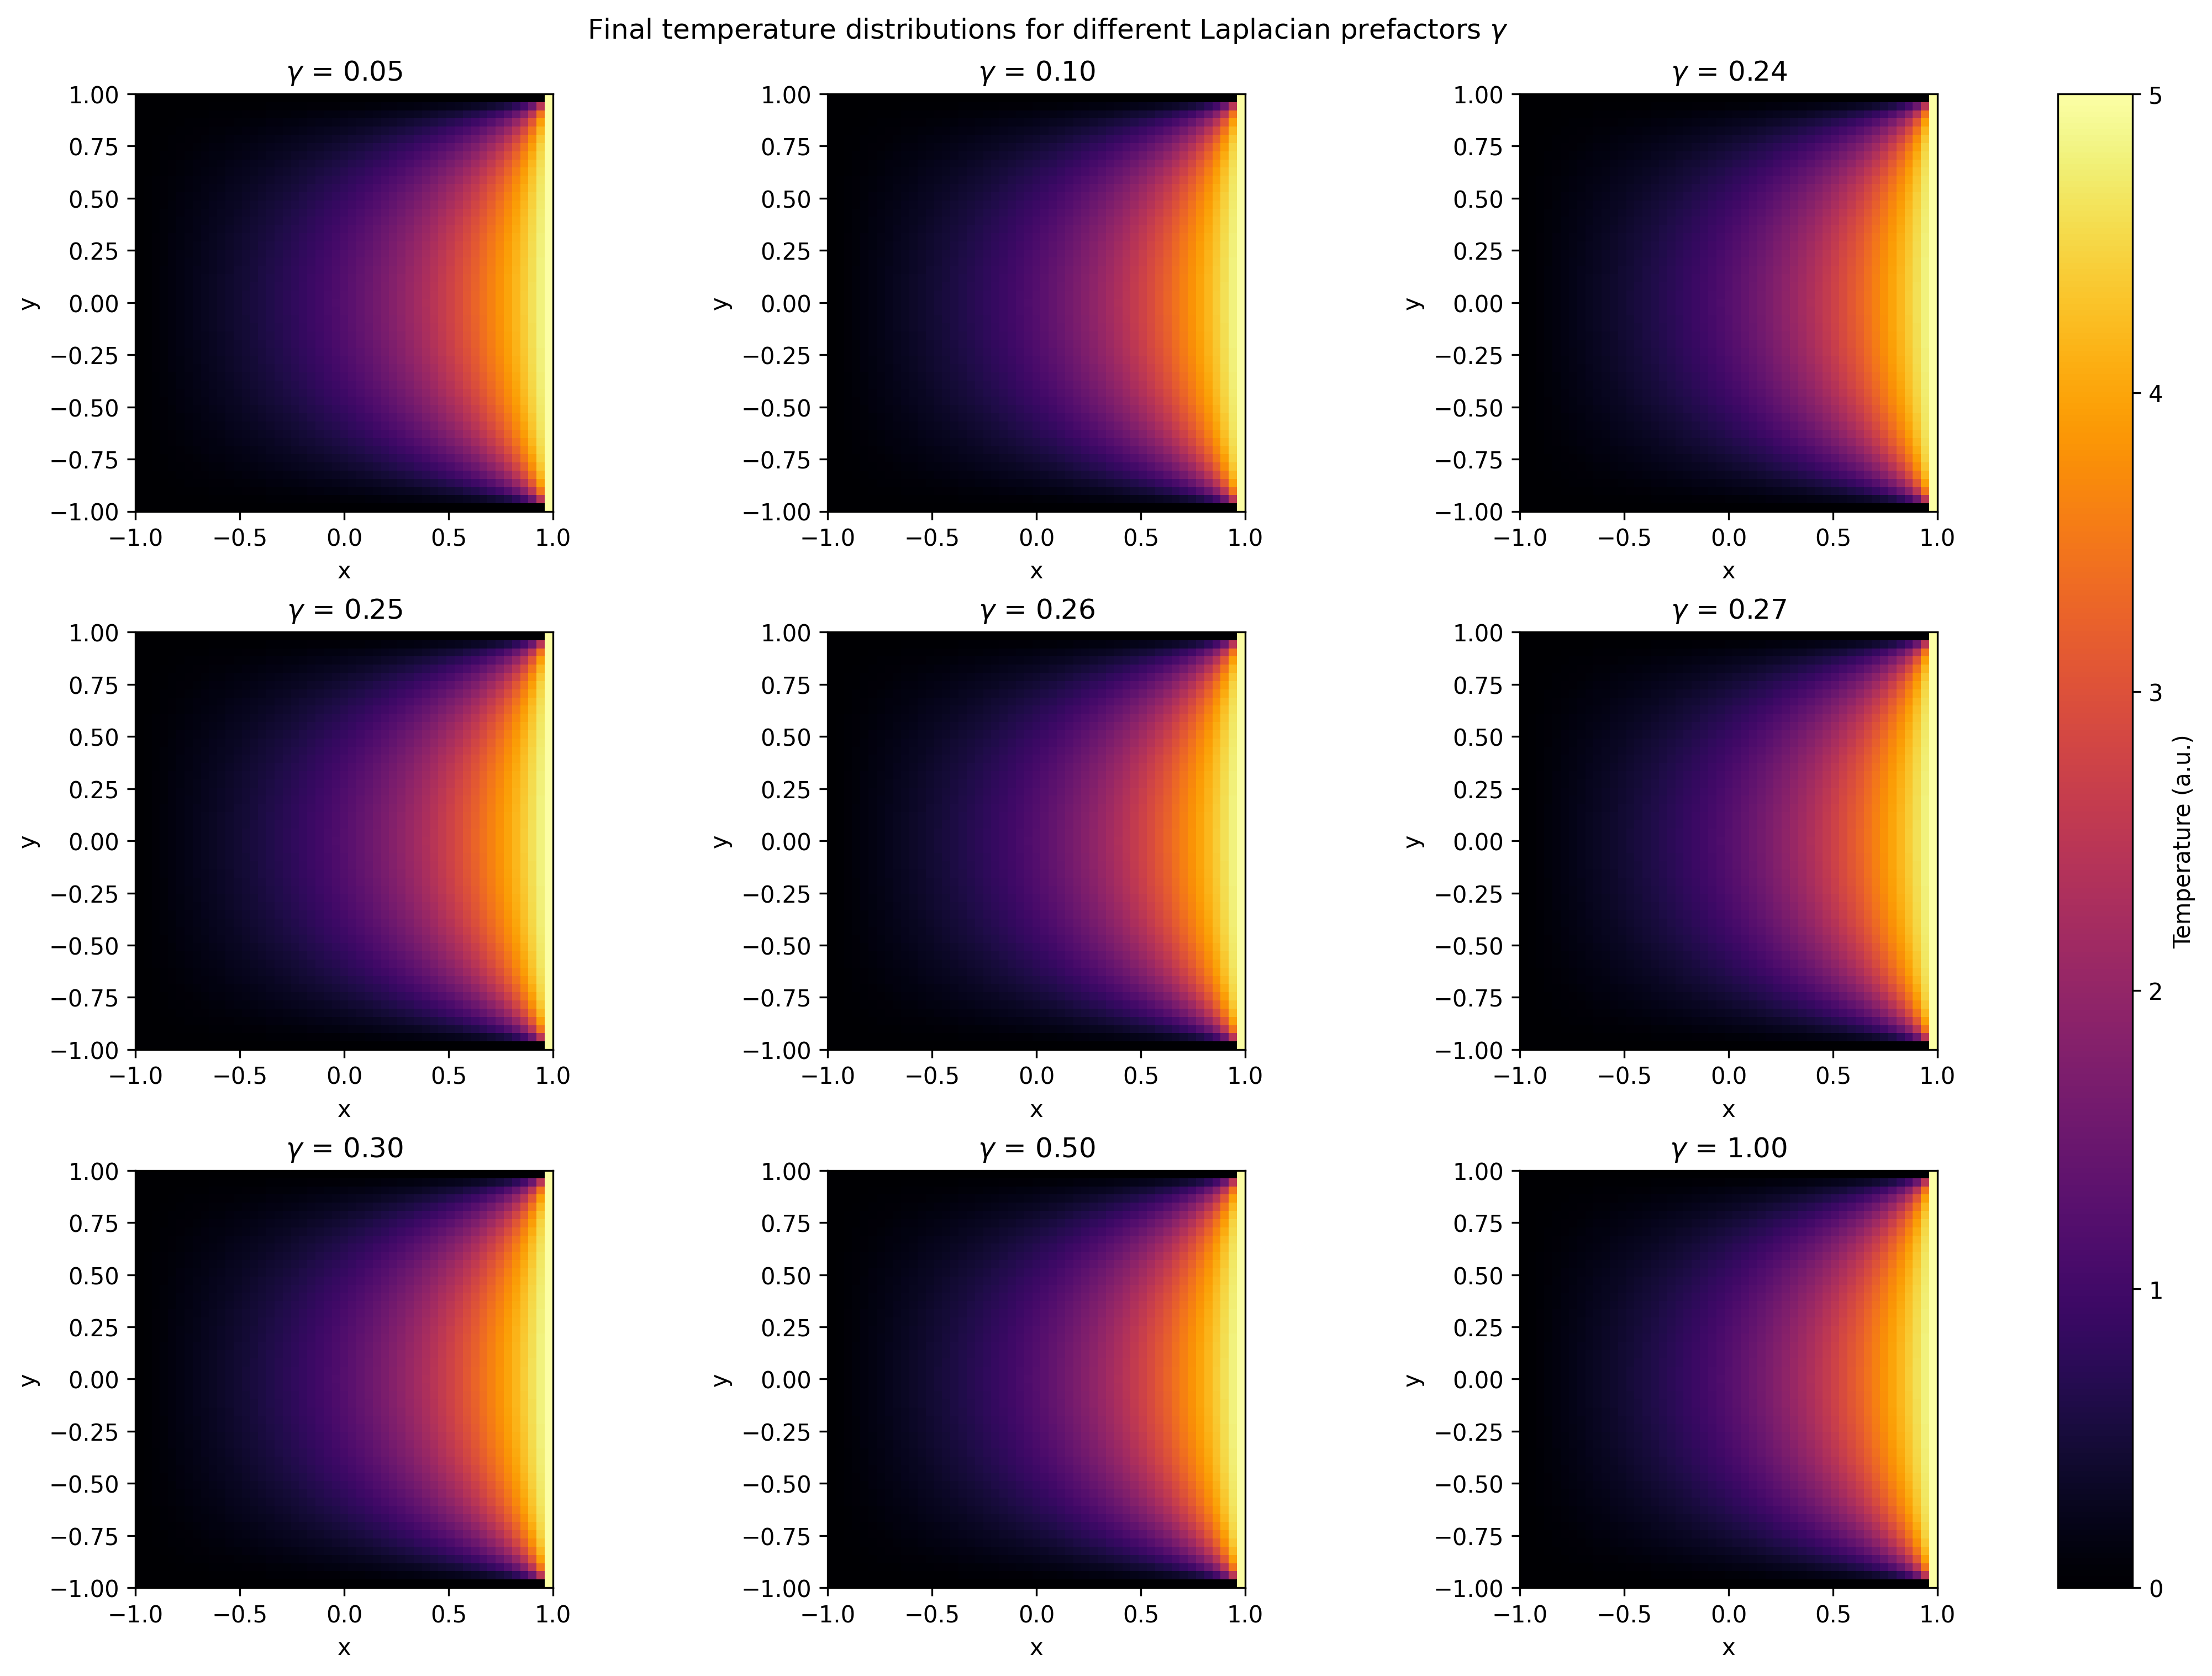

In [30]:
# Specify range of gammas we wish to test, alongside N and maximum time
gammas = np.array([0.05, 0.10, 0.24, 0.25, 0.26, 0.27, 0.30, 0.50, 1.00])
N = 51
t_max = 1.0

# Create storage arrays
final_distribution = []

# Loop over gammas
for gamma in tqdm(gammas):
    # Solve for final distribution and maximum temperatures
    u = backward_heat_grid(N, t_max, gamma)
    final_distribution.append(u[:, :, -1])

# Create figure, plot all gamma final temp distributions
fig, axes = plt.subplots(3, 3, figsize=(14, 10), constrained_layout=True)

for ax, gamma, field in zip(axes.flat, gammas, final_distribution):
    # Plot colour map
    im = ax.imshow(field, origin="lower", extent=(-1, 1, -1, 1), cmap="inferno", vmin=0.0, vmax=5.0)
    # Label plot
    ax.set_title(f"$\gamma$ = {gamma:.2f}")
    ax.set_xlabel("x"); ax.set_ylabel("y")

# No need for axis in all of them
for ax in axes.flat[len(gammas):]:
    ax.axis("off")

# Remove the unused axis
for ax in axes.flat[len(gammas):]:
    fig.delaxes(ax)

# Add global plot properties
fig.colorbar(im, ax=axes.ravel().tolist(), label="Temperature (a.u.)")
plt.suptitle("Final temperature distributions for different Laplacian prefactors $\gamma$")

The plots above verify our earlier expectation that $\gamma > 0.25$ is stable for implicit schemes, and thus it verifies that the backward Euler method is an unconditionally stable technique. We will show that the Crank-Nicolson method is stable by investigating the central profile temperature later on.

## Investigating central profile for different $\gamma$
In our analysis of the explicit scheme, we noticed that the midpoint temperature began to uncontrollably oscillate with an ever-increasing amplitude if $\gamma > 0.25$. This was due to the exponential nature of the time-solution. However, for the implicit scheme, the plots above suggest this is no longer the case.

Let us repeat the central profile analysis we performed for the explicit scheme for the two implicit schemes as well. Does this show us anything odd?

### Alternative function for computing $t^*_{obs}$
Previously we created quite a convenient function, `central_heat_profile`, which helped us to extract both the central profile of the plate over time, and also the value of $t^*_{obs}$. However, this function was specialised in that it only used the `explicit_heat_kernel_central` function to extract the central profile and return other appropriate things. Since we now have new solvers, `backward_heat_grid` and `CN_heat_grid`, we will need to make this `central_heat_profile` function more general such that it can accomodate for different types of solvers.

Hence, we will need to change up the `central_heat_profile` function slightly, such that it can take in a new argument, `method`, which is itself a function that can solve the heat equation.

In [31]:
def central_heat_profile(N, t_max, gamma, method, dtype=np.float64):
    """Solves the heat equation for a given spatial and temporal discretisation, using a given method.
      Analyses the heat at the center of the profile and extracts the first time for which the temperature
      of the midpoint of the profile exceeds 20% of that given by the initial conditions. Also analyses
      the time evolution of this temperature.

    Inputs:
      N - spatial discretisation, gridpoints
      t_max - maximum time of iteration
      gamma - temporal discretisation, prefactor infront of Laplacian
      method - method we wish to solve the heat equation with:
        Can use either explicit_heat_kernel, backward_heat_grid and CN_heat_grid.
      dtype - datatype which the u array is initialised in.

    Outputs:
      center_profile - temperature of the center point of the profile as a function of time
      t_array - time array for the specific value of gamma and N input
      t_star_obs - observed time for which the temperature of midpoint exceeds 20% of the initial boundary conditions"""
    # Solve for central heat distribution
    u = method(N, t_max, gamma)
    center_profile = u[N // 2, N // 2, :]

    # Find t_array for this specific gamma
    dx = 2.0 / (N - 1)
    dt = gamma * dx**2
    time_steps = int(np.ceil(t_max/dt))
    t_array = np.arange(time_steps + 1) * dt

    # Find arguments of u array for which center temp exceeds 1
    crossing = np.where(center_profile >= 1.0)[0]
    # Convert arguments to time and add to tstar list
    if not crossing.size:
      t_star_obs = np.nan
    else:
      n = crossing[0]
      if n == 0: # If we cross u=1 at t=0, then t_star_obs must be 0
        t_star_obs = 0.0
      else: # Compute t_star_obs using interpolation techniques
        y0, y1 = center_profile[n-1], center_profile[n]
        t0, t1 = (n-1)*dt, n*dt
        frac = (1.0 - y0) / (y1 - y0) if y1 != y0 else 0.0
        t_star_obs = t0 + frac * (t1 - t0)

    return center_profile, t_array, t_star_obs

### How does the midpoint temperature vary with time, as $\gamma$ changes?
We will investigate the midpoint temperature over time, for different $\gamma$. For the explicit scheme, we observed that this temperature initially rapidly rose before quickly reaching an asymptotic limit at around 1.1 or 1.2 arbitrary units, provided a stable $\gamma$.

We do this analysis for both the backward Euler scheme and the Crank-Nicolson implementation.

In [32]:
# This would be stable if it was the explicit scheme
N = 51; t_max = 5.0; gamma1 = 0.24
u1_back, t1_back, tstar1_back = central_heat_profile(N, t_max, gamma1, backward_heat_grid)
u1_CN, t1_CN, tstar1_CN = central_heat_profile(N, t_max, gamma1, CN_heat_grid)

# This would be unstable if it was the explicit scheme
N = 51; t_max = 5.0; gamma2 = 0.27
u2_back, t2_back, tstar2_back = central_heat_profile(N, t_max, gamma2, backward_heat_grid)
u2_CN, t2_CN, tstar2_CN = central_heat_profile(N, t_max, gamma2, CN_heat_grid)

# This would be super unstable if it was the explicit scheme
N = 51; t_max = 5.0; gamma3 = 1.00
u3_back, t3_back, tstar3_back = central_heat_profile(N, t_max, gamma3, backward_heat_grid)
u3_CN, t3_CN, tstar3_CN = central_heat_profile(N, t_max, gamma3, CN_heat_grid)

#### Backward Euler difference
Below, we plot the temperature distribution of the midpoint of the plate as a function of time.

<>:6: SyntaxWarning: invalid escape sequence '\g'
<>:9: SyntaxWarning: invalid escape sequence '\g'
<>:12: SyntaxWarning: invalid escape sequence '\g'
<>:21: SyntaxWarning: invalid escape sequence '\g'
<>:6: SyntaxWarning: invalid escape sequence '\g'
<>:9: SyntaxWarning: invalid escape sequence '\g'
<>:12: SyntaxWarning: invalid escape sequence '\g'
<>:21: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-3464946709.py:6: SyntaxWarning: invalid escape sequence '\g'
  axes[0].set_title(f"$\gamma={gamma1}$")
/tmp/ipython-input-3464946709.py:9: SyntaxWarning: invalid escape sequence '\g'
  axes[1].set_title(f"$\gamma={gamma2}$")
/tmp/ipython-input-3464946709.py:12: SyntaxWarning: invalid escape sequence '\g'
  axes[2].set_title(f"$\gamma={gamma3}$")
/tmp/ipython-input-3464946709.py:21: SyntaxWarning: invalid escape sequence '\g'
  plt.suptitle("Centre point temperature over time for different $\gamma$ \n Evaluated using backwards difference method",


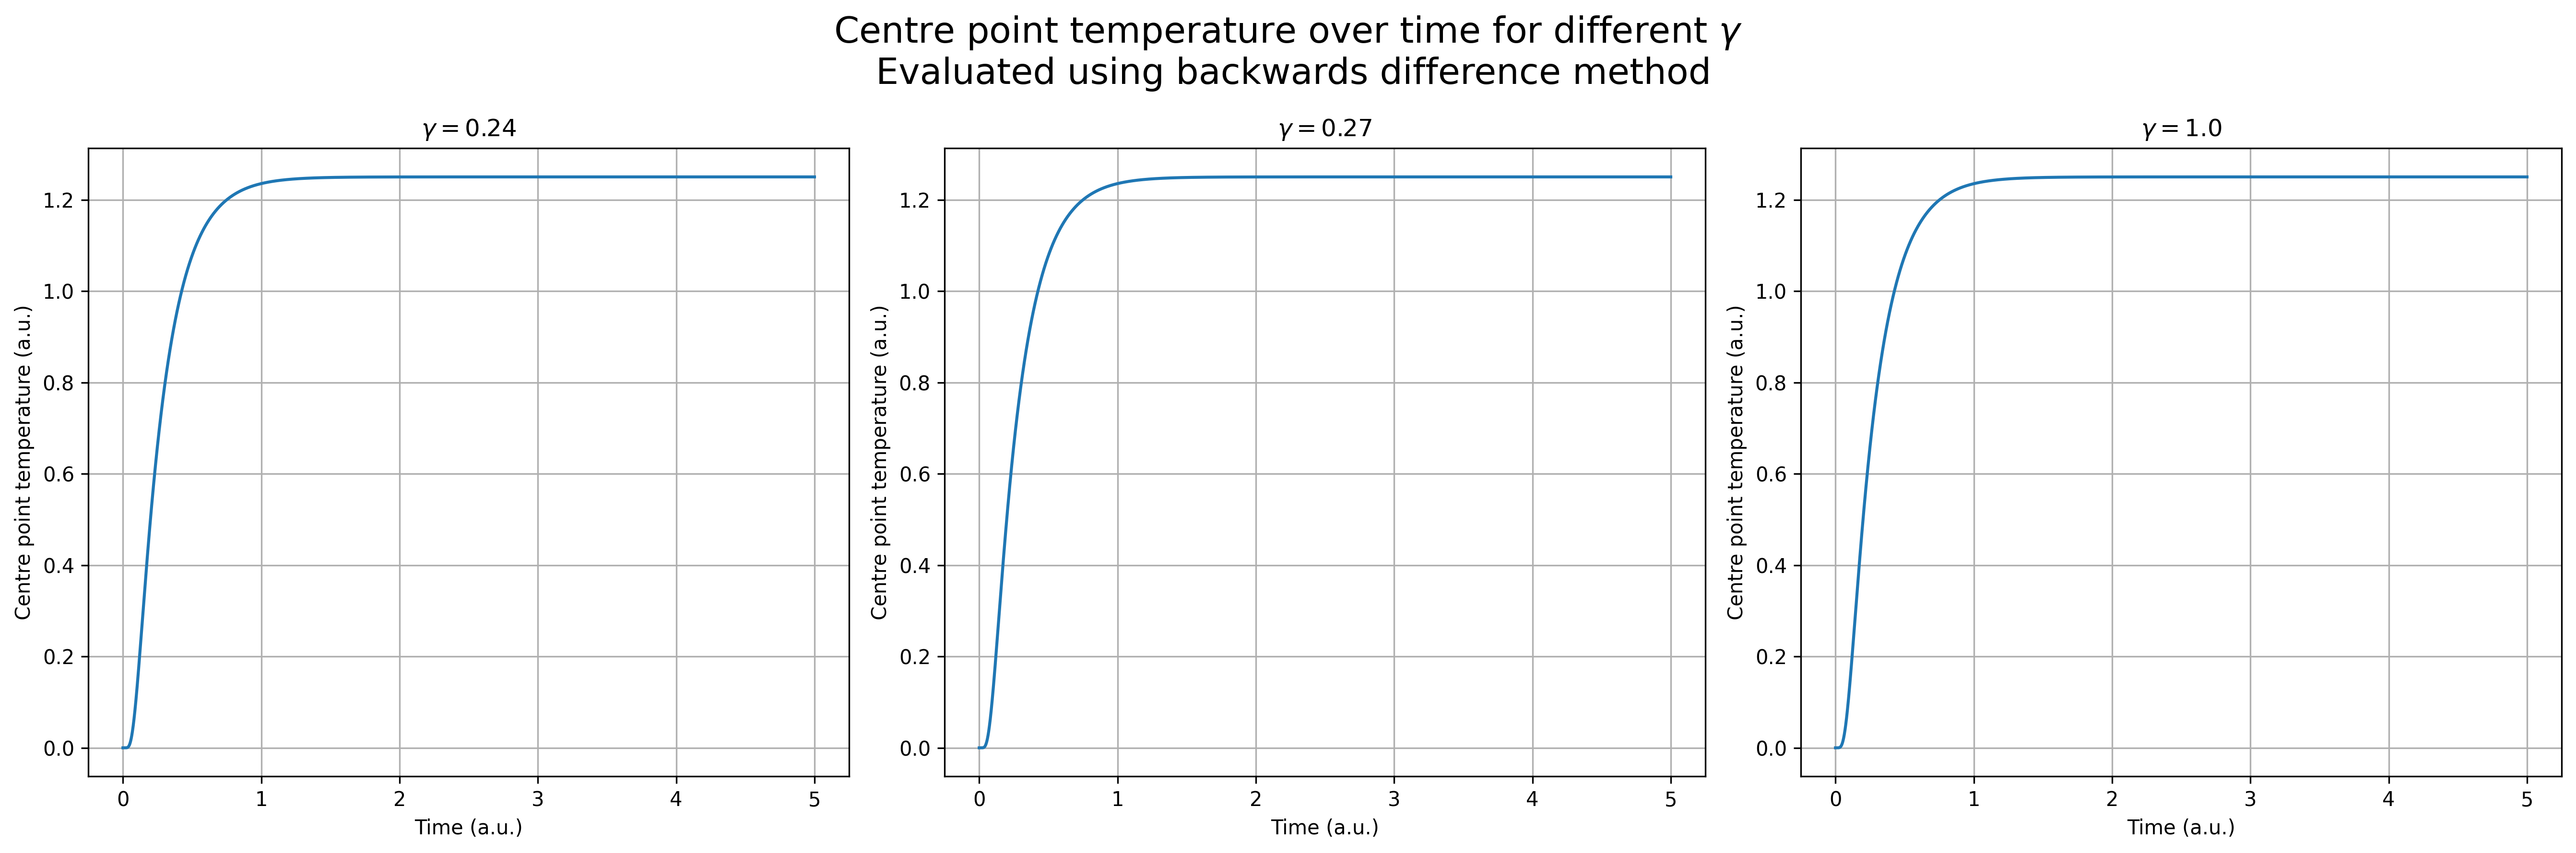

In [33]:
# Create figure for plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot stable soln
axes[0].plot(t1_back, u1_back)
axes[0].set_title(f"$\gamma={gamma1}$")
# Plot unstable soln
axes[1].plot(t2_back, u2_back)
axes[1].set_title(f"$\gamma={gamma2}$")
# Plot super unstable soln
axes[2].plot(t3_back, u3_back)
axes[2].set_title(f"$\gamma={gamma3}$")

# Make plot neater
for ax in axes:
    ax.set_xlabel("Time (a.u.)")
    ax.set_ylabel("Centre point temperature (a.u.)")
    ax.grid()

# Supertitle
plt.suptitle("Centre point temperature over time for different $\gamma$ \n Evaluated using backwards difference method",
             fontsize=18)
plt.tight_layout()

Given the colour maps we had earlier for the backward difference method, it perhaps is not surprising to see that for $\gamma > 0.25$ we see roughly the same trend as for $\gamma < 0.25$. The above graphs demonstrate once again the unconditional stability of the backward Euler solver. Yet, it also looks like they asymptote at around the same value of $u$, for the same time. This suggests that at least for $\gamma < 1$, the accuracy as we increase $\gamma$ further into the previously unstable regime is not really compromised. We should make sure anyways:

In [34]:
print(f"For gamma = {gamma1}, max temperature = {u1_back[-1]}")
print(f"For gamma = {gamma2}, max temperature = {u2_back[-1]}")
print(f"For gamma = {gamma3}, max temperature = {u3_back[-1]}")

For gamma = 0.24, max temperature = 1.2499999999597946
For gamma = 0.27, max temperature = 1.249999999959762
For gamma = 1.0, max temperature = 1.2499999999567113


Whilst not visibly noticeable, we can see that as $\gamma$ increases, we do begin to get more disagreement with smaller values of $\gamma$. However, this disagreement is often miniscule, appearing beyond the 10th decimal place.

#### Crank-Nicolson implementation
We repeat the same visual analysis, plotting the temperature distribution of the center of the plate as a function of time.

<>:6: SyntaxWarning: invalid escape sequence '\g'
<>:9: SyntaxWarning: invalid escape sequence '\g'
<>:12: SyntaxWarning: invalid escape sequence '\g'
<>:21: SyntaxWarning: invalid escape sequence '\g'
<>:6: SyntaxWarning: invalid escape sequence '\g'
<>:9: SyntaxWarning: invalid escape sequence '\g'
<>:12: SyntaxWarning: invalid escape sequence '\g'
<>:21: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-3895142297.py:6: SyntaxWarning: invalid escape sequence '\g'
  axes[0].set_title(f"$\gamma={gamma1}$")
/tmp/ipython-input-3895142297.py:9: SyntaxWarning: invalid escape sequence '\g'
  axes[1].set_title(f"$\gamma={gamma2}$")
/tmp/ipython-input-3895142297.py:12: SyntaxWarning: invalid escape sequence '\g'
  axes[2].set_title(f"$\gamma={gamma3}$")
/tmp/ipython-input-3895142297.py:21: SyntaxWarning: invalid escape sequence '\g'
  plt.suptitle("Centre point temperature over time for different $\gamma$ \n Evaluated using Crank-Nicolson method",


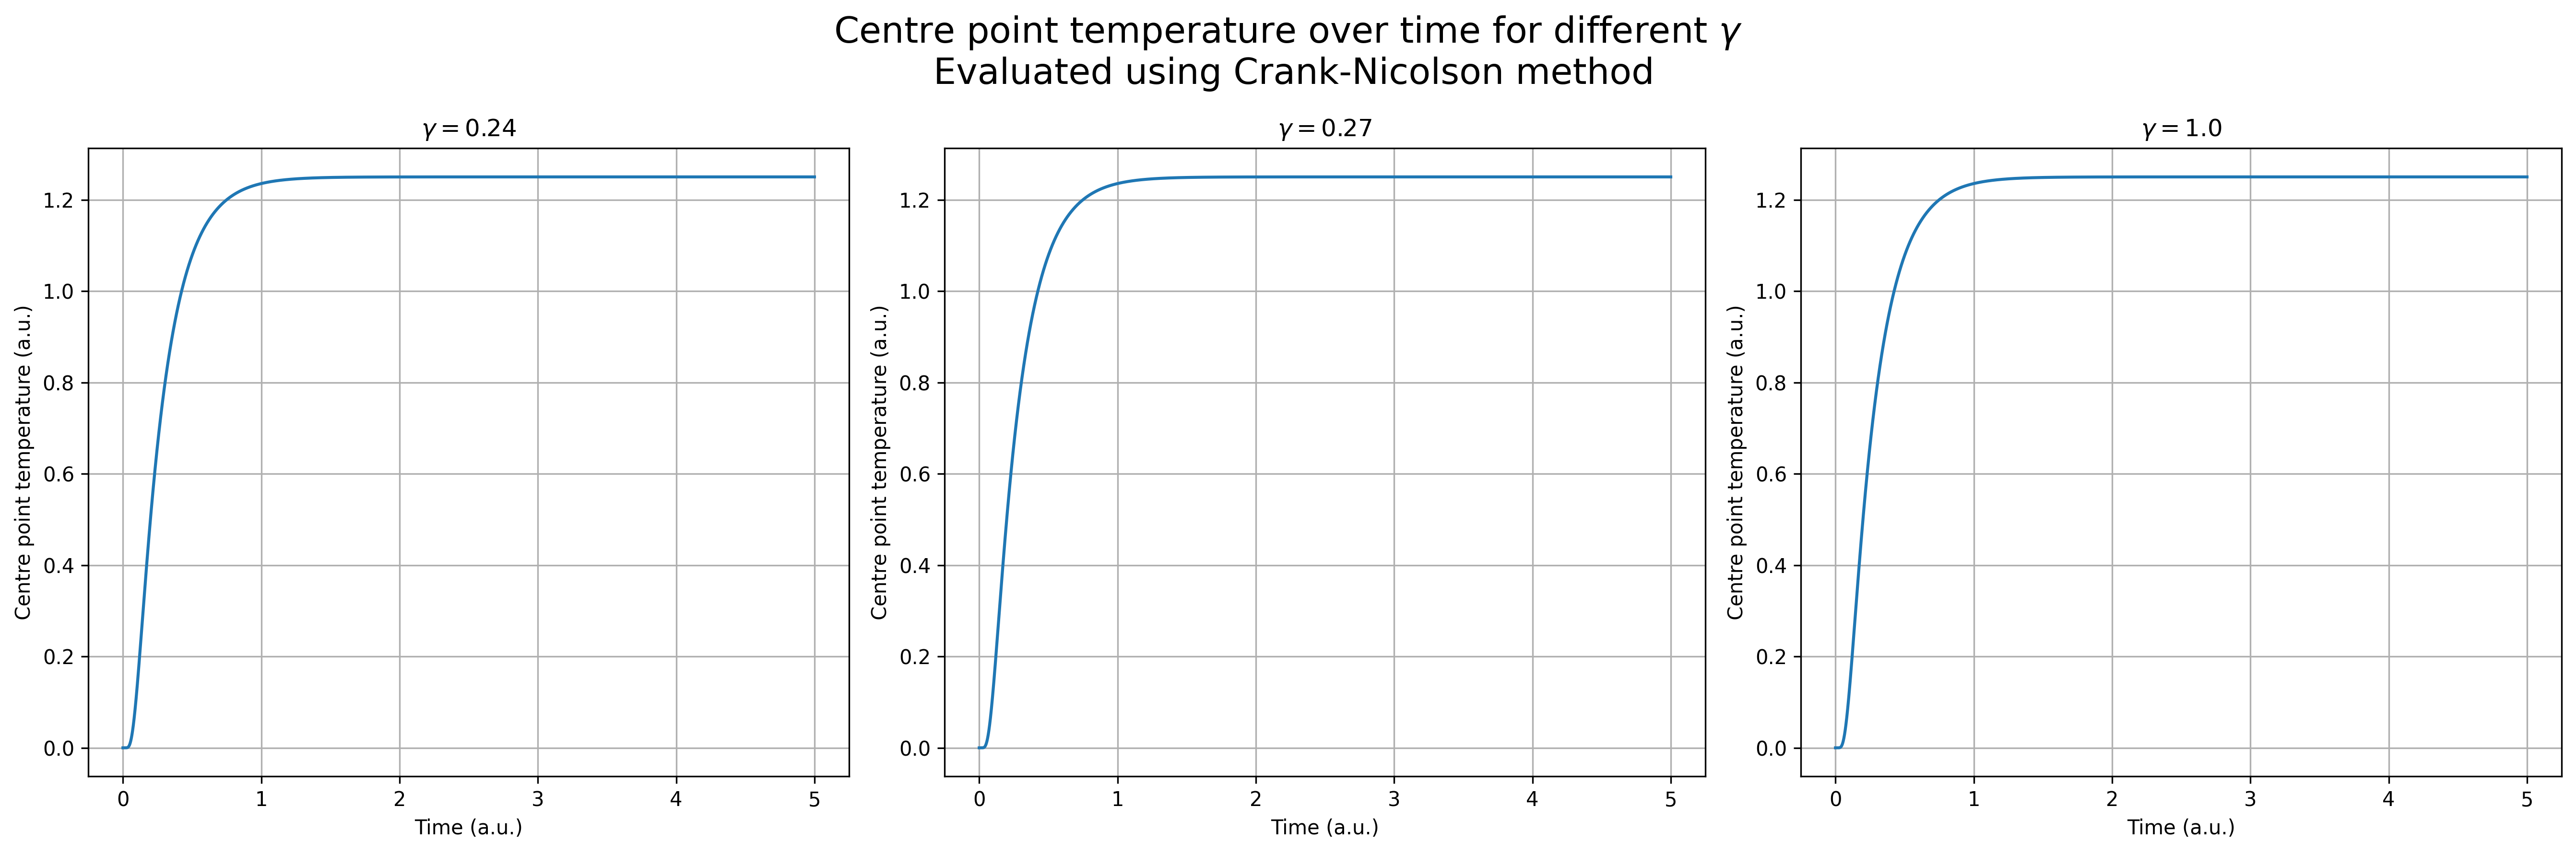

In [35]:
# Create figure for plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot stable soln
axes[0].plot(t1_CN, u1_CN)
axes[0].set_title(f"$\gamma={gamma1}$")
# Plot unstable soln
axes[1].plot(t2_CN, u2_CN)
axes[1].set_title(f"$\gamma={gamma2}$")
# Plot super unstable soln
axes[2].plot(t3_CN, u3_CN)
axes[2].set_title(f"$\gamma={gamma3}$")

# Make plot neater
for ax in axes:
    ax.set_xlabel("Time (a.u.)")
    ax.set_ylabel("Centre point temperature (a.u.)")
    ax.grid()

# Supertitle
plt.suptitle("Centre point temperature over time for different $\gamma$ \n Evaluated using Crank-Nicolson method",
             fontsize=18)
plt.tight_layout()

Once again, we observe the same thing as we did for the backward Euler scheme; the Crank-Nicolson method is one which is unconditionally stable for all $\gamma$. Hence, we can safely say that both the backward Euler and Crank-Nicolson solvers are unconditionally stable, we have verified this.

## Investigating implicit solver errors between $t^*_{obs}$ and $t^*$
The above graph for the Crank-Nicolson method shows once again that the midpoint temperature asymptotes as time increases. For the backward Euler scheme, we noticed that larger values of $\gamma$ started to disagree with what this asymptotic limit is, albeit this disagreement was very small and appearing after the 10th decimal place. It would be interesting to see how this disagreement behaves for the Crank-Nicolson technique.

This leads us to investigating the implicit solver errors between $t^*_{obs}$ and $t^*$ as a function of $N$ and $\gamma$, in an ultimately similar analysis to what we did with the explicit technique. Infact, we will also compare these errors to that of the explicit method.

### Error as a function of $\gamma$
We start our analysis off by computing the error between $t^*_{obs}$ and $t^*$ as a function of $\gamma$, for all three solvers discussed in this report. Due to the capabilities of the explicit scheme, we need to temporarily limit the analysis to $\gamma < 0.25$.

In [36]:
# Create tstar storage for each solver
t_star_explicit_gamma = []; t_star_backward_gamma = []; t_star_CN_gamma = []
# Specify range of gammas we wish to test, alongside N and maximum time
gammas = np.arange(0.05, 3.004, 0.005); t_max = 0.5; N=51

# For each value of gamma, solve the heat eqn and find the time for which u[center] > 1
for gamma in tqdm(gammas):
    # Explicit scheme
    if gamma <= 0.25:
        _, _, t_star = central_heat_profile(N, t_max, gamma, explicit_heat_kernel, dtype=np.float64)
        t_star_explicit_gamma.append(t_star)

    # Backward scheme
    _, _, t_star = central_heat_profile(N, t_max, gamma, backward_heat_grid, dtype=np.float64)
    t_star_backward_gamma.append(t_star)

    # Crank-Nicholson scheme
    _, _, t_star = central_heat_profile(N, t_max, gamma, CN_heat_grid, dtype=np.float64)
    t_star_CN_gamma.append(t_star)

100%|██████████| 591/591 [03:50<00:00,  2.56it/s]


### Error as a function of $N$
We also find the error as a function of $N$. The code follows almost the exact same pattern as that above. We limit our analysis to $N < 142$, as beyond this we risk our kernel crashing.

In [37]:
# Create tstar storage for each solver
t_star_explicit_N = []; t_star_backward_N = []; t_star_CN_N = []
# Specify range of N we wish to test, alongside gamma and maximum time
N = np.arange(21,142,10); t_max = 0.5; gamma = 0.24

# For each value of gamma, solve the heat eqn and find the time for which u[center] > 1
for n in tqdm(N):
    # Explicit scheme
    _, _, t_star = central_heat_profile(n, t_max, gamma, explicit_heat_kernel, dtype=np.float64)
    t_star_explicit_N.append(t_star)

    # Backward scheme
    _, _, t_star = central_heat_profile(n, t_max, gamma, backward_heat_grid, dtype=np.float64)
    t_star_backward_N.append(t_star)

    # Crank-Nicholson scheme
    _, _, t_star = central_heat_profile(n, t_max, gamma, CN_heat_grid, dtype=np.float64)
    t_star_CN_N.append(t_star)

 38%|███▊      | 5/13 [00:04<00:08,  1.03s/it]/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 25 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
100%|██████████| 13/13 [04:32<00:00, 20.96s/it]


#### Plotting errors
Now, we will plot both the deviation of $t^*_{obs}$ from the true $t^*$ as functions of $N$ and $\gamma$, much like we have done for the explicit analysis above.

<>:11: SyntaxWarning: invalid escape sequence '\g'
<>:22: SyntaxWarning: invalid escape sequence '\g'
<>:23: SyntaxWarning: invalid escape sequence '\g'
<>:11: SyntaxWarning: invalid escape sequence '\g'
<>:22: SyntaxWarning: invalid escape sequence '\g'
<>:23: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-345849075.py:11: SyntaxWarning: invalid escape sequence '\g'
  axes[0].set_title("$t^*_{obs}$ as a function of $N$ ($\gamma=0.24$)")
/tmp/ipython-input-345849075.py:22: SyntaxWarning: invalid escape sequence '\g'
  axes[1].set_xlabel("Laplacian prefactor $\gamma$");axes[1].set_ylabel("$t^*_{obs}$")
/tmp/ipython-input-345849075.py:23: SyntaxWarning: invalid escape sequence '\g'
  axes[1].set_title("$t^*_{obs}$ as a function of $\gamma$ ($N=51$)")


Text(0.5, 0.98, 'Assessing $t^*_{obs}$ dependancy on spatial and temporal discretisations')

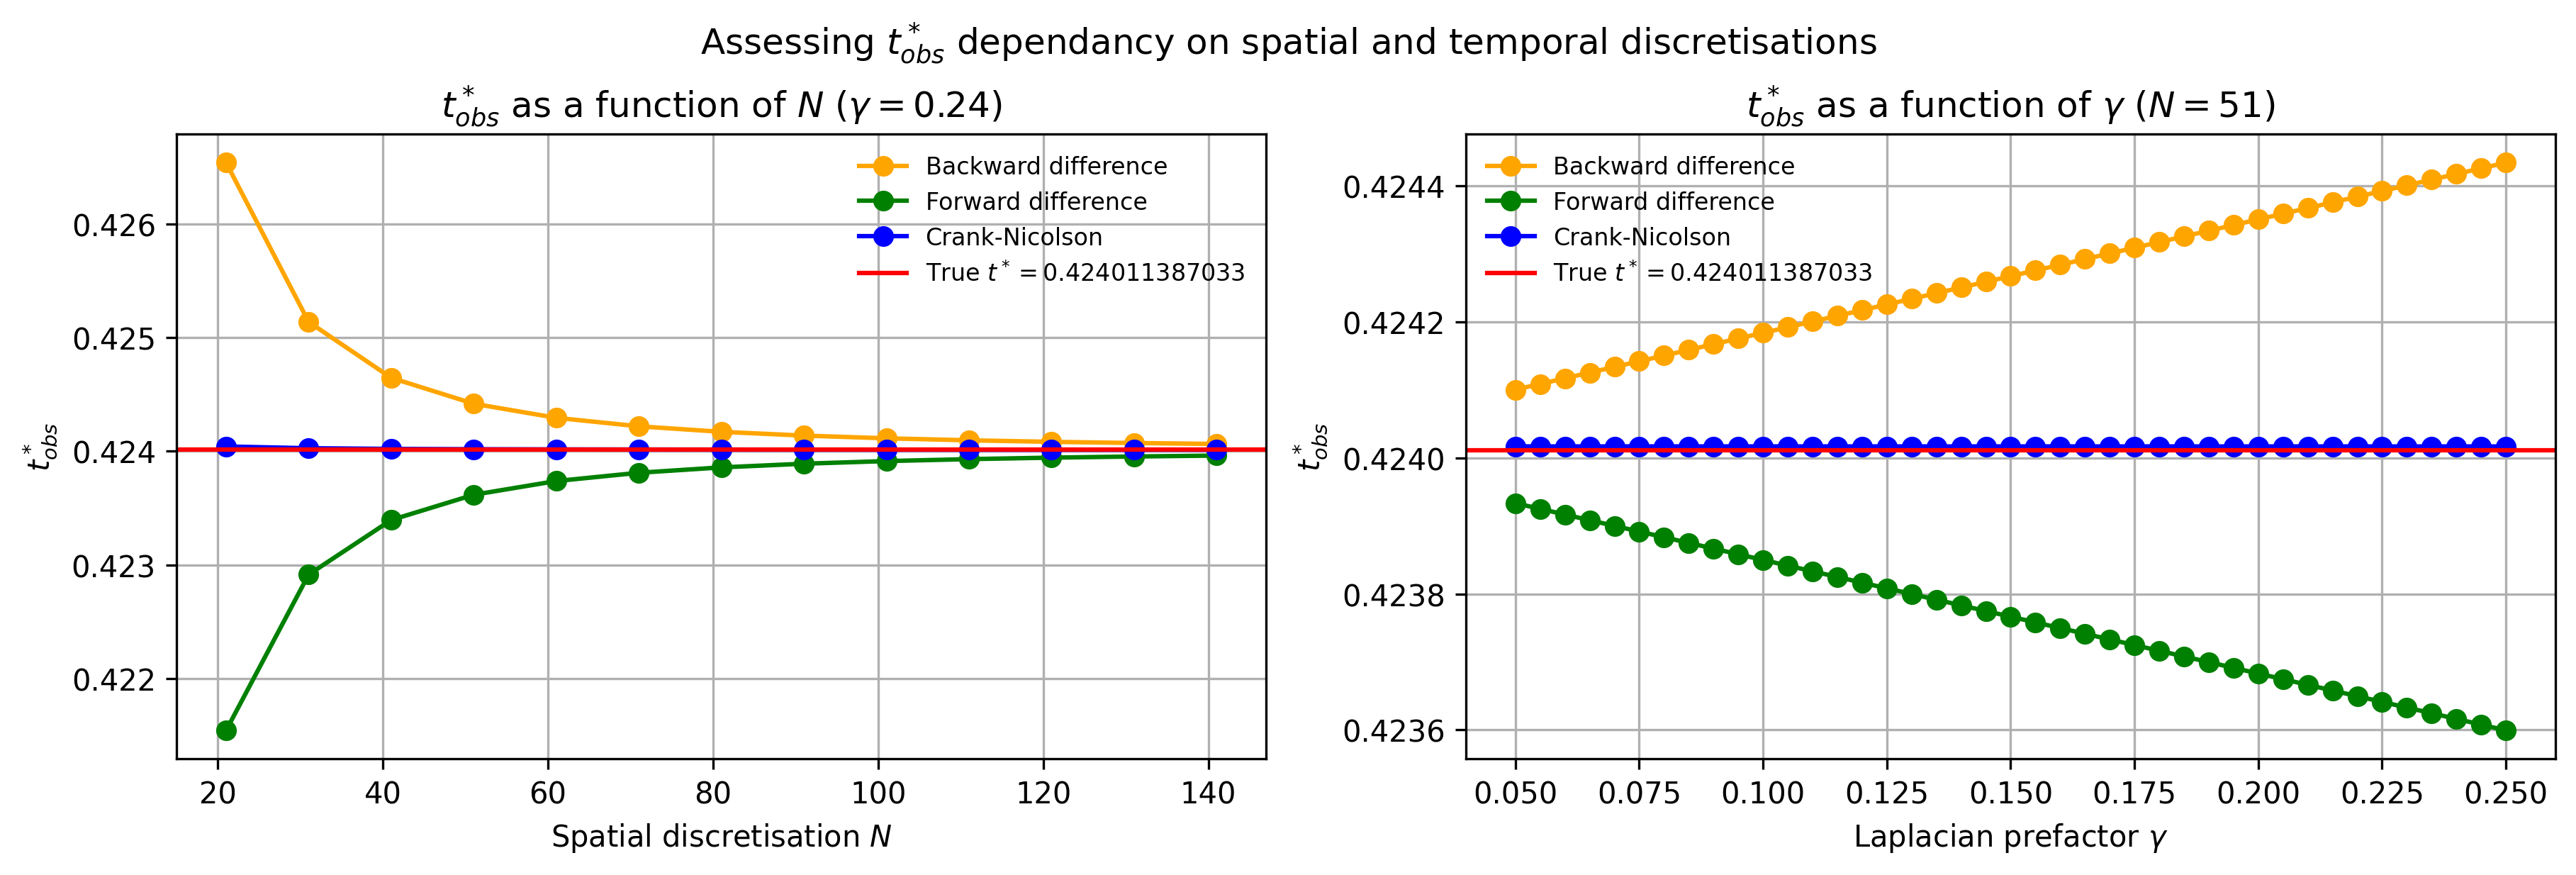

In [38]:
# Plot tstar observations as functions of N and gamma
fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

# On the left-hand plot, we plot tstar observed as a function of N
axes[0].plot(N, t_star_backward_N, "-o", color="orange", label="Backward difference")
axes[0].plot(N, t_star_list, "-o", color="green", label="Forward difference")
axes[0].plot(N, t_star_CN_N, "-o", color="blue", label="Crank-Nicolson")
axes[0].axhline(t_star_true, color="red", label=f"True $t^* = {t_star_true}$")
# Make plot neater
axes[0].set_xlabel("Spatial discretisation $N$"); axes[0].set_ylabel("$t^*_{obs}$")
axes[0].set_title("$t^*_{obs}$ as a function of $N$ ($\gamma=0.24$)")
axes[0].grid(); axes[0].legend(fontsize=8)

# On the right-hand plot, we plot tstar observed as a function of gamma
# Due to the instability of the explicit technique, we only go up to gamma=0.25
max_gamma = len(t_star_explicit_gamma)
axes[1].plot(gammas[:max_gamma], t_star_backward_gamma[:max_gamma],"-o", color="orange", label="Backward difference")
axes[1].plot(gammas[:max_gamma], t_star_explicit_gamma[:max_gamma],"-o", color="green", label="Forward difference")
axes[1].plot(gammas[:max_gamma], t_star_CN_gamma[:max_gamma],"-o", color="blue", label="Crank-Nicolson")
axes[1].axhline(t_star_true, color="red", label=f"True $t^* = {t_star_true}$")
# Make plot neater
axes[1].set_xlabel("Laplacian prefactor $\gamma$");axes[1].set_ylabel("$t^*_{obs}$")
axes[1].set_title("$t^*_{obs}$ as a function of $\gamma$ ($N=51$)")
axes[1].grid(); axes[1].legend(fontsize=8)

plt.suptitle("Assessing $t^*_{obs}$ dependancy on spatial and temporal discretisations")

The plot above shows us that the backward and forward difference behave roughly the same, no matter whether $N$ or $\gamma$ is the varying parameter. Their errors almost exactly match. However, it is evident from the graph above that the forward difference always underestimates the true $t^*$, whereas the backward difference always overestimates it. We can therefore draw the conclusion that the forward and backward difference exhibit temporally and spatially the same error (of order $\Delta t$ and $(\Delta x)^2$ respectively).

The real fascination comes from the Crank-Nicolson technique which is clearly a far more accurate solver than both the forward and backward difference method, at least for our limited $N$ regime. This is because its time error is of the order $(\Delta t)^2$, hence its accuracy is much improved.

### Taking a further look at the Crank-Nicolson error
It is worth having a closer look at the Crank-Nicolson implementation, as it is clearly very promising. Let us plot the absolute error $|t^*_{obs} - t^*|$ as a function of $N$ and $\gamma$ and see if we can pick out any interesting results.

In [39]:
# Find out the absolute error between the tstar obs as a function of N
# Observed tstar - real tstar
t_back_error_N = np.abs(t_star_backward_N - np.ones(len(t_star_backward_N))*t_star_true)
t_explicit_error_N = np.abs(t_star_explicit_N - np.ones(len(t_star_explicit_N))*t_star_true)
t_CN_error_N = np.abs(t_star_CN_N - np.ones(len(t_star_CN_N))*t_star_true)

# Find out the absolute error between the tstar obs as a function of N
# Observed tstar - real tstar
t_back_error_gamma = np.abs(t_star_backward_gamma - np.ones(len(t_star_backward_gamma))*t_star_true)
t_explicit_error_gamma = np.abs(t_star_explicit_gamma - np.ones(len(t_star_explicit_gamma))*t_star_true)
t_CN_error_gamma = np.abs(t_star_CN_gamma - np.ones(len(t_star_CN_gamma))*t_star_true)

<>:8: SyntaxWarning: invalid escape sequence '\g'
<>:16: SyntaxWarning: invalid escape sequence '\g'
<>:17: SyntaxWarning: invalid escape sequence '\g'
<>:8: SyntaxWarning: invalid escape sequence '\g'
<>:16: SyntaxWarning: invalid escape sequence '\g'
<>:17: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-3588280376.py:8: SyntaxWarning: invalid escape sequence '\g'
  axes[0].set_title("Function of $N$ ($\gamma=0.24$)")
/tmp/ipython-input-3588280376.py:16: SyntaxWarning: invalid escape sequence '\g'
  axes[1].set_xlabel("Laplacian prefactor $\gamma$"); axes[1].set_ylabel("$|t^*_{obs} - t^*|$")
/tmp/ipython-input-3588280376.py:17: SyntaxWarning: invalid escape sequence '\g'
  axes[1].set_title("Function of $\gamma$ ($N=51$)")


Text(0.5, 0.98, 'Backward minus forward error as a function of spatial and temporal discretisations \n Crank-Nicolson method')

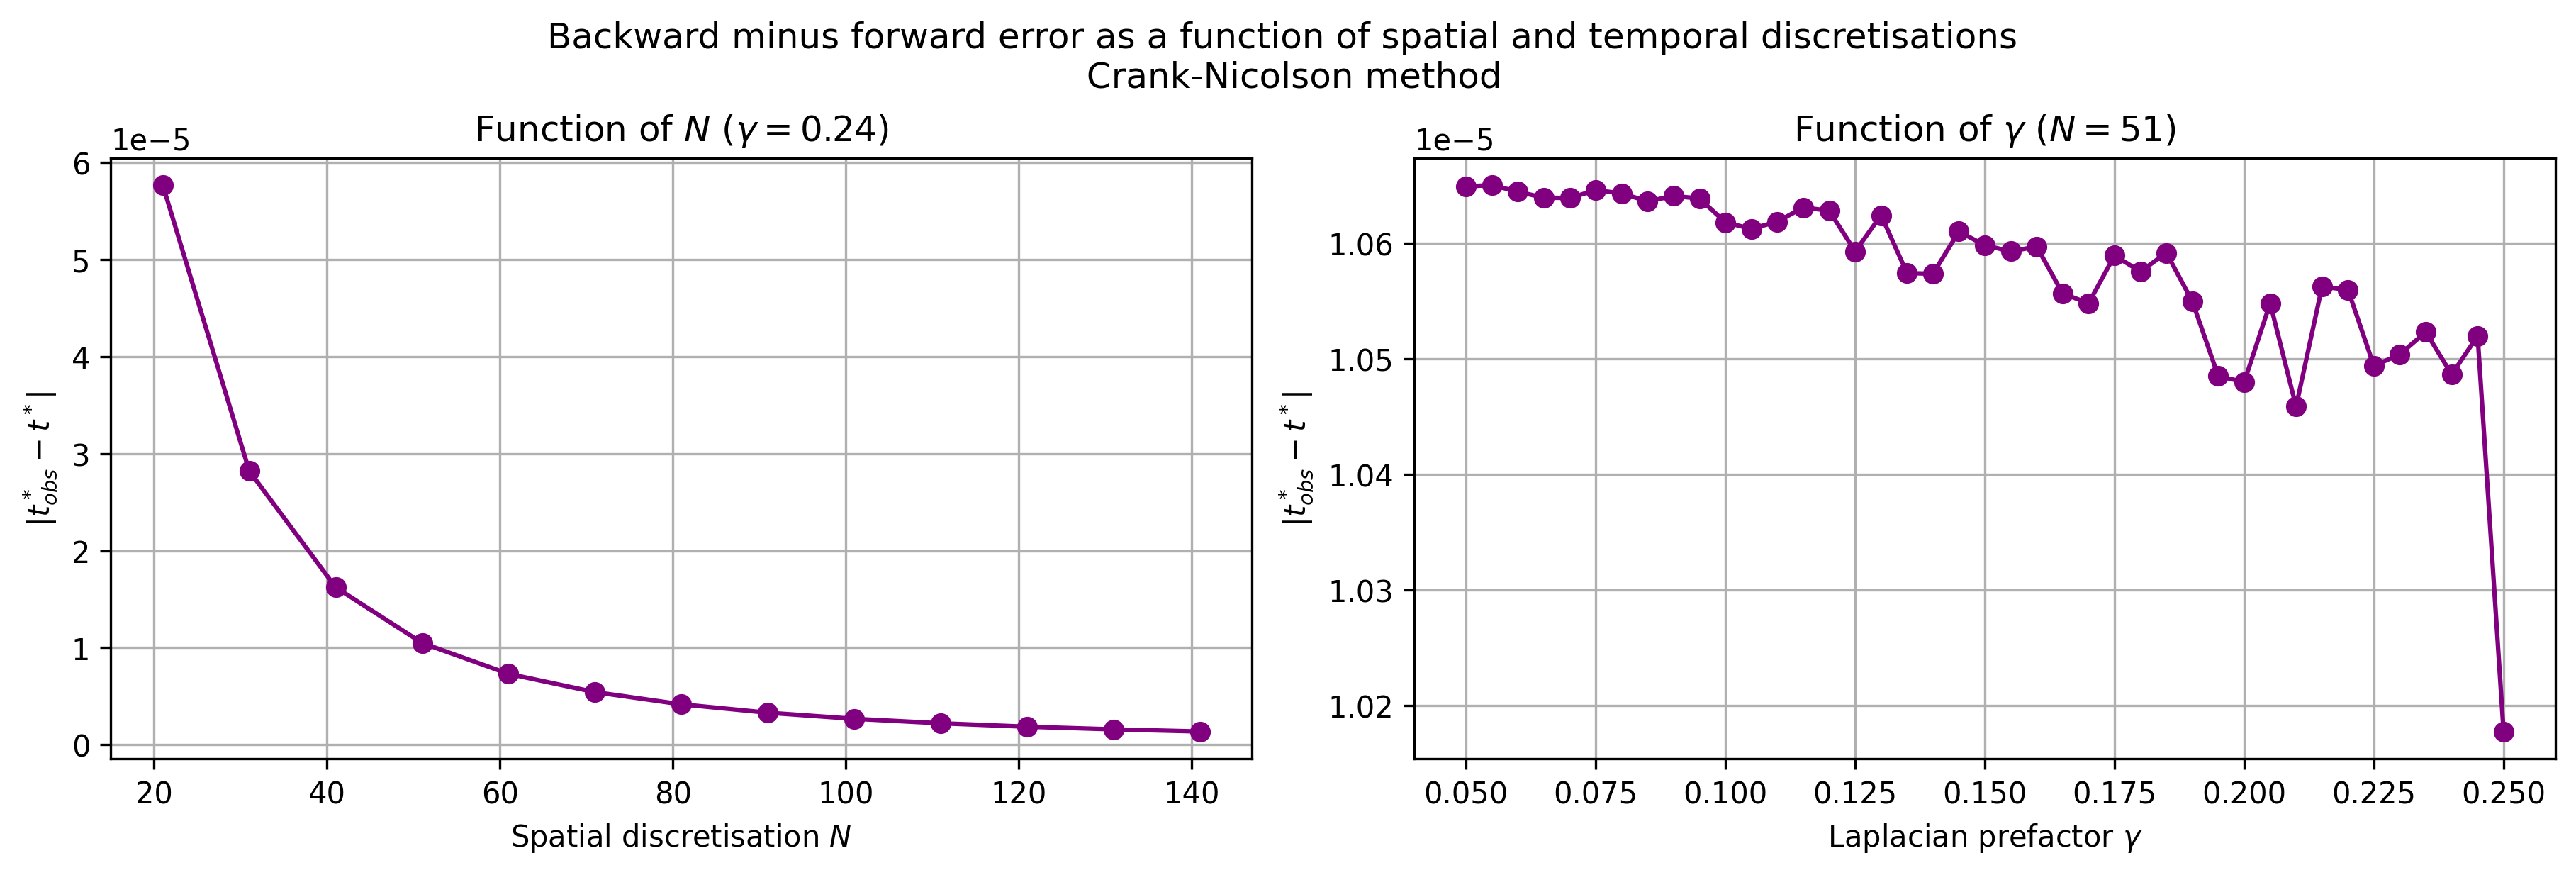

In [40]:
# Assess the difference between forward and backward errors by plotting them
fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

# On the left-hand plot, we plot the difference between forward and backward error as a function of N
axes[0].plot(N, t_back_error_N - t_explicit_error_N, "-o", color="purple")
# Make plot neater
axes[0].set_xlabel("Spatial discretisation $N$"); axes[0].set_ylabel("$|t^*_{obs} - t^*|$")
axes[0].set_title("Function of $N$ ($\gamma=0.24$)")
axes[0].grid()

# On the right-hand plot, we plot the difference between forward and backward error as a function of gamma
# Only go up to gamma=0.25
max_gamma = len(t_star_explicit_gamma)
axes[1].plot(gammas[:max_gamma], t_back_error_gamma[:max_gamma] - t_explicit_error_gamma, "-o", color="purple")
# Make plot neater
axes[1].set_xlabel("Laplacian prefactor $\gamma$"); axes[1].set_ylabel("$|t^*_{obs} - t^*|$")
axes[1].set_title("Function of $\gamma$ ($N=51$)")
axes[1].grid()

plt.suptitle("Backward minus forward error as a function of spatial and temporal discretisations \n Crank-Nicolson method")

Over the spatial discretisation $N$, the Crank-Nicolson error actually follows quite a similar trend to that of the forward and backward difference methods. However, we can see that the magnitude of this error is far smaller, around $10^{-5}$. This is likely suggesting that the Crank-Nicolson error is of order $(\Delta x)^4$, hence it would be far more accurate spatially.

The right-hand side plot, showing this error as a function of $\gamma$, clearly is also squashed to small orders of magnitude. The error looks like it dramatically falls close to $\gamma = 0.25$, but we should be aware of the $y-$scale in this plot, it actually only falls by a few percent.

Let us now assess these errors in logarithmic plots, taking now a much larger range of $\gamma$ into account.

<>:9: SyntaxWarning: invalid escape sequence '\g'
<>:16: SyntaxWarning: invalid escape sequence '\g'
<>:17: SyntaxWarning: invalid escape sequence '\g'
<>:9: SyntaxWarning: invalid escape sequence '\g'
<>:16: SyntaxWarning: invalid escape sequence '\g'
<>:17: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-2224045590.py:9: SyntaxWarning: invalid escape sequence '\g'
  axes[0].set_title("Function of $N$ ($\gamma=0.24$)")
/tmp/ipython-input-2224045590.py:16: SyntaxWarning: invalid escape sequence '\g'
  axes[1].set_xlabel("Laplacian prefactor $\gamma$"); axes[1].set_ylabel("$|t^*_{obs} - t^*|$")
/tmp/ipython-input-2224045590.py:17: SyntaxWarning: invalid escape sequence '\g'
  axes[1].set_title("Function of $\gamma$ ($N=51$)")


Text(0.5, 0.98, 'Crank-Nicolson error as a function of spatial and temporal discretisations\n (Red line represents 12-digit precision to true $t^*$)')

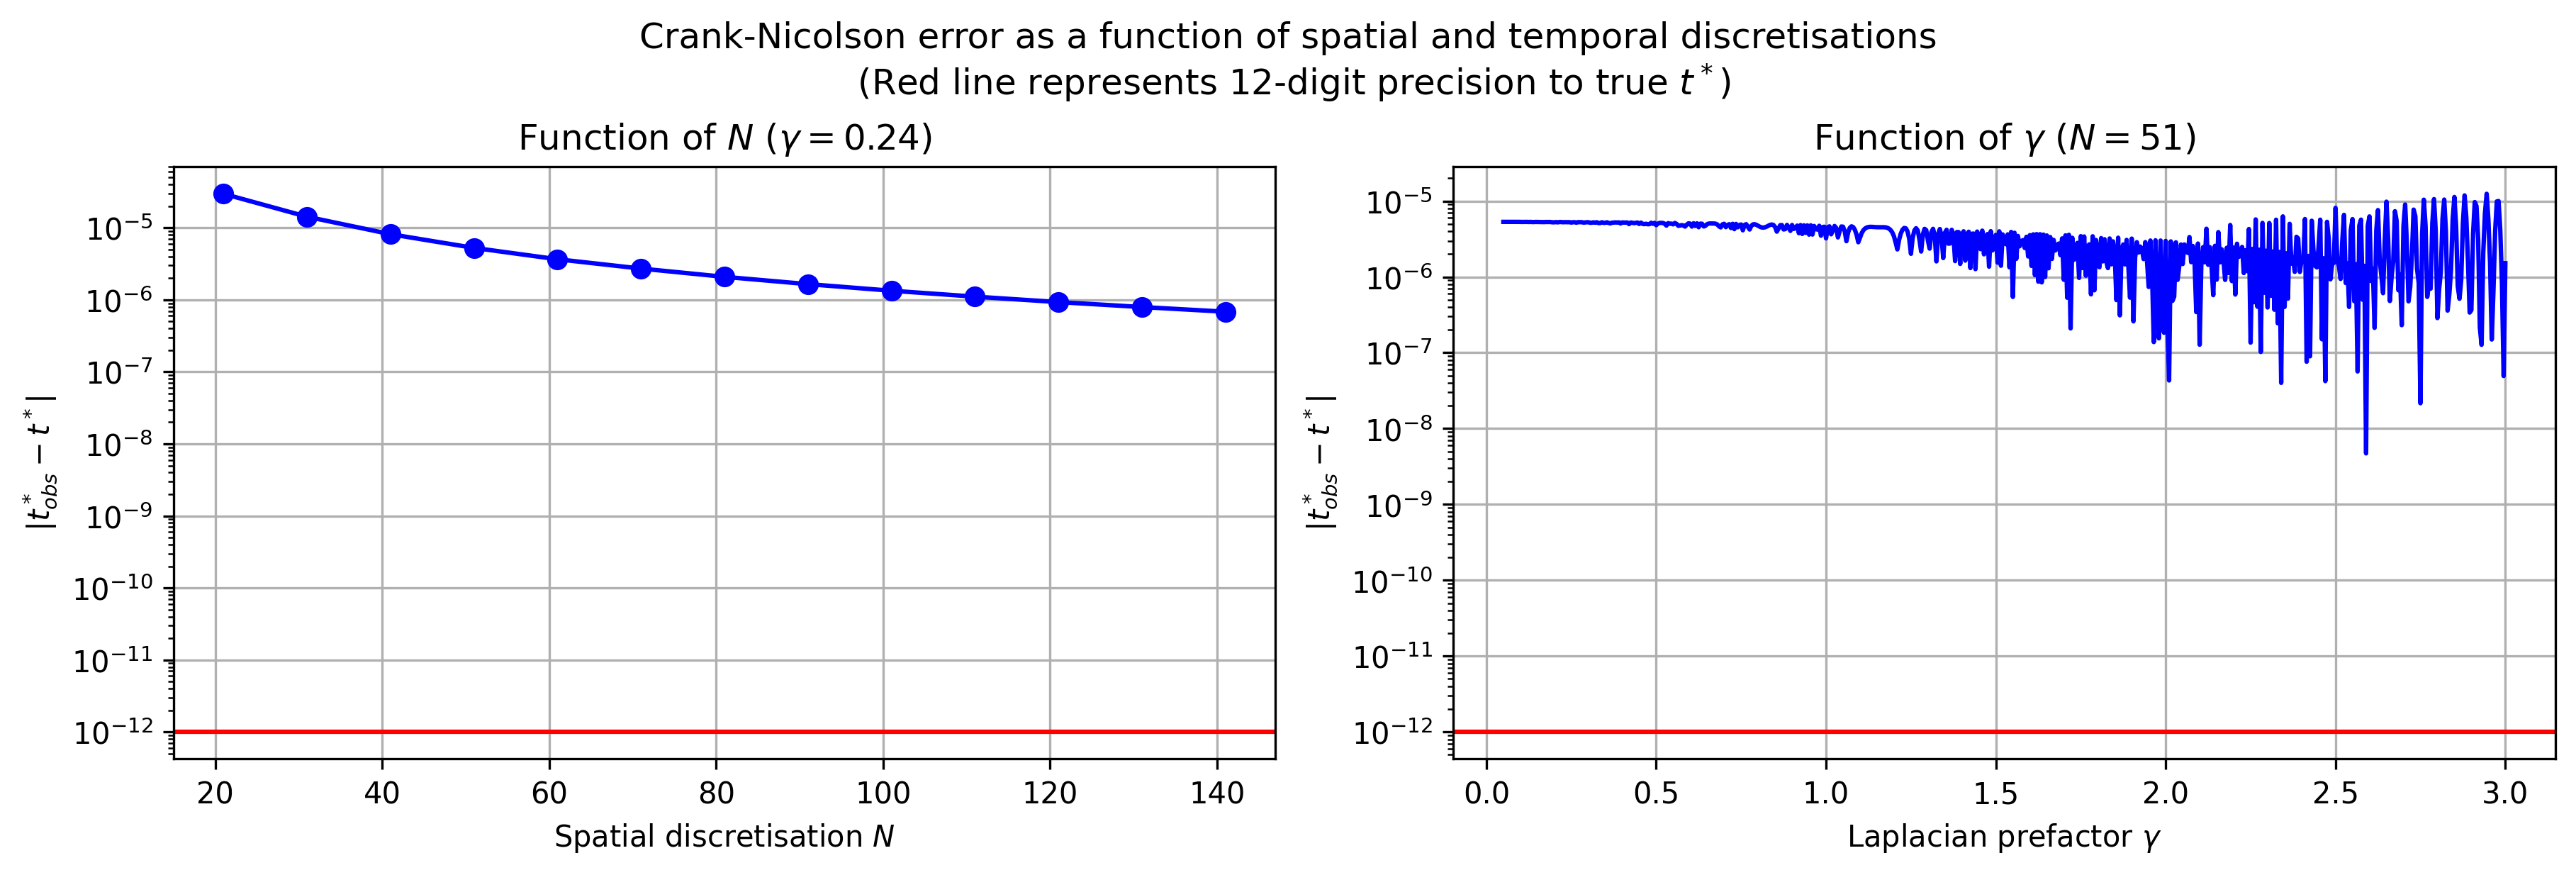

In [41]:
# Assess the difference between forward and backward errors by plotting them
fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

# On the left-hand plot, we plot Crank-Nicolson error as function of N
axes[0].plot(N, t_CN_error_N, "-o", color="blue")
axes[0].axhline(1e-12, color="red")
# Make plot neater
axes[0].set_xlabel("Spatial discretisation $N$"); axes[0].set_ylabel("$|t^*_{obs} - t^*|$")
axes[0].set_title("Function of $N$ ($\gamma=0.24$)")
axes[0].grid(); axes[0].set_yscale("log")

# On the left-hand plot, we plot Crank-Nicolson error as function of gamma
axes[1].plot(gammas, t_CN_error_gamma, color="blue")
axes[1].axhline(1e-12, color="red")
# Make plot neater
axes[1].set_xlabel("Laplacian prefactor $\gamma$"); axes[1].set_ylabel("$|t^*_{obs} - t^*|$")
axes[1].set_title("Function of $\gamma$ ($N=51$)")
axes[1].grid(); axes[1].set_yscale("log")

plt.suptitle("Crank-Nicolson error as a function of spatial and temporal discretisations" \
f"\n (Red line represents 12-digit precision to true $t^*$)")

The left-hand plot unsurprisingly gives us a smooth relationship between the error and the spatial discretisation, showing a rough decrease as $N$ increases. Interestingly, the right-hand side plot shows us that increasing $\gamma$ produces weird variations in this error, with a minimum seemingly at $\gamma \approx 2.6$. Once again, we should be skeptical for $\gamma$ this large, as this represents a really coarse discretisation of the time. This seemingly minimum error could just be a lucky error cancellation appearing for this value of $\gamma$ and could actually result in a globally more inaccurate solution.

### Investigating $\gamma$ supposedly giving a minimum error
We now want to check whether this value of $\gamma$ is special in that it minimises the error only for $N=51$, or if it is truly an optimal $\gamma$ which minimises this error for all $N$. We begin by extracting this value of $\gamma$ out, which we call `gamma_min`.

In [42]:
gamma_min = gammas[np.argmin(t_CN_error_gamma)]
gamma_min

np.float64(2.5899999999999985)

Next, we will solve for the error between $t^*_{obs}$ and $t^*$ using this value of $\gamma$ for a range of $N$, and plot it on a logarithmic scale.

In [43]:
# Create tstar storage for each solver
t_star_explicit_N = []; t_star_backward_N = []; t_star_CN_N = []
# Specify range of N we wish to test, alongside gamma and maximum time
N = np.arange(11,202,4); t_max = 0.5; gamma = gamma_min

# For each value of gamma, solve the heat eqn and find the time for which u[center] > 1
for n in tqdm(N):
    # Crank-Nicholson scheme
    _, _, t_star = central_heat_profile(n, t_max, gamma_min, CN_heat_grid, dtype=np.float64)
    t_star_CN_N.append(t_star)

100%|██████████| 48/48 [02:57<00:00,  3.69s/it]


<>:9: SyntaxWarning: invalid escape sequence '\g'
<>:9: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-2271465996.py:9: SyntaxWarning: invalid escape sequence '\g'
  plt.title("Function of $N$ ($\gamma=2.589$)")


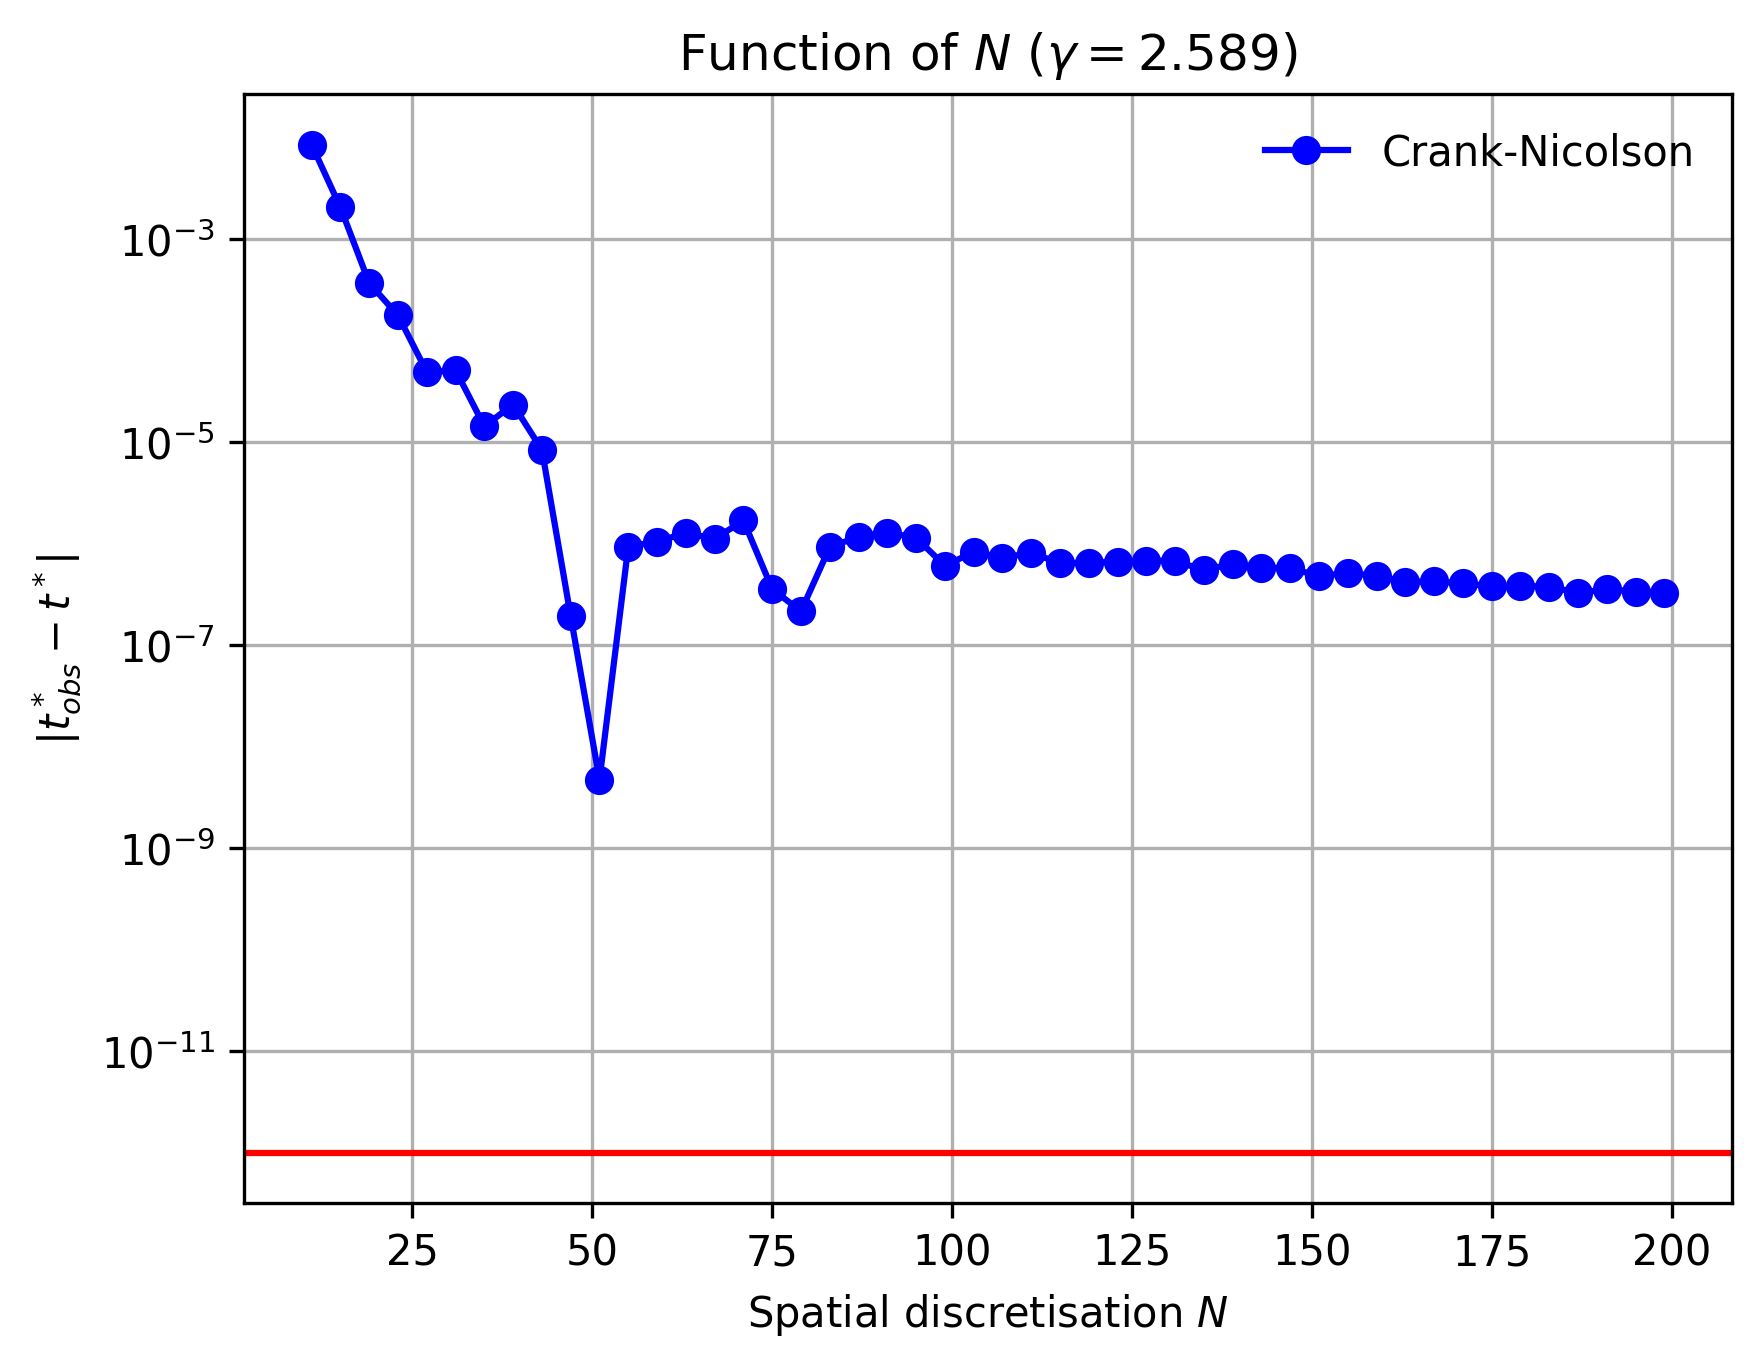

In [44]:
# Find difference between tstar observed and actual for all tstars found using N values
t_CN_error_N = np.abs(t_star_CN_N - np.ones(len(t_star_CN_N))*t_star_true)


plt.plot(N, t_CN_error_N, "-o", color="blue",label="Crank-Nicolson")
plt.axhline(1e-12, color="red")
# Make plot neater
plt.xlabel("Spatial discretisation $N$"); plt.ylabel("$|t^*_{obs} - t^*|$")
plt.title("Function of $N$ ($\gamma=2.589$)")
plt.grid(); plt.yscale("log"); plt.legend()

The above plot confirms our skepticism about this value of $\gamma$ we found - it is only really good for $N=51$, and alright for all other values of $N$. We did reason that $\gamma$ as large as this would give us a coarse discretisation of the time, and hence would be globally inaccurate, thus we were skeptical about it.

It seems that there is a temporal discretisation, $\gamma$, which can exactly cancel out a contribution from the spatial discretisation, $N$, to give a very accurate estimate for $t^*$. However, these error cancellations are likely only true for the center point of the plate where $t^*$ is evaluated, and globally, over the whole plate, our solutions may still be inaccurate.

Generally, if we want an accurate estimate of $t^*$ from the Crank-Nicolson method, the above plots suggest that we should attempt to drive $N$ as high as we can, whilst $\gamma$ can remain at around $0.25$, as there is minimal accuracy gain from reducing $\gamma$ further.

In [49]:
# Solve for central profile given N,gamma
N = 201; t_max = 0.45; gamma=0.24
_, _, tstar_obs = central_heat_profile(N, t_max, gamma, CN_heat_grid, dtype=np.float64)

# Compare our found tstar to star real
print(f"Time at which the center of the plate first exceeds u=1: \n {tstar_obs} (a.u.)")
print(f"Real time is {t_star_true}")

Time at which the center of the plate first exceeds u=1: 
 0.42401172303183576 (a.u.)
Real time is 0.424011387033


The Crank-Nicolson method gives us an agreement with $t^*$ up to 6 decimal places, so we have an error of the order $10^{-7}$. We could probably push $N$ slightly further, though we held back on this due to fears that the kernel can die.